<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set()

In [3]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 1.7 MB/s 


In [4]:
from pymer4.models import Lmer

In [5]:
!pip install -q statsmodels

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘xtable’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f3c7a63a050> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R 
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [10]:
import warnings
warnings.filterwarnings("ignore")

## Uploading data

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
working_path = Path('/content/drive/MyDrive/CoganLab')

IEEG dataset: ['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'] this subjects are below 75% threshold. 213 No response trials (according to 'Resp' column). Column 'Out' contains infor on whether it is outlier or not. 

In [13]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_subset.csv'),
    index_col=None
)

EEG dataset without outliers but with 'no response' trials. Non of the subjects was rejected because all of them are above 75% accuracy.

In [14]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_no_outliers.csv'),
    index_col=None
)

In [15]:
ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0']
eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0']

## Functions

In [16]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

###EEG dataset

## Preprocessing of the EEG dataset

We will keep the 'No Response' trials. We will treat them as incorrect responses in Accuracy analysis but will drop them in RT analysis.

In [17]:
print(
    'Accuracy without "No response" trials',
    eeg[eeg['Response'] != 'No Response'].ResponseCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg.ResponseCorrect.mean()
)

Accuracy without "No response" trials 0.8723482077542063
Accuracy with "No response" trials 0.8566810344827587


In [18]:
print('Shape of the dataset with no response trials', eeg.shape)
print('Shape of the dataset without no response trials', eeg[eeg['Response'] != 'No Response'].shape)

Shape of the dataset with no response trials (5568, 22)
Shape of the dataset without no response trials (5468, 22)


Mean 1.1349431817298263 Max 2.492920639537033 Min 0.4335620319443478


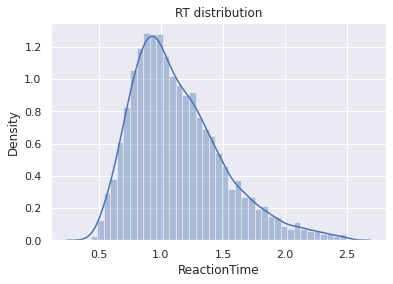

In [19]:
sns.distplot(eeg[eeg['Response'] != 'No Response'].ReactionTime)
pl.title('RT distribution');
print(
    'Mean', eeg[eeg['Response'] != 'No Response'].ReactionTime.mean(),
    'Max', eeg[eeg['Response'] != 'No Response'].ReactionTime.max(),
    'Min', eeg[eeg['Response'] != 'No Response'].ReactionTime.min()
)

In [20]:
values = []
for i in eeg[eeg['Response'] != 'No Response'].Subject.unique():
  subset = eeg[eeg['Response'] != 'No Response']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E2 2
E3 0
E4 0
E5 0
E6 3
E7 5
E8 3
E9 7
E10 6
E11 1
E12 1
E13 0
E15 0
E16 2
E17 0
E18 4
E20 1
E21 0
E22 0
E23 2
E24 2
E25 1
E26 0
E27 0
E28 0
E29 0
E30 0
E31 0
E33 7


In [21]:
len(values)

47

In [22]:
# check for normality of the distribution
test = shapiro(eeg[eeg['Response'] != 'No Response']['ReactionTime'].values)
if test[1] > 0.05:
  print('Probably Gaussian')
else:
  print('Probably not Gaussian')

Probably not Gaussian


In [23]:
normaltest(eeg[eeg['Response'] != 'No Response']['ReactionTime'].values)

NormaltestResult(statistic=619.6311037347014, pvalue=2.8107059705019275e-135)

Data is not normally distributed. According to LMM assumptions, we need to transform data.

In [24]:
fitted_data, fitted_lambda = boxcox(eeg[eeg['Response'] != 'No Response']['ReactionTime'].values)

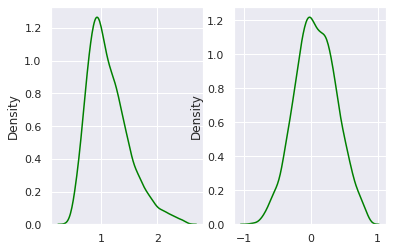

In [25]:
fig, ax = pl.subplots(1, 2)
sns.distplot(eeg[eeg['Response'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [26]:
eeg[eeg['Response'] != 'No Response']['stdRT'] = fitted_data

In [27]:
print(fitted_lambda)
print('Shapiro test:', shapiro(fitted_data))
print('Other normal test:', normaltest(fitted_data))

-0.14836812286618403
Shapiro test: ShapiroResult(statistic=0.9975175857543945, pvalue=8.745944057864108e-08)
Other normal test: NormaltestResult(statistic=39.477175381694096, pvalue=2.6769501589031745e-09)


In [87]:
# exclude CorrPercentage column as we don't need it
eeg = eeg.loc[:, eeg.columns != 'CorrPercentage']

'No Response' trials are coded as incorrect in the data already, so we don't need to recode this.

## Accuracy plots EEG dataset

BOTH MATCH AND MISMATCH: all conditions, W vs NW, H vs L

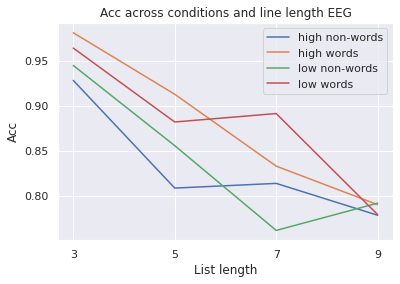

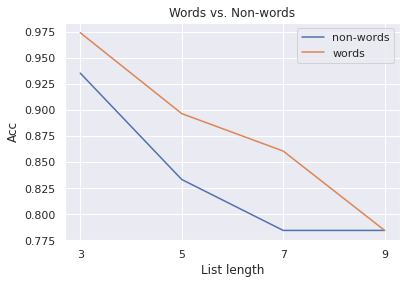

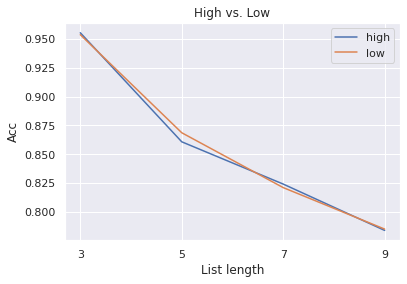

In [90]:
pl.figure()
subset = eeg.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG');

pl.figure()
subset = eeg.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = eeg.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low');

ONLY MATCH: all cond's, W vs NW, H vs L

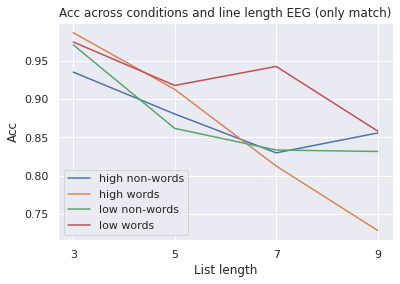

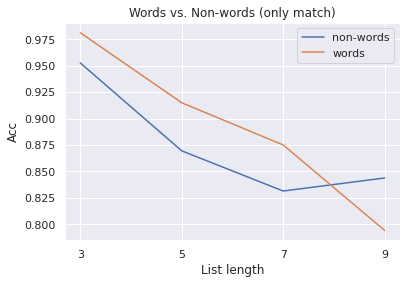

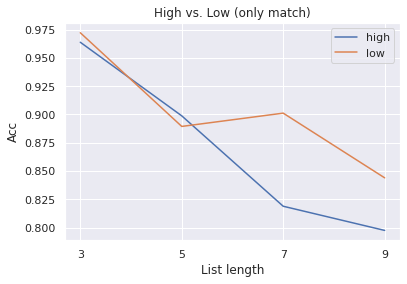

In [91]:
only_match = eeg[eeg['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match)');

ONLY MISMATCH: all cond's, W vs NW, H vs L

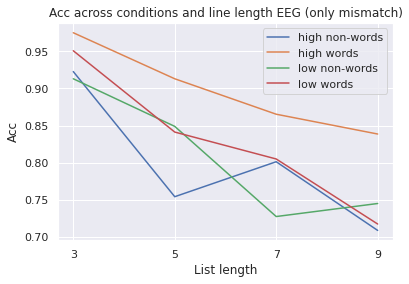

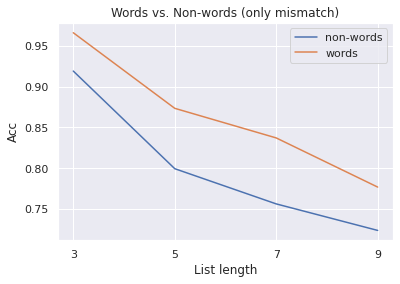

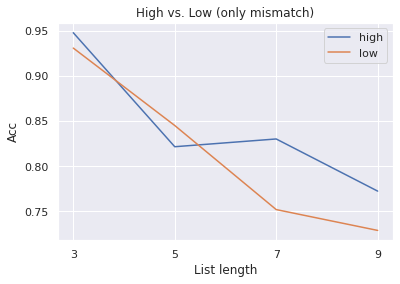

In [92]:
only_mismatch = eeg[eeg['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch)');

Plotting match vs mismatch on the same plot

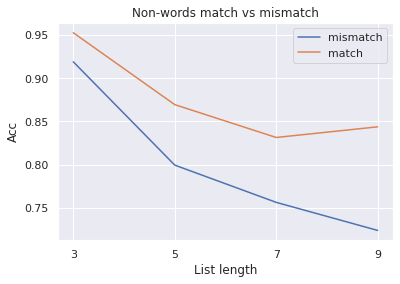

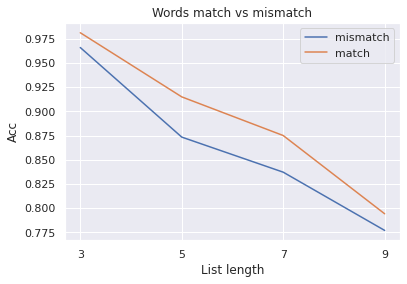

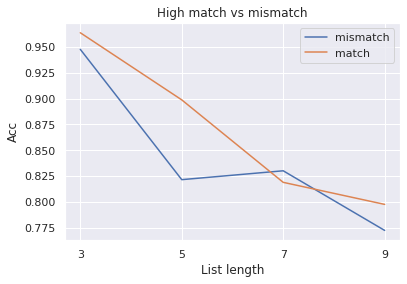

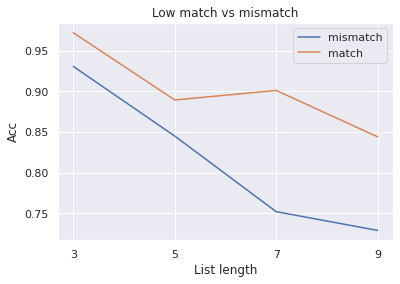

In [93]:
pl.figure()
nonwords = eeg[eeg['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = eeg[eeg['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = eeg[eeg['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = eeg[eeg['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch');

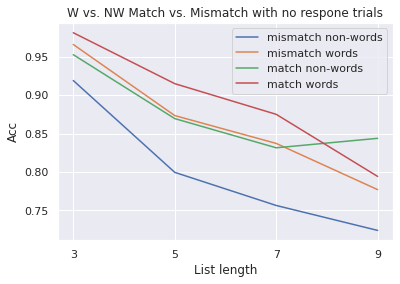

In [94]:
pl.figure()
subset = eeg.groupby(['ProbeType', 'Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Lex.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Lex'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('W vs. NW Match vs. Mismatch with no respone trials');

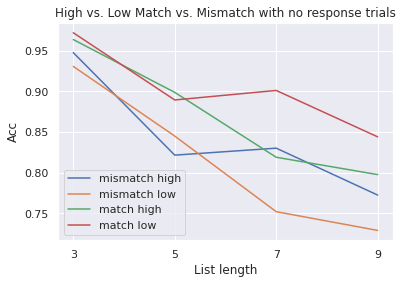

In [95]:
pl.figure()
subset = eeg.groupby(['ProbeType', 'Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Phono.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Phono'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low Match vs. Mismatch with no response trials');

## Accuracy bar plots. Phono effect

**Bar plots. Investigating the effect of phono within the lexical class, probe types and list lengths**

P-value 0.5316825626173953
H 0.859538784067086 L 0.8536585365853658


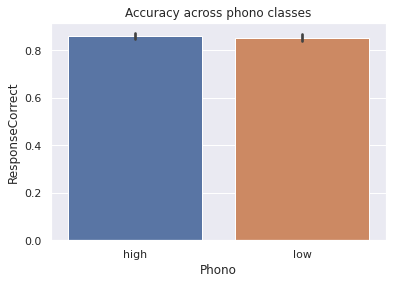

In [96]:
# W vs NW
pl.figure()
fig = sns.barplot('Phono', 'ResponseCorrect', data=eeg)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy across phono classes');

x, y = eeg[eeg['Phono'] == 1]['ResponseCorrect'].values, eeg[eeg['Phono'] == 0]['ResponseCorrect'].values
print('P-value', ttest(x, y)[1])
print('H', y.mean(), 'L', x.mean())

P-value for words 0.44278844346806834
H 0.8834818368745716 L 0.8739622641509434
P-value for non-words 0.9738591114388171
H 0.83464005702067 L 0.834178131788559


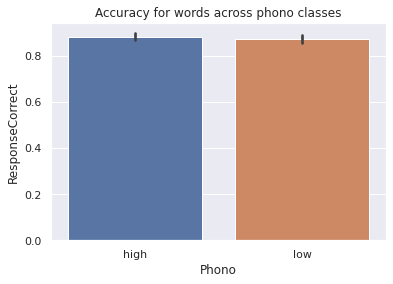

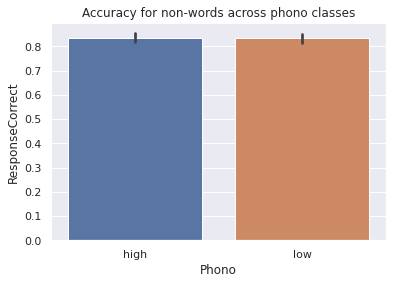

In [97]:
# W H vs L, NW H vs L
for i in eeg.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.figure()
  subset = eeg[eeg['Lex'] == i]
  fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy for ' + name + ' across phono classes');

  x, y = subset[subset['Phono'] == 1]['ResponseCorrect'].values, subset[subset['Phono'] == 0]['ResponseCorrect'].values
  print('P-value for', name, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

P-value for words mismatch 1.5166039627061359e-05
H 0.9002976190476191 L 0.8156606851549756
P-value for words match 0.0004311710100043424
H 0.8691232528589581 L 0.9241573033707865
P-value for non-words match 0.962461830830121
H 0.8769968051118211 L 0.8761329305135952
P-value for non-words mismatch 0.8112853308894151
H 0.8005148005148005 L 0.7955493741307371


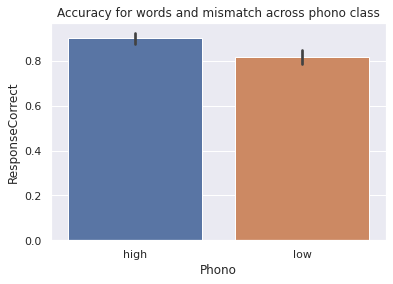

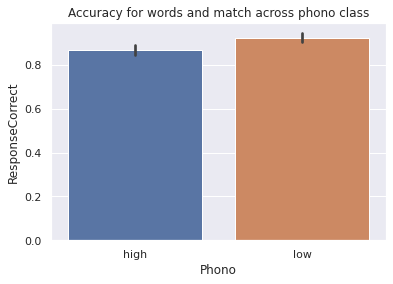

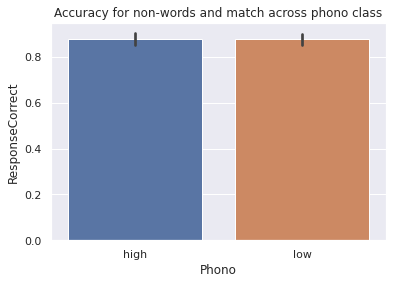

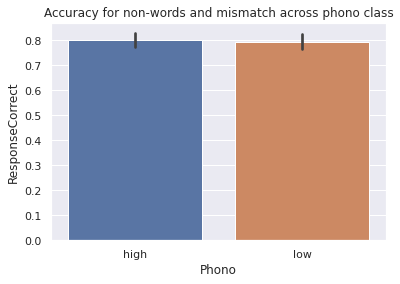

In [98]:
# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for lex_class in eeg.Lex.unique():
  if lex_class == 0:
    name1 = 'non-words'
  elif lex_class == 1:
    name1 = 'words'
  subset = eeg[eeg['Lex'] == lex_class]
  for probe_class in subset.ProbeType.unique():
    if probe_class == 1:
      name2 = 'mismatch'
    elif probe_class == 2:
      name2 = 'match'
    ss = subset[subset['ProbeType'] == probe_class]

    pl.figure()
    fig = sns.barplot('Phono', 'ResponseCorrect', data=ss)
    fig.set_xticklabels(['high', 'low'])
    pl.title(
        'Accuracy for ' + name1 + ' and ' + name2 + ' across phono class'
    );

    x, y = ss[ss['Phono'] == 1]['ResponseCorrect'].values, ss[ss['Phono'] == 0]['ResponseCorrect'].values
    print('P-value for', name1, name2, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

P-value for 5 0.669127290144013
H 0.8608169440242057 L 0.8686730506155951
P-value for 9 0.9587743791831324
H 0.7839335180055401 L 0.7850746268656716
P-value for 7 0.881330293755935
H 0.8241430700447094 L 0.8210818307905686
P-value for 3 0.8822641922794177
H 0.9554455445544554 L 0.9537671232876712


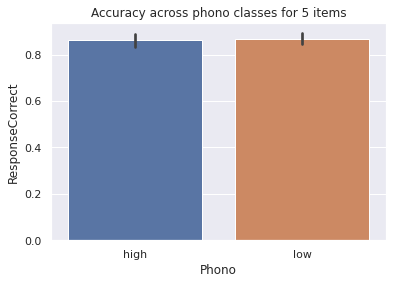

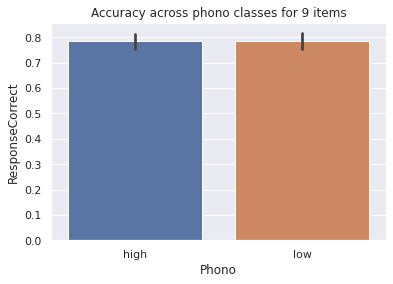

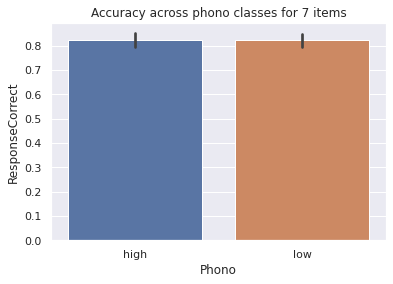

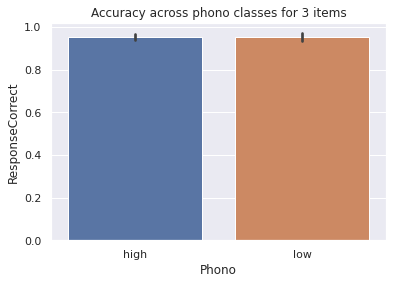

In [99]:
# check for different length
# H vs L
for i in eeg.Length.unique():
  subset = eeg[eeg['Length'] == i] 
  pl.figure()
  fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy across phono classes for ' + str(i) + ' items');

  x, y = subset[subset['Phono'] == 1]['ResponseCorrect'].values, subset[subset['Phono'] == 0]['ResponseCorrect'].values
  print('P-value for', i, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

In [100]:
# check for different length
for i in eeg.Length.unique():
  print(i)
  subset = eeg[eeg['Length'] == i]
  for j in subset.Lex.unique():
    if j == 0:
      print('Non-words')
    elif j == 1:
      print('Words')
    ss = subset[subset['Lex'] == j]
    x, y = ss[ss['Phono'] == 1]['ResponseCorrect'].values, ss[ss['Phono'] == 0]['ResponseCorrect'].values
    print('P-value for', i, j, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

5
Words
P-value for 5 1 0.18073421371691437
H 0.9126506024096386 L 0.8818681318681318
Non-words
P-value for 5 0 0.09850954116207628
H 0.8085106382978723 L 0.8555858310626703
9
Words
P-value for 9 1 0.7233783601234173
H 0.7900874635568513 L 0.7790368271954674
Non-words
P-value for 9 0 0.6676557002085628
H 0.7783641160949868 L 0.7917981072555205
7
Non-words
P-value for 7 0 0.09322299740974167
H 0.8137254901960784 L 0.7615384615384615
Words
P-value for 7 1 0.025118604447534543
H 0.8328767123287671 L 0.8912386706948641
3
Words
P-value for 3 1 0.1938727396430131
H 0.9809069212410502 L 0.9638989169675091
Non-words
P-value for 3 0 0.3703312713403578
H 0.9280205655526992 L 0.9446254071661238


In [101]:
# check for different length

# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for i in eeg.Length.unique():
  subset = eeg[eeg['Length'] == i]
  for lex_class in subset.Lex.unique():
    if lex_class == 0:
      name1 = 'non-words'
    elif lex_class == 1:
      name1 = 'words'
    ss = subset[subset['Lex'] == lex_class]
    for probe_class in subset.ProbeType.unique():
      if probe_class == 1:
        name2 = 'mismatch'
      elif probe_class == 2:
        name2 = 'match'
      s = ss[ss['ProbeType'] == probe_class]

      x, y = s[s['Phono'] == 1]['ResponseCorrect'].values, s[s['Phono'] == 0]['ResponseCorrect'].values
      print('P-value for', i, 'items', name1, name2, ttest(x, y)[1])
      print('H', y.mean(), 'L', x.mean())
      print('')

P-value for 5 items words mismatch 0.053104684640026115
H 0.9130434782608695 L 0.8411764705882353

P-value for 5 items words match 0.8560492865850269
H 0.9123711340206185 L 0.9175257731958762

P-value for 5 items non-words mismatch 0.023909409904301588
H 0.7540106951871658 L 0.8488372093023255

P-value for 5 items non-words match 0.6119393952526393
H 0.8802816901408451 L 0.8615384615384616

P-value for 9 items words match 0.005117451575330486
H 0.7284768211920529 L 0.8580645161290322

P-value for 9 items words mismatch 0.003817820192223341
H 0.8385416666666666 L 0.7171717171717171

P-value for 9 items non-words match 0.5345383742718991
H 0.8555555555555555 L 0.8313953488372093

P-value for 9 items non-words mismatch 0.45593988618298853
H 0.7085427135678392 L 0.7448275862068966

P-value for 7 items non-words mismatch 0.07312242339368806
H 0.8011695906432749 L 0.7272727272727273

P-value for 7 items non-words match 0.9366313571969674
H 0.8296296296296296 L 0.8333333333333334

P-value for

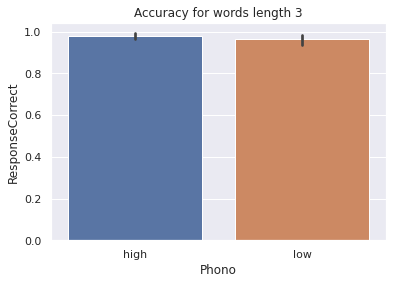

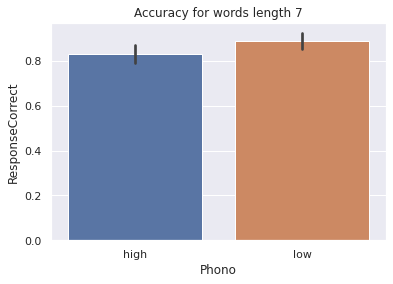

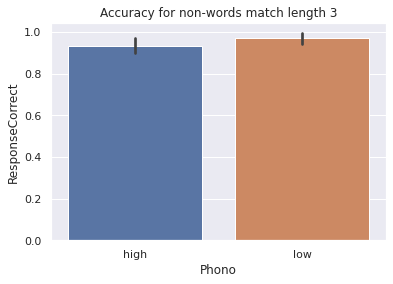

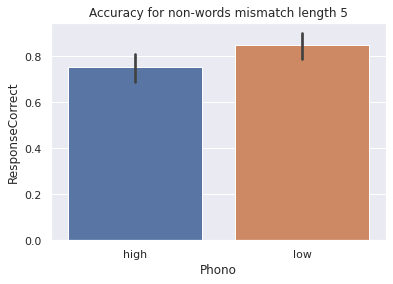

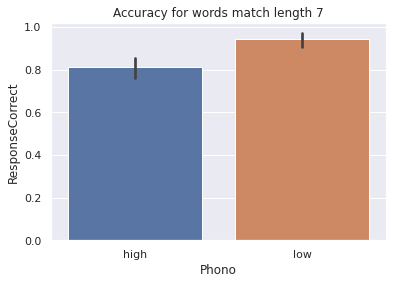

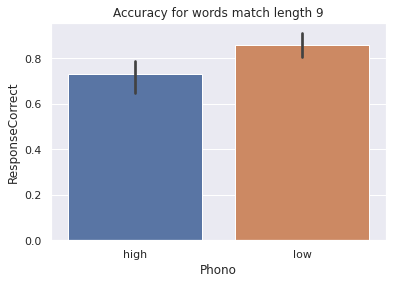

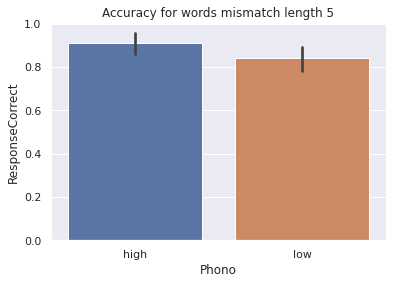

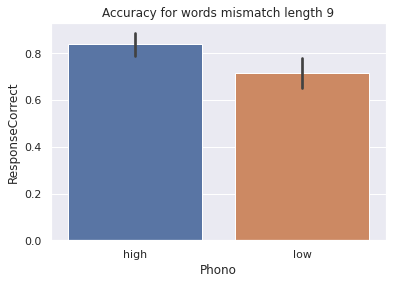

In [102]:
# plotting sgnificant differences by lists
# first contrast Phono within word classes
pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 3)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words length 3');

pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 7)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words length 7');

pl.figure()
subset = eeg[(eeg['Lex'] == 0) & (eeg['Length'] == 3) & (eeg['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for non-words match length 3');

pl.figure()
subset = eeg[(eeg['Lex'] == 0) & (eeg['Length'] == 5) & (eeg['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for non-words mismatch length 5');

pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 7) & (eeg['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words match length 7');

pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 9) & (eeg['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words match length 9');

pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 5) & (eeg['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words mismatch length 5');

pl.figure()
subset = eeg[(eeg['Lex'] == 1) & (eeg['Length'] == 9) & (eeg['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words mismatch length 9');

## RT plots 

For RT analysis, we should exclude 'No response' trials, because they do not contain relevant information on the speed of the partcipants. There is 100 'No Response' trials.

In [107]:
eeg_rt = eeg[eeg['Response'] != 'No Response']

Both MATCH AND MISMATCH TOGETHER

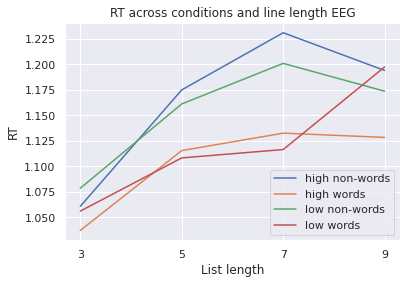

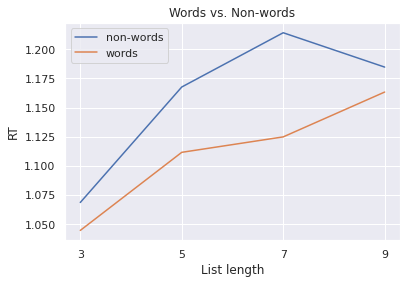

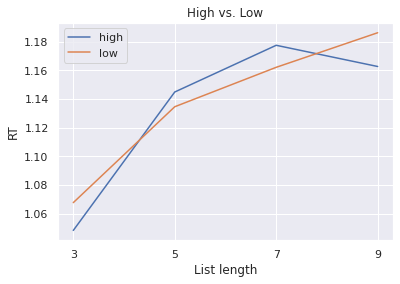

In [103]:
pl.figure()
subset = eeg.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG');

pl.figure()
subset = eeg.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = eeg.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low');

P-value nan
P-value nan


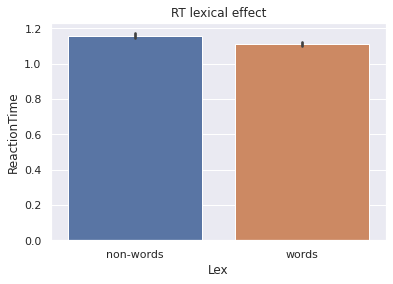

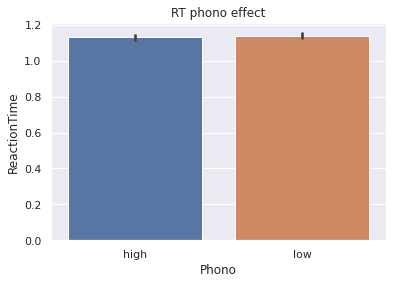

In [104]:
# significance with length combined
x, y = eeg[eeg['Lex'] == 1]['ReactionTime'].values, eeg[eeg['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(eeg['Lex'], eeg['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect');

x, y = eeg[eeg['Phono'] == 1]['ReactionTime'].values, eeg[eeg['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(eeg['Phono'], eeg['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect');

In [ ]:
# significance with different lengths
for i in eeg_no_trials.Length.unique():
  subset = eeg_no_trials[eeg_no_trials['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['stdRT'].values, subset[subset['Lex'] == 0]['stdRT'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['stdRT'].values, subset[subset['Phono'] == 0]['stdRT'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

P-value for 5 Lex 0.001684111459313631
P-value for 5 Phono 0.8552777920036453
P-value for 9 Lex 0.14557635220037574
P-value for 9 Phono 0.34146812300324747
P-value for 7 Lex 8.967064687324003e-06
P-value for 7 Phono 0.326465565593158
P-value for 3 Lex 0.16509226428520277
P-value for 3 Phono 0.18652238320551412


MATCH

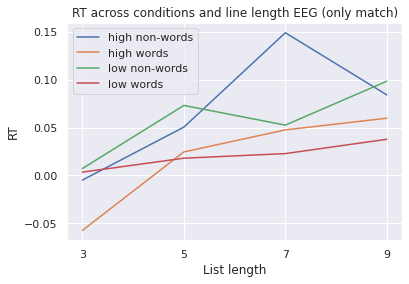

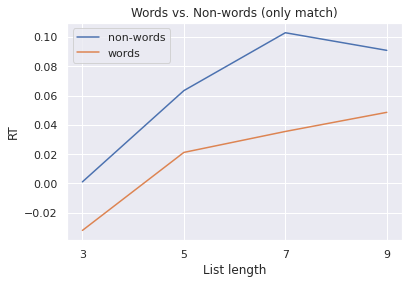

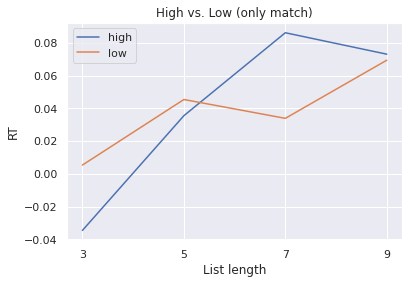

In [ ]:
only_match = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.stdRT, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.stdRT, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only match)');

P-value 4.8708856503101755e-05
P-value 0.9485878735155175


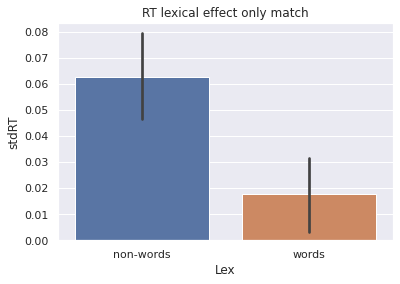

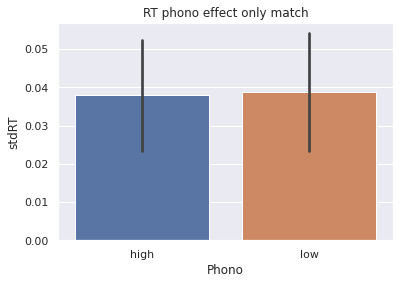

In [ ]:
# significance with length combined
x, y = only_match[only_match['Lex'] == 1]['stdRT'].values, only_match[only_match['Lex'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Lex'], only_match['stdRT'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only match');

x, y = only_match[only_match['Phono'] == 1]['stdRT'].values, only_match[only_match['Phono'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Phono'], only_match['stdRT'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only match');

In [ ]:
# significance with different lengths
print('Only match')
for i in only_match.Length.unique():
  subset = only_match[only_match['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Only match
P-value for 5 Lex 0.09840065941468577
P-value for 5 Phono 0.6182171504596798
P-value for 9 Lex 0.1429818414366755
P-value for 9 Phono 0.7808570910120656
P-value for 7 Lex 0.002579023196615695
P-value for 7 Phono 0.013577813637014612
P-value for 3 Lex 0.12871467484789983
P-value for 3 Phono 0.065869266611883


MISMATCH

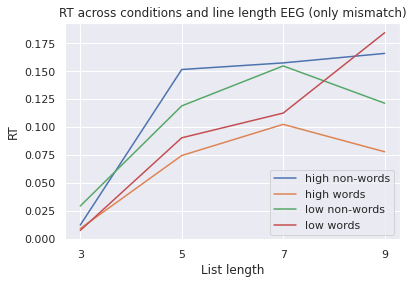

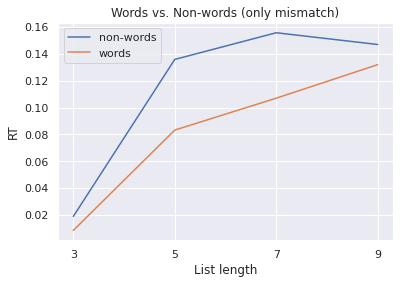

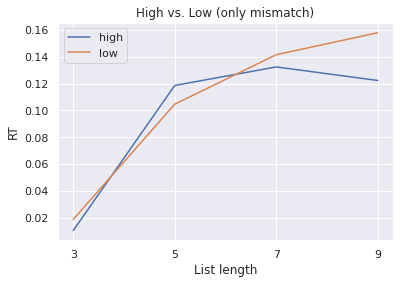

In [ ]:
only_mismatch = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only mismatch)');

P-value 0.00890771002819684
P-value 0.09143489374483048


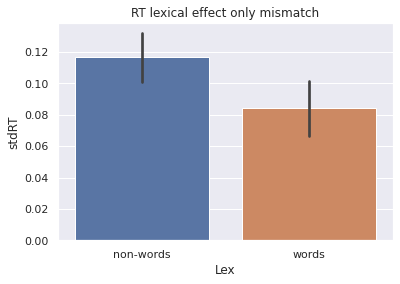

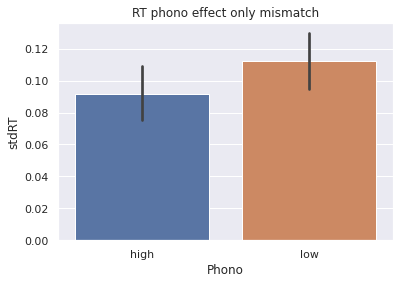

In [ ]:
# significance with length combined
x, y = only_mismatch[only_mismatch['Lex'] == 1]['stdRT'].values, only_mismatch[only_mismatch['Lex'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Lex'], only_mismatch['stdRT'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only mismatch');

x, y = only_mismatch[only_mismatch['Phono'] == 1]['stdRT'].values, only_mismatch[only_mismatch['Phono'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Phono'], only_mismatch['stdRT'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only mismatch');

In [ ]:
# significance with different lengths
print('Only mismatch')
for i in only_mismatch.Length.unique():
  subset = only_mismatch[only_mismatch['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['stdRT'].values, subset[subset['Lex'] == 0]['stdRT'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['stdRT'].values, subset[subset['Phono'] == 0]['stdRT'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Only mismatch
P-value for 7 Lex 0.05648525745390866
P-value for 7 Phono 0.7095998890678595
P-value for 3 Lex 0.6863774360342121
P-value for 3 Phono 0.7526388315396604
P-value for 5 Lex 0.03667730915905563
P-value for 5 Phono 0.580257954239514
P-value for 9 Lex 0.5113263612656771
P-value for 9 Phono 0.12096637475539572


Plotting MATCH AND MISMATCH on the same plot

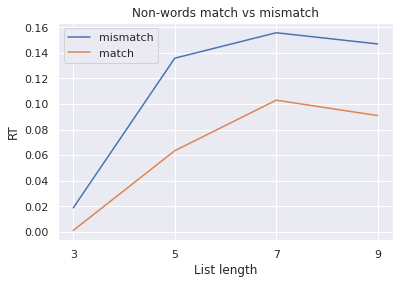

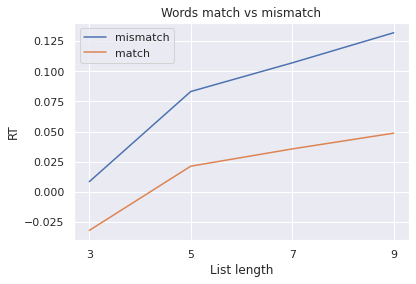

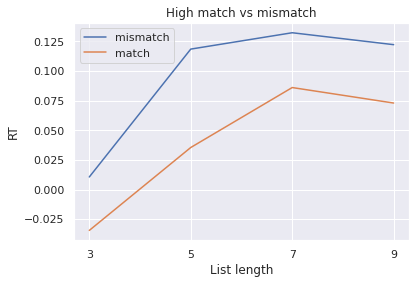

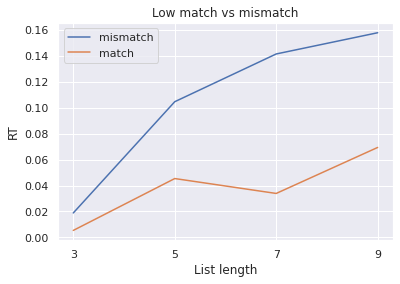

In [ ]:
pl.figure()
nonwords = eeg_no_trials[eeg_no_trials['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = eeg_no_trials[eeg_no_trials['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = eeg_no_trials[eeg_no_trials['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = eeg_no_trials[eeg_no_trials['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Low match vs mismatch');

P-value 3.6075384132519335e-06
P-value 2.857921914637853e-08
P-value 4.444494880469032e-06
P-value 6.980197347388574e-10


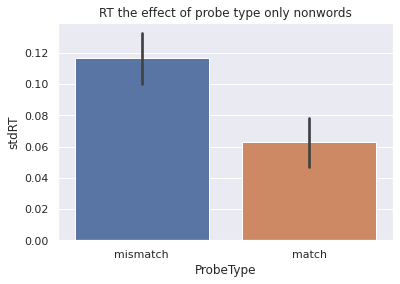

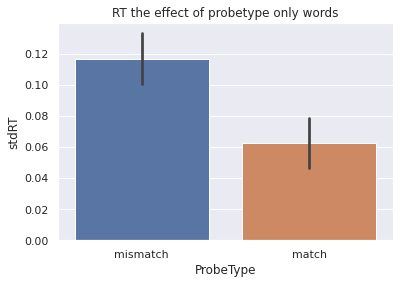

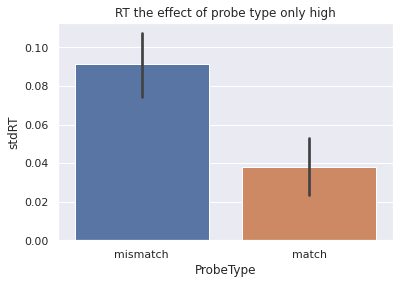

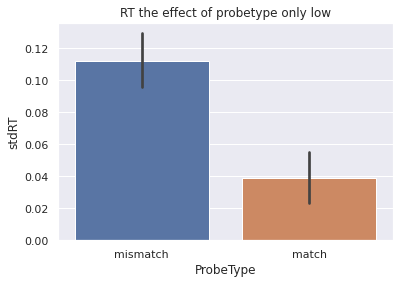

In [ ]:
# significance with length combined
ss = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = ss[ss['ProbeType'] == 2]['stdRT'].values, ss[ss['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ss['ProbeType'], ss['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probe type only nonwords');

s = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = s[s['ProbeType'] == 2]['stdRT'].values, s[s['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ss['ProbeType'], ss['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probetype only words');

hh = eeg_no_trials[eeg_no_trials['Phono'] == 0]
x, y = hh[hh['ProbeType'] == 2]['stdRT'].values, hh[hh['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(hh['ProbeType'], hh['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probe type only high');

h = eeg_no_trials[eeg_no_trials['Phono'] == 1]
x, y = h[h['ProbeType'] == 2]['stdRT'].values, h[h['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(h['ProbeType'], h['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probetype only low');

In [ ]:
# significance with different lengths
print('Only nonwords')
for i in ss.Length.unique():
  subset = ss[ss['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only words')
for i in s.Length.unique():
  subset = s[s['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only high')
for i in hh.Length.unique():
  subset = hh[hh['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only low')
for i in h.Length.unique():
  subset = h[h['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])


Only nonwords
P-value for 5 ProbeType 0.0004579403129675825
P-value for 7 ProbeType 0.020236559303487976
P-value for 9 ProbeType 0.0021998555731681225
P-value for 3 ProbeType 0.2498785964856283
Only words
P-value for 9 ProbeType 0.00019899137531289183
P-value for 5 ProbeType 0.0040608091397785935
P-value for 3 ProbeType 0.02361578132640961
P-value for 7 ProbeType 0.0006661437262981638
Only high
P-value for 5 ProbeType 9.35829048091703e-05
P-value for 7 ProbeType 0.038460407594205714
P-value for 9 ProbeType 0.003956365295362419
P-value for 3 ProbeType 0.007057305633010442
Only low
P-value for 5 ProbeType 0.006704053808696551
P-value for 9 ProbeType 0.00012303713587609702
P-value for 3 ProbeType 0.4408141849345105
P-value for 7 ProbeType 2.2521272407039423e-07


In [ ]:
eeg_no_trials.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
       'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
       'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx',
       'CorrPercentage', 'Position', 'Length', 'stdRT', 'Lex', 'Phono'],
      dtype='object')

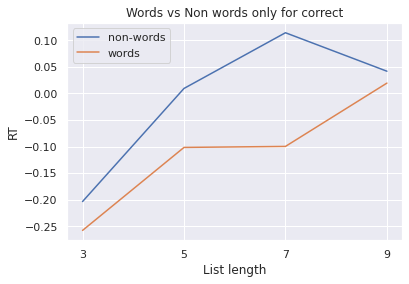

In [ ]:
# CORRECT
pl.figure()
correct = eeg_no_trials[eeg_no_trials['ResponseCorrect'] == 1]
subset = correct.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  x = subset[subset['Lex'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs Non words only for correct');

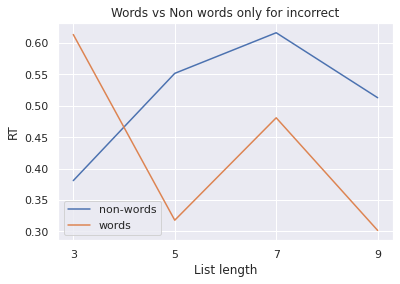

In [ ]:
# INCORRECT
pl.figure()
incorrect = eeg_no_trials[eeg_no_trials['ResponseCorrect'] == 0]
subset = incorrect.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  x = subset[subset['Lex'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs Non words only for incorrect');

## Correlation

In [ ]:
eeg_data = eeg[[
                'Trial', 'Subject', 'Block',
                'ProbeType', 'stdRT', 'ResponseCorrect',
                'Position', 'Response', 'Length', 'Lex', 'Phono'
]]

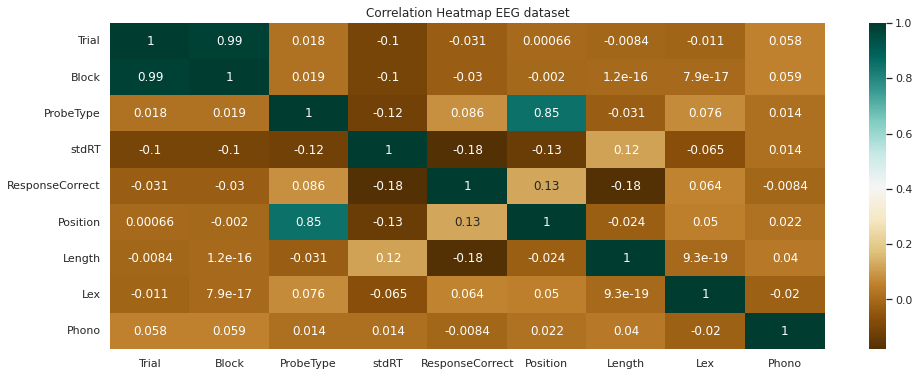

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap EEG dataset');

## Models Accuracy

In [ ]:
%%R -i eeg_no_trials
m <- lmer('ResponseCorrect ~ Length + Lex + ProbeType + Lex:ProbeType + (1|Subject)', data=eeg_no_trials)
m1 <- lmer('ResponseCorrect ~ Length + Lex + ProbeType + Lex:ProbeType + Length:ProbeType + (1|Subject)', data=eeg_no_trials)
anova(m, m1)

R[write to console]: refitting model(s) with ML (instead of REML)



  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 3236.919 3283.166 -1611.460 3222.919       NA NA         NA
2    8 3234.366 3287.219 -1609.183 3218.366 4.553551  1 0.03285056


In [ ]:
mod = Lmer(
    'ResponseCorrect ~ Length + Lex + ProbeType + Lex:ProbeType + (1|Subject)',
    data = eeg_no_trials
)
mod.fit()

Formula: ResponseCorrect~Length+Lex+ProbeType+Lex:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1631.410 	 AIC: 3262.820

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.105  0.324

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       0.925   0.879    0.972  0.024  1467.434  38.939  0.000  ***
Length           -0.028  -0.032   -0.025  0.002  5435.257 -14.509  0.000  ***
Lex               0.101   0.047    0.156  0.028  5436.075   3.633  0.000  ***
ProbeType         0.067   0.043    0.091  0.012  5439.201   5.385  0.000  ***
Lex:ProbeType    -0.044  -0.078   -0.009  0.018  5436.306  -2.489  0.013    *

In [ ]:
mod1 = Lmer(
    'ResponseCorrect ~ Length + Lex + ProbeType + Lex:ProbeType + Length:ProbeType + (1|Subject)',
    data = eeg_no_trials
)
mod1.fit()

Formula: ResponseCorrect~Length+Lex+ProbeType+Lex:ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1633.759 	 AIC: 3267.518

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.105  0.324

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.001   0.917    1.084  0.043  4475.598  23.507  0.000   
Length              -0.041  -0.053   -0.029  0.006  5443.383  -6.616  0.000   
Lex                  0.102   0.047    0.156  0.028  5435.123   3.649  0.000   
ProbeType            0.017  -0.035    0.069  0.027  5441.132   0.630  0.529   
Lex:ProbeType       -0.044  -0.078   -0.009  0.018  5435.324  -2.492  0.013   
Length:ProbeType     0.008   0.001    0.016  0.004  5443.889   2.132  0.033   

                  Sig  
(Intercept)       ***  
Length            ***  
Lex               ***  
ProbeType              
Lex:ProbeType       *  
Length:ProbeType    *

**Model with Words vs Non Words**

In [ ]:
words_eeg = eeg_no_trials[eeg_no_trials['Lex'] == 1]
nonwords_eeg = eeg_no_trials[eeg_no_trials['Lex'] == 0]

In [ ]:
# for words
%%R -i words_eeg
m <- lmer('ResponseCorrect ~ ProbeType + Length + (1|Subject)', data=words_eeg)
m1 <- lmer('ResponseCorrect ~ ProbeType + Length + Phono:ProbeType + (1|Subject)', data=words_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    5 1233.343 1262.928 -611.6713 1223.343       NA NA         NA
2    6 1232.601 1268.104 -610.3006 1220.601 2.741446  1 0.09777624


In [ ]:
model1 = Lmer(
    'ResponseCorrect ~ Length + ProbeType + (1|Subject)',
    data=words_eeg
)
model1.fit()

Formula: ResponseCorrect~Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2744	 Groups: {'Subject': 29.0}

Log-likelihood: -624.136 	 AIC: 1248.272

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.091  0.301

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.039   0.989    1.089  0.026  1428.800  40.641  0.000  ***
Length         -0.030  -0.035   -0.025  0.003  2713.361 -11.745  0.000  ***
ProbeType       0.022  -0.000    0.045  0.012  2716.398   1.940  0.052    .

In [ ]:
# for nonwords
%%R -i nonwords_eeg
m <- lmer('ResponseCorrect ~ ProbeType + Length + (1|Subject)', data=nonwords_eeg)
m1 <- lmer('ResponseCorrect ~ Length + ProbeType + Length:ProbeType + (1|Subject)', data=nonwords_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance   Chisq Df Pr..Chisq.
1    5 1958.466 1988.015 -974.2331 1948.466      NA NA         NA
2    6 1952.761 1988.220 -970.3805 1940.761 7.70516  1 0.00550632


In [ ]:
model2 = Lmer(
    'ResponseCorrect ~ Length + ProbeType + Length:ProbeType + (1|Subject)',
    data=nonwords_eeg
)
model2.fit()

Formula: ResponseCorrect~Length+ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2724	 Groups: {'Subject': 29.0}

Log-likelihood: -986.461 	 AIC: 1972.922

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.051
Residual               0.118  0.344

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.061   0.943    1.179  0.060  2536.390  17.574  0.000   
Length              -0.051  -0.069   -0.033  0.009  2698.838  -5.494  0.000   
ProbeType           -0.031  -0.105    0.043  0.038  2697.047  -0.822  0.411   
Length:ProbeType     0.016   0.005    0.028  0.006  2699.357   2.775  0.006   

                  Sig  
(Intercept)       ***  
Length            ***  
ProbeType              
Length:ProbeType   **

**Model with Match vs. mismatch**

In [ ]:
match_eeg = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
mismatch_eeg = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]

In [ ]:
# MATCH
%%R -i match_eeg
m <- lmer('ResponseCorrect ~ Length + Phono + Lex + Lex:Length + Length:Phono + (1|Subject)', data=match_eeg)
m1 <- lmer('ResponseCorrect ~ Length + Phono + Lex + Lex:Length + Length:Phono + Length:Phono:Lex + (1|Subject)', data=match_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    8 1096.340 1143.704 -540.1700 1080.340       NA NA         NA
2    9 1089.053 1142.337 -535.5266 1071.053 9.286744  1 0.00230818


In [ ]:
model_mis = Lmer(
    'ResponseCorrect ~ Length + Phono + Lex + Lex:Length + Length:Phono + Length:Phono:Lex + (1|Subject)',
    data=match_eeg
)
model_mis.fit()

Formula: ResponseCorrect~Length+Phono+Lex+Lex:Length+Length:Phono+Length:Phono:Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2753	 Groups: {'Subject': 29.0}

Log-likelihood: -564.767 	 AIC: 1129.534

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.055
Residual               0.085  0.292

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.022   0.964    1.080  0.030   898.805  34.273  0.000   
Length              -0.022  -0.031   -0.014  0.004  2721.782  -5.086  0.000   
Phono               -0.044  -0.107    0.018  0.032  2718.959  -1.392  0.164   
Lex                  0.086   0.023    0.148  0.032  2718.813   2.684  0.007   
Length:Lex          -0.017  -0.028   -0.007  0.005  2719.276  -3.256  0.001   
Length:Phono         0.008  -0.002    0.018  0.005  2719.844   1.496  0.135   
Length:Phono:Lex     0.011   0.004    0.018  0.004  2720.218   3.045  0.002   

                  Sig  
(Intercept)       ***  
Length            ***  
Phono                  
Lex                **  
Length:Lex         **  
Length:Phono           
Length:Phono:Lex   **

In [ ]:
model_ = Lmer(
    'ResponseCorrect ~ Length + Phono + Length:Phono + (1|Subject)',
    data=match_eeg
)
model_.fit()

Formula: ResponseCorrect~Length+Phono+Length:Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2753	 Groups: {'Subject': 29.0}

Log-likelihood: -560.425 	 AIC: 1120.850

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.086  0.293

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      1.066   1.018    1.113  0.024   461.588  43.852  0.000  ***
Length          -0.031  -0.038   -0.024  0.003  2725.111  -8.963  0.000  ***
Phono           -0.047  -0.109    0.016  0.032  2722.117  -1.461  0.144     
Length:Phono     0.014   0.004    0.024  0.005  2721.959   2.738  0.006   **

In [ ]:
# for MISMATCH
# MATCH
%%R -i mismatch_eeg
m <- lmer('ResponseCorrect ~ Lex + Length + Phono + Lex:Phono + (1|Subject)', data=mismatch_eeg)
m1 <- lmer('ResponseCorrect ~ Lex + Length + Phono + Lex:Phono + Length:Lex:Phono + (1|Subject)', data=mismatch_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    7 1950.043 1991.388 -968.0213 1936.043        NA NA         NA
2    8 1951.313 1998.565 -967.6564 1935.313 0.7296901  1  0.3929837


In [ ]:
model_mis = Lmer(
    'ResponseCorrect ~ Lex + Length + Phono + Lex:Phono + (1|Subject)',
    data=mismatch_eeg
)
model_mis.fit()

Formula: ResponseCorrect~Lex+Length+Phono+Lex:Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2715	 Groups: {'Subject': 29.0}

Log-likelihood: -985.709 	 AIC: 1971.418

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.077
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.016   0.966    1.066  0.026   192.528  39.456  0.000  ***
Lex             0.089   0.053    0.125  0.018  2683.382   4.872  0.000  ***
Length         -0.032  -0.038   -0.027  0.003  2685.730 -10.993  0.000  ***
Phono          -0.004  -0.039    0.031  0.018  2682.984  -0.233  0.816     
Lex:Phono      -0.065  -0.117   -0.013  0.026  2684.288  -2.459  0.014    *

In [ ]:
model_mis1 = Lmer(
    'ResponseCorrect ~ Lex + Length + Phono + (1|Subject)',
    data=mismatch_eeg
)
model_mis1.fit()

Formula: ResponseCorrect~Lex+Length+Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2715	 Groups: {'Subject': 29.0}

Log-likelihood: -986.016 	 AIC: 1972.032

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.077
Residual               0.118  0.343

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.031   0.982    1.080  0.025   173.012  41.181  0.000  ***
Lex             0.058   0.032    0.084  0.013  2683.356   4.387  0.000  ***
Length         -0.032  -0.038   -0.027  0.003  2686.740 -11.004  0.000  ***
Phono          -0.034  -0.060   -0.008  0.013  2683.078  -2.600  0.009   **

**Plots that are significant**

All conditions

1.8330335255535514e-08


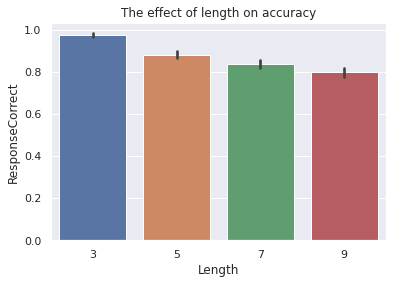

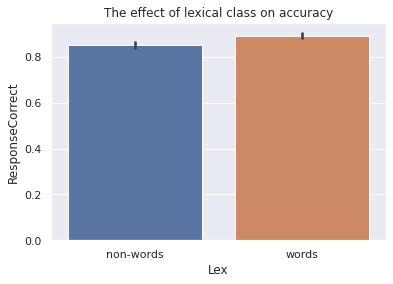

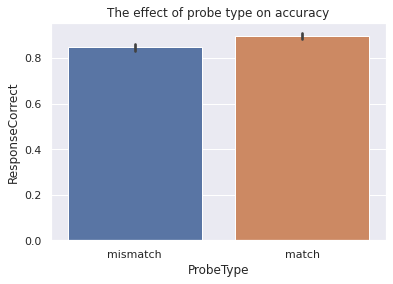

In [ ]:
pl.figure()
sns.barplot('Length', 'ResponseCorrect', data=eeg_no_trials)
pl.title('The effect of length on accuracy');

pl.figure()
fig = sns.barplot('Lex', 'ResponseCorrect', data=eeg_no_trials)
fig.set_xticklabels(['non-words', 'words'])
pl.title('The effect of lexical class on accuracy');

pl.figure()
fig = sns.barplot('ProbeType', 'ResponseCorrect', data=eeg_no_trials)
fig.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe type on accuracy');
x, y = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]['ResponseCorrect'].values, eeg_no_trials[eeg_no_trials['ProbeType'] == 2]['ResponseCorrect'].values
print(ttest(x,y)[1])

In [ ]:
# significance for NW M vs MM 
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['ProbeType'] == 2][['ResponseCorrect']].values, subset[subset['ProbeType'] == 1][['ResponseCorrect']].values
print(ttest(x, y))

# significance for W M vs MM
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['ProbeType'] == 2][['ResponseCorrect']].values, subset[subset['ProbeType'] == 1][['ResponseCorrect']].values
print(ttest(x, y))

# significance for M W vs NW
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
print(ttest(x, y))

# significance for MM W vs NW
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
print(ttest(x, y))

Ttest_indResult(statistic=array([5.06943309]), pvalue=array([4.25867878e-07]))
Ttest_indResult(statistic=array([2.38538455]), pvalue=array([0.01713396]))
Ttest_indResult(statistic=array([-1.3682156]), pvalue=array([0.1713619]))
Ttest_indResult(statistic=array([-4.02867251]), pvalue=array([5.76336463e-05]))


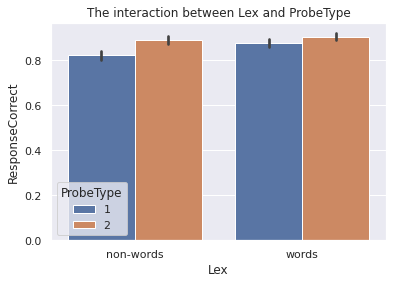

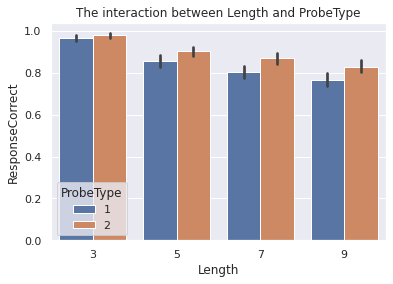

In [ ]:
pl.figure()
ax = sns.barplot(x="Lex", y="ResponseCorrect", hue="ProbeType", data=eeg_no_trials)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The interaction between Lex and ProbeType');

pl.figure()
ax = sns.barplot(x="Length", y="ResponseCorrect", hue="ProbeType", data=eeg_no_trials)
pl.title('The interaction between Length and ProbeType');

Words vs. nonwords

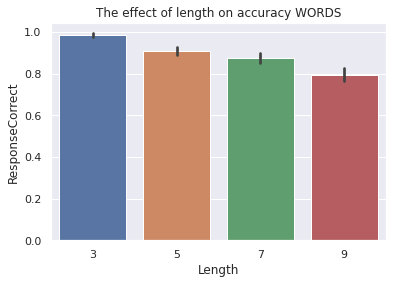

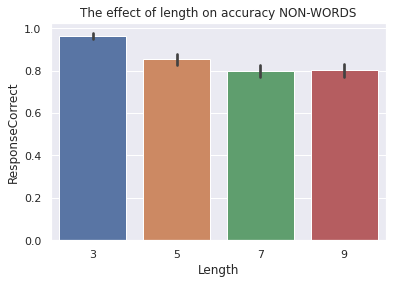

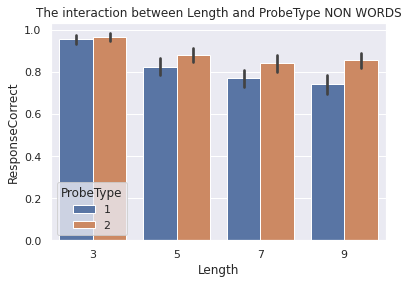

In [ ]:
pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['Lex'] == 1]['Length'],
    eeg_no_trials.ResponseCorrect
)
pl.title('The effect of length on accuracy WORDS')

pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['Lex'] == 0]['Length'],
    eeg_no_trials.ResponseCorrect
)
pl.title('The effect of length on accuracy NON-WORDS')

pl.figure()
ax = sns.barplot(
    x="Length", y="ResponseCorrect", hue="ProbeType", data=eeg_no_trials[eeg_no_trials['Lex'] == 0]
    )
pl.title('The interaction between Length and ProbeType NON WORDS');

MATCH VS MISMATCH

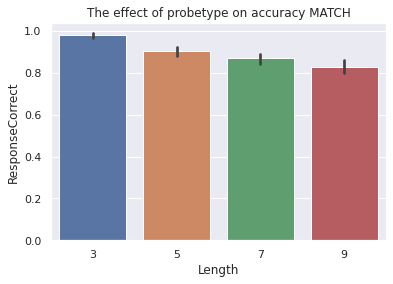

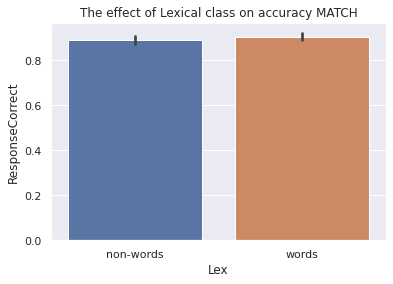

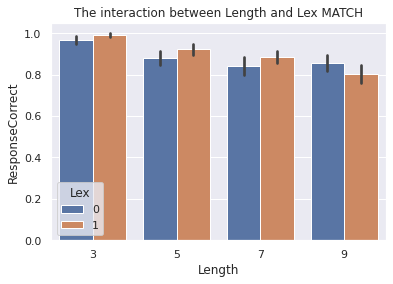

<Figure size 432x288 with 0 Axes>

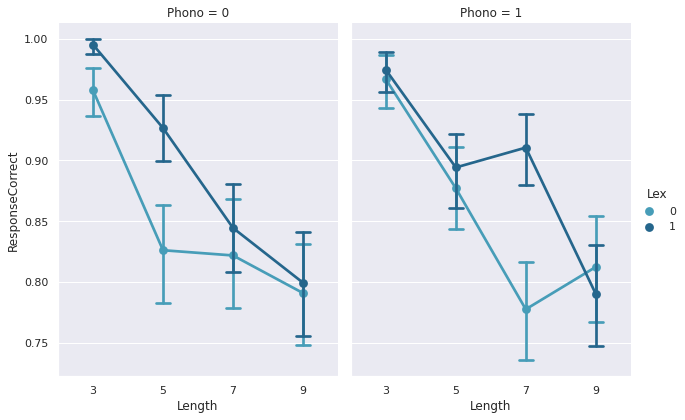

In [ ]:
pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['ProbeType'] == 2]['Length'],
    eeg_no_trials.ResponseCorrect
)
pl.title('The effect of probetype on accuracy MATCH')

pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['ProbeType'] == 2]['Lex'],
    eeg_no_trials.ResponseCorrect
)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The effect of Lexical class on accuracy MATCH')

pl.figure()
ax = sns.barplot(
    x="Length", y="ResponseCorrect", hue="Lex", 
    data=eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
    )
pl.title('The interaction between Length and Lex MATCH');

pl.figure()
g = sns.catplot(x="Length", y="ResponseCorrect", hue="Lex", col="Phono",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=eeg_no_trials);

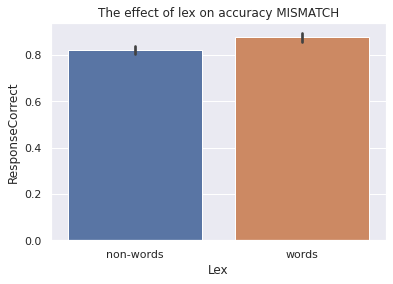

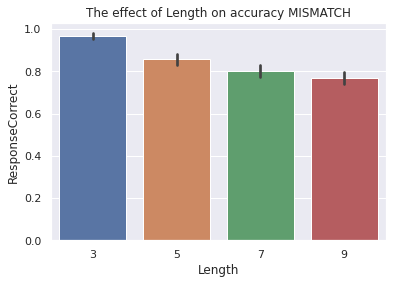

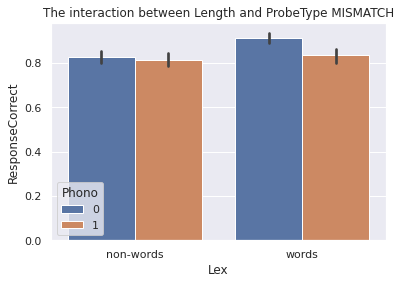

In [ ]:
pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['ProbeType'] == 1]['Lex'],
    eeg_no_trials.ResponseCorrect
)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The effect of lex on accuracy MISMATCH')

pl.figure()
ax = sns.barplot(
    eeg_no_trials[eeg_no_trials['ProbeType'] == 1]['Length'],
    eeg_no_trials.ResponseCorrect
)
pl.title('The effect of Length on accuracy MISMATCH')

pl.figure()
ax = sns.barplot(
    x="Lex", y="ResponseCorrect", hue="Phono", data=eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
    )
ax.set_xticklabels(['non-words', 'words'])
pl.title('The interaction between Length and ProbeType MISMATCH');

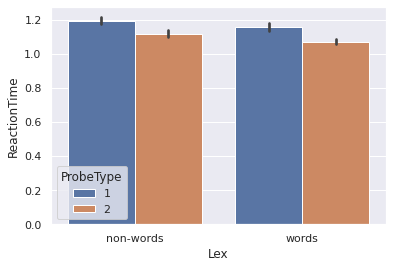

In [ ]:
pl.figure()
ax = sns.barplot(
    x="Lex", y="ReactionTime", hue="ProbeType", data=eeg_no_trials
    )
ax.set_xticklabels(['non-words', 'words']);

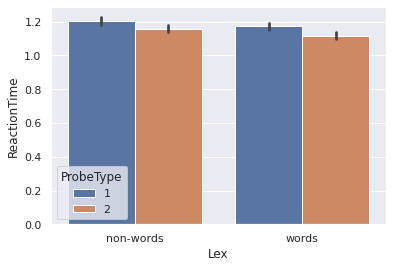

In [ ]:
pl.figure()
ax = sns.barplot(
    x="Lex", y="ReactionTime", hue="ProbeType", data=ieeg_no_outliers
    )
ax.set_xticklabels(['non-words', 'words']);

## Models RT

In [ ]:
%%R -i eeg_no_trials
m <- lmer('stdRT ~ Length + Lex + ProbeType + Length:ProbeType + (1|Subject)', data=eeg_no_trials)
m1 <- lmer('stdRT ~ Length + Lex + ProbeType + Length:ProbeType + Lex:Length:ProbeType + (1|Subject)', data=eeg_no_trials)
anova(m, m1)

  npar       AIC       BIC   logLik  deviance     Chisq Df Pr..Chisq.
1    7 -122.6959 -76.44922 68.34795 -136.6959        NA NA         NA
2    8 -121.0108 -68.15746 68.50540 -137.0108 0.3149049  1  0.5746858


In [ ]:
mod = Lmer(
    'stdRT ~ Lex + Length + ProbeType + Length:ProbeType + (1|Subject)',
    data=eeg_no_trials
)
mod.fit()

Formula: stdRT~Lex+Length+ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: 47.108 	 AIC: -94.216

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.038  0.195
Residual               0.056  0.236

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.022  -0.070    0.113  0.047    74.741   0.463  0.645   
Lex                 -0.039  -0.052   -0.026  0.006  5435.004  -6.092  0.000   
Length               0.028   0.019    0.037  0.005  5435.283   6.150  0.000   
ProbeType           -0.022  -0.058    0.014  0.018  5435.280  -1.177  0.239   
Length:ProbeType    -0.007  -0.013   -0.002  0.003  5435.301  -2.499  0.012   

                  Sig  
(Intercept)            
Lex               ***  
Length            ***  
ProbeType              
Length:ProbeType    *

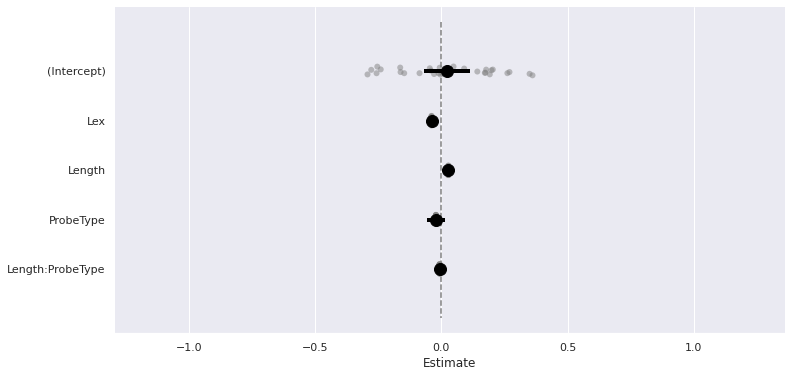

In [ ]:
mod.plot_summary()

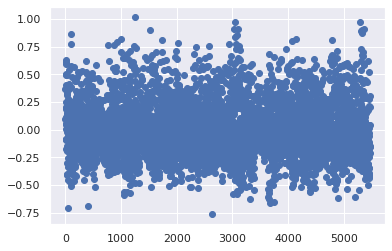

In [ ]:
plot(mod.residuals, 'o');

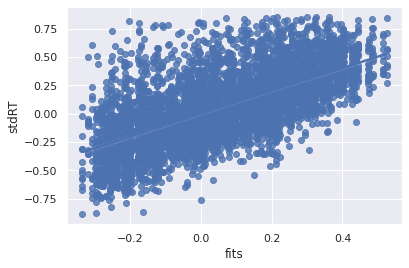

In [ ]:
sns.regplot(x="fits", y="stdRT", data=mod.data, fit_reg=True)

In [ ]:
mod1 = Lmer(
    'stdRT ~ Lex + Length + ProbeType + (1|Subject)',
    data=eeg_no_trials
)
mod1.fit()

Formula: stdRT~Lex+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -6612.471 	 AIC: 13224.942

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.346  0.589
Residual               0.639  0.800

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.118  -0.114    0.351  0.119    38.242   0.998  0.325     
Lex            -0.114  -0.156   -0.071  0.022  5436.003  -5.250  0.000  ***
Length          0.051   0.041    0.060  0.005  5436.003  10.448  0.000  ***
ProbeType      -0.238  -0.280   -0.195  0.022  5436.174 -10.955  0.000  ***

**Words vs. Nonwords**

Words

In [ ]:
%%R -i words_eeg
m <- lmer('stdRT ~ ProbeType + Phono + Length + Phono:ProbeType + (1|Subject)', data=words_eeg)
m1 <- lmer('stdRT ~ ProbeType + Phono + Length + Phono:ProbeType + Length:ProbeType:Phono + (1|Subject)', data=words_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    7 6518.177 6559.597 -3252.089 6504.177        NA NA         NA
2    8 6519.748 6567.085 -3251.874 6503.748 0.4295147  1  0.5122272


In [ ]:
m1 = Lmer(
    'stdRT ~ ProbeType + Phono + Length + Phono:ProbeType + (1|Subject)',
    data=words_eeg
)
m1.fit()

Formula: stdRT~ProbeType+Phono+Length+Phono:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2744	 Groups: {'Subject': 29.0}

Log-likelihood: -3264.553 	 AIC: 6529.106

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.365  0.604
Residual               0.601  0.775

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)        -0.112  -0.379    0.156  0.137    59.346  -0.817  0.417   
ProbeType          -0.167  -0.247   -0.086  0.041  2711.180  -4.055  0.000   
Phono               0.310   0.121    0.499  0.096  2711.205   3.218  0.001   
Length              0.048   0.035    0.061  0.007  2711.009   7.170  0.000   
ProbeType:Phono    -0.168  -0.285   -0.051  0.060  2711.240  -2.824  0.005   

                 Sig  
(Intercept)           
ProbeType        ***  
Phono             **  
Length           ***  
ProbeType:Phono   **

Non-words

In [ ]:
%%R -i nonwords_eeg
m <- lmer('stdRT ~ ProbeType + Length + (1|Subject)', data=nonwords_eeg)
m1 <- lmer('stdRT ~ ProbeType + Length + Length:Phono + (1|Subject)', data=nonwords_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    5 6768.614 6798.164 -3379.307 6758.614        NA NA         NA
2    6 6770.163 6805.622 -3379.081 6758.163 0.4519444  1   0.501413


In [ ]:
m2 = Lmer(
    'stdRT ~ ProbeType + Length + (1|Subject)',
    data=nonwords_eeg
)
m2.fit()

Formula: stdRT~ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2724	 Groups: {'Subject': 29.0}

Log-likelihood: -3387.197 	 AIC: 6774.393

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.332  0.577
Residual               0.673  0.820

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.092  -0.153    0.337  0.125    50.184   0.735  0.466     
ProbeType      -0.228  -0.290   -0.166  0.032  2693.319  -7.235  0.000  ***
Length          0.053   0.039    0.066  0.007  2693.021   7.474  0.000  ***

**Match vs Mismatch**

Match

In [ ]:
%%R -i match_eeg
m <- lmer('stdRT ~ Length + Lex + (1|Subject)', data=match_eeg)
m1 <- lmer('stdRT ~ Length + Lex + Lex:Phono + (1|Subject)', data=match_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    5 6307.114 6336.717 -3148.557 6297.114        NA NA         NA
2    6 6308.904 6344.426 -3148.452 6296.904 0.2107477  1   0.646182


In [ ]:
mod1 = Lmer(
    'stdRT ~ Length + Lex + (1|Subject)',
    data=match_eeg
)
mod1.fit()

Formula: stdRT~Length+Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2753	 Groups: {'Subject': 29.0}

Log-likelihood: -3156.739 	 AIC: 6313.477

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.274  0.524
Residual               0.554  0.744

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.285  -0.494   -0.076  0.107    38.679  -2.676  0.011    *
Length          0.039   0.026    0.052  0.006  2722.368   6.093  0.000  ***
Lex            -0.122  -0.178   -0.066  0.028  2722.052  -4.285  0.000  ***

Mismatch

In [ ]:
%%R -i mismatch_eeg
m <- lmer('stdRT ~ Lex + Length + Phono + Phono:Lex + (1|Subject)', data=mismatch_eeg)
m1 <- lmer('stdRT ~ Lex + Length + Phono + Phono:Lex + Length:Lex:Phono + (1|Subject)', data=mismatch_eeg)
anova(m, m1)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 6873.366 6914.712 -3429.683 6859.366       NA NA         NA
2    8 6872.332 6919.584 -3428.166 6856.332 3.034366  1 0.08151837


In [ ]:
mod2 = Lmer(
    'stdRT ~ Lex + Length + Phono + Phono:Lex + (1|Subject)',
    data=mismatch_eeg
)
mod2.fit()

Formula: stdRT~Lex+Length+Phono+Phono:Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2715	 Groups: {'Subject': 29.0}

Log-likelihood: -3441.724 	 AIC: 6883.447

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.446  0.668
Residual               0.702  0.838

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.174  -0.438    0.090  0.135    37.549  -1.292  0.204     
Lex            -0.199  -0.287   -0.111  0.045  2682.123  -4.450  0.000  ***
Length          0.063   0.049    0.077  0.007  2682.357   8.824  0.000  ***
Phono          -0.046  -0.133    0.040  0.044  2682.083  -1.050  0.294     
Lex:Phono       0.185   0.058    0.311  0.065  2682.213   2.855  0.004   **

In [ ]:
mod2 = Lmer(
    'stdRT ~ Lex + Length + (1|Subject)',
    data=mismatch_eeg
)
mod2.fit()

Formula: stdRT~Lex+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2715	 Groups: {'Subject': 29.0}

Log-likelihood: -3442.203 	 AIC: 6884.407

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.444  0.666
Residual               0.704  0.839

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.201  -0.461    0.060  0.133    36.023  -1.509  0.140     
Lex            -0.111  -0.174   -0.048  0.032  2684.023  -3.433  0.001  ***
Length          0.064   0.050    0.078  0.007  2684.361   8.931  0.000  ***

**Significant plots**




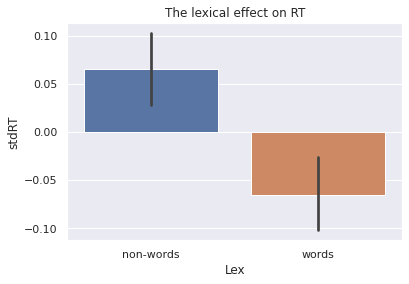

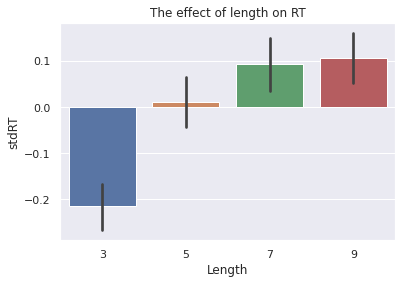

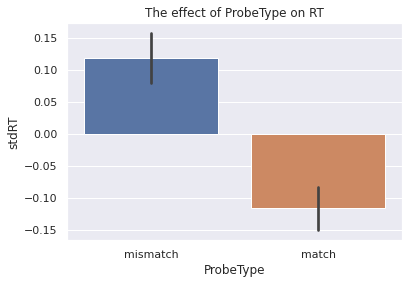

In [ ]:
pl.figure()
ax = sns.barplot(
    eeg_no_trials['Lex'], eeg_no_trials['stdRT']
)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The lexical effect on RT');

pl.figure()
ax = sns.barplot(
    eeg_no_trials['Length'], eeg_no_trials['stdRT']
)
pl.title('The effect of length on RT');

pl.figure()
ax = sns.barplot(
    eeg_no_trials['ProbeType'], eeg_no_trials['stdRT']
)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of ProbeType on RT');

In [ ]:
x, y = eeg_no_trials[eeg_no_trials['ProbeType'] == 1][['ReactionTime']].values, eeg_no_trials[eeg_no_trials['ProbeType'] == 2][['ReactionTime']].values
ttest(x,y)

Ttest_indResult(statistic=array([8.68823194]), pvalue=array([4.83702072e-18]))

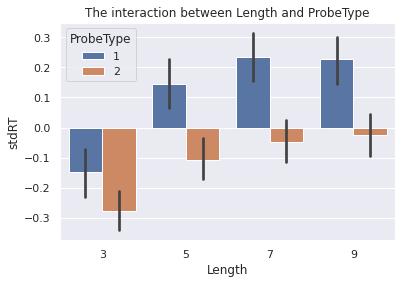

In [ ]:
pl.figure()
ax = sns.barplot(x="Length", y="stdRT", hue="ProbeType", data=eeg_no_trials)
pl.title('The interaction between Length and ProbeType');

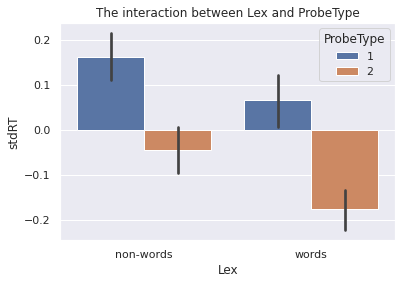

In [ ]:
pl.figure()
ax = sns.barplot(x="Lex", y="stdRT", hue="ProbeType", data=eeg_no_trials)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The interaction between Lex and ProbeType');

In [ ]:
# for W M vs MM
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['ProbeType'] == 2][['stdRT']].values, subset[subset['ProbeType'] == 1][['stdRT']].values
print(ttest(x, y))

# for NW M vs MM
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['ProbeType'] == 2][['stdRT']].values, subset[subset['ProbeType'] == 1][['stdRT']].values
print(ttest(x, y))

# for M W vs NW
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x, y))

# for MM W vs NW
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x, y))

Ttest_indResult(statistic=array([-6.38133126]), pvalue=array([2.08842774e-10]))
Ttest_indResult(statistic=array([-5.43919407]), pvalue=array([5.82810847e-08]))
Ttest_indResult(statistic=array([3.79326601]), pvalue=array([0.00015197]))
Ttest_indResult(statistic=array([2.33145509]), pvalue=array([0.01980365]))


## Position in EEG

We have the following division in the 'Position' column: for 3 - 1/1/1. For 5, 2/1/2, For 7, 2/3/2. For 9, 3/3/3. Here we add to the other columns other divisions to ensure that the effects we see are not just because of data devision specifics.

**Creating new position divisions**

In [ ]:
position = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]

In [ ]:
# making values in df more 'handy'
whole_list = eeg_no_trials['StimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  new_sound_idx.append(
      [int(s) for s in re.findall(r'\b\d+\b', i)]
  )

In [ ]:
alt_positions1 = [] # for the new column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_no_trials['ProbeSound_idx'].values
in_out = eeg_no_trials['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions1.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          alt_positions1.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          alt_positions1.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions1.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [1, 2, 3]:
          alt_positions1.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 4:
          alt_positions1.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          alt_positions1.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 3:
          alt_positions1.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [4, 5, 6]:
          alt_positions1.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          alt_positions1.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          alt_positions1.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          alt_positions1.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    alt_positions1.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [ ]:
# disregarding all the positions except when it's from the very first place, middle or last
alt_positions2 = [] # for the new column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_no_trials['ProbeSound_idx'].values
in_out = eeg_no_trials['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions2.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          alt_positions2.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          alt_positions2.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions2.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          alt_positions2.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 4:
          alt_positions2.append(3) # end
        elif new_sound_idx[i].index(ind[i]) in [1, 3]:
          alt_positions2.append(0)

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions2.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 3:
          alt_positions2.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 6:
          alt_positions2.append(3) # end
        elif new_sound_idx[i].index(ind[i]) in [1, 2, 4, 5]:
          alt_positions2.append(0)
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) == 0:
          alt_positions2.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 4:
          alt_positions2.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 8:
          alt_positions2.append(3) # end
        elif new_sound_idx[i].index(ind[i]) in [1, 2, 3, 5, 6, 7]:
          alt_positions2.append(0)
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    alt_positions2.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [ ]:
eeg_no_trials['Position1'] = alt_positions1
eeg_no_trials['Position2'] = alt_positions2

**Accuracy for position 1**

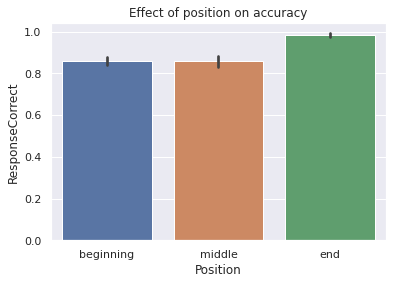

In [ ]:
pl.figure()
fig = sns.barplot(position['Position'], position['ResponseCorrect'])
fig.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Effect of position on accuracy');

In [ ]:
print('Ttest for position 1 vs 2')
x, y = position[position['Position'] == 1][['ResponseCorrect']].values, position[position['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3')
x, y = position[position['Position'] == 2][['ResponseCorrect']].values, position[position['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3')
x, y = position[position['Position'] == 1][['ResponseCorrect']].values, position[position['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

Ttest for position 1 vs 2
Ttest_indResult(statistic=array([0.03041106]), pvalue=array([0.97574252]))
Ttest for position 2 vs 3
Ttest_indResult(statistic=array([-9.90658794]), pvalue=array([3.31257476e-22]))
Ttest for position 1 vs 3
Ttest_indResult(statistic=array([-10.8051565]), pvalue=array([3.50286931e-26]))


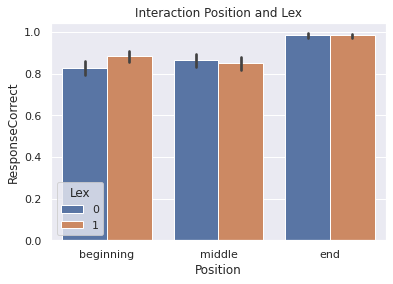

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ResponseCorrect', hue = 'Lex',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Lex');

In [ ]:
print('WORDS')
print('Ttest for position 1 vs 2 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 3][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

print('NON WORDS')
print('Ttest for position 1 vs 2 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 3][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 W vs NW')
subset = position[position['Position'] == 1]
x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

print('Position 2 W vs NW')
subset = position[position['Position'] == 2]
x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

print('Position 3 W vs NW')
subset = position[position['Position'] == 3]
x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

WORDS
Ttest for position 1 vs 2 Words
Ttest_indResult(statistic=array([1.44912469]), pvalue=array([0.14767884]))
Ttest for position 2 vs 3 Words
Ttest_indResult(statistic=array([7.22845868]), pvalue=array([1.79314275e-12]))
Ttest for position 1 vs 3 Words
Ttest_indResult(statistic=array([-7.12523797]), pvalue=array([2.22974498e-12]))
NON WORDS
Ttest for position 1 vs 2 Non-Words
Ttest_indResult(statistic=array([-1.61787266]), pvalue=array([0.10605108]))
Ttest for position 2 vs 3 Non-Words
Ttest_indResult(statistic=array([6.76694931]), pvalue=array([3.25015221e-11]))
Ttest for position 1 vs 3 Non-Words
Ttest_indResult(statistic=array([-8.20451802]), pvalue=array([1.66072228e-15]))
POSITION
Position 1 W vs NW
Ttest_indResult(statistic=array([-2.48570482]), pvalue=array([0.01311996]))
Position 2 W vs NW
Ttest_indResult(statistic=array([0.65080014]), pvalue=array([0.51535131]))
Position 3 W vs NW
Ttest_indResult(statistic=array([-0.00403405]), pvalue=array([0.9967823]))


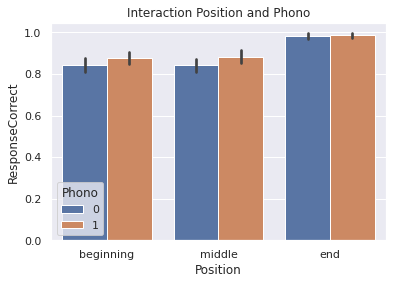

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ResponseCorrect', hue = 'Phono',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Phono');

In [ ]:
print('HIGH')
print('Ttest for position 1 vs 2 High')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 High')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 3][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 High')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

print('Low')
print('Ttest for position 1 vs 2 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 3][['ResponseCorrect']].values, subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['ResponseCorrect']].values, subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 H vs L')
subset = position[position['Position'] == 1]
x, y = subset[subset['Phono'] == 0][['ResponseCorrect']].values, subset[subset['Phono'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

print('Position 2 H vs L')
subset = position[position['Position'] == 2]
x, y = subset[subset['Phono'] == 0][['ResponseCorrect']].values, subset[subset['Phono'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

print('Position 3 H vs L')
subset = position[position['Position'] == 3]
x, y = subset[subset['Phono'] == 0][['ResponseCorrect']].values, subset[subset['Phono'] == 1][['ResponseCorrect']].values
print(ttest(x,y))

HIGH
Ttest for position 1 vs 2 High
Ttest_indResult(statistic=array([-0.04555779]), pvalue=array([0.96367155]))
Ttest for position 2 vs 3 High
Ttest_indResult(statistic=array([8.05202944]), pvalue=array([3.68572244e-15]))
Ttest for position 1 vs 3 High
Ttest_indResult(statistic=array([-8.11315525]), pvalue=array([2.31412544e-15]))
Low
Ttest for position 1 vs 2 Low
Ttest_indResult(statistic=array([-0.26948367]), pvalue=array([0.78763149]))
Ttest for position 2 vs 3 Low
Ttest_indResult(statistic=array([5.64128247]), pvalue=array([3.09930166e-08]))
Ttest for position 1 vs 3 Low
Ttest_indResult(statistic=array([-7.124529]), pvalue=array([2.58456024e-12]))
POSITION
Position 1 H vs L
Ttest_indResult(statistic=array([-1.53564916]), pvalue=array([0.12493015]))
Position 2 H vs L
Ttest_indResult(statistic=array([-1.60460912]), pvalue=array([0.108975]))
Position 3 H vs L
Ttest_indResult(statistic=array([-0.13505454]), pvalue=array([0.89260378]))


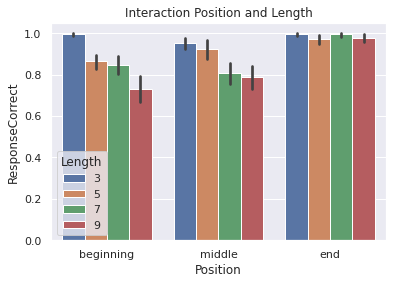

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ResponseCorrect', hue = 'Length',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Length');

In [ ]:
print('Beginning') 
subset = position[position['Position'] == 1]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 5][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ResponseCorrect']].values
y = subset[subset['Length'] == 9][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 3 vs 7')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))

Beginning
Length 3 vs 5
Ttest_indResult(statistic=array([7.37243854]), pvalue=array([8.12919033e-13]))
Length 5 vs 7
Ttest_indResult(statistic=array([0.6182236]), pvalue=array([0.53672999]))
Length 7 vs 9
Ttest_indResult(statistic=array([2.9580041]), pvalue=array([0.00327668]))
Length 3 vs 7
Ttest_indResult(statistic=array([6.20115804]), pvalue=array([2.31011712e-09]))


In [ ]:
print('Middle') 
subset = position[position['Position'] == 2]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 5][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ResponseCorrect']].values
y = subset[subset['Length'] == 9][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 3 vs 7')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))

Middle
Length 3 vs 5
Ttest_indResult(statistic=array([0.94410143]), pvalue=array([0.34627419]))
Length 5 vs 7
Ttest_indResult(statistic=array([3.40335157]), pvalue=array([0.00074908]))
Length 7 vs 9
Ttest_indResult(statistic=array([0.5158168]), pvalue=array([0.60622169]))
Length 3 vs 7
Ttest_indResult(statistic=array([5.15351931]), pvalue=array([3.91223428e-07]))


In [ ]:
print('End') 
subset = position[position['Position'] == 3]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 5][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ResponseCorrect']].values
y = subset[subset['Length'] == 9][['ResponseCorrect']].values
print(ttest(x,y))
print('Length 3 vs 7')
x = subset[subset['Length'] == 3][['ResponseCorrect']].values
y = subset[subset['Length'] == 7][['ResponseCorrect']].values
print(ttest(x,y))

End
Length 3 vs 5
Ttest_indResult(statistic=array([2.01638704]), pvalue=array([0.04483259]))
Length 5 vs 7
Ttest_indResult(statistic=array([-1.82929299]), pvalue=array([0.06841096]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.53144563]), pvalue=array([0.12666947]))
Length 3 vs 7
Ttest_indResult(statistic=array([0.20279215]), pvalue=array([0.83941447]))


In [ ]:
print('Length 3')
subset = position[position['Length'] == 3]
print('Beginning vs. middle')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Middle vs. end')
x = subset[subset['Position'] == 3][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Beginning vs. end')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y)[1])

print('')
print('Length 5')
subset = position[position['Length'] == 5]
print('Beginning vs. middle')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Middle vs. end')
x = subset[subset['Position'] == 3][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Beginning vs. end')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y)[1])

print('')
print('Length 7')
subset = position[position['Length'] == 7]
print('Beginning vs. middle')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Middle vs. end')
x = subset[subset['Position'] == 3][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Beginning vs. end')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y)[1])

print('')
print('Length 9')
subset = position[position['Length'] == 9]
print('Beginning vs. middle')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Middle vs. end')
x = subset[subset['Position'] == 3][['ResponseCorrect']].values
y = subset[subset['Position'] == 2][['ResponseCorrect']].values
print(ttest(x,y)[1])
print('Beginning vs. end')
x = subset[subset['Position'] == 1][['ResponseCorrect']].values
y = subset[subset['Position'] == 3][['ResponseCorrect']].values
print(ttest(x,y)[1])

Length 3
Beginning vs. middle
[0.00250206]
Middle vs. end
[0.00205954]
Beginning vs. end
[0.94103909]

Length 5
Beginning vs. middle
[0.0429056]
Middle vs. end
[0.09221007]
Beginning vs. end
[5.16035161e-07]

Length 7
Beginning vs. middle
[0.2682924]
Middle vs. end
[4.55793806e-13]
Beginning vs. end
[3.6327814e-09]

Length 9
Beginning vs. middle
[0.15336435]
Middle vs. end
[5.17246857e-10]
Beginning vs. end
[5.74900642e-13]


**Reaction Time**

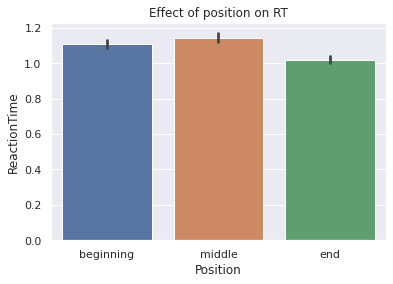

In [ ]:
pl.figure()
fig = sns.barplot(position['Position'], position['ReactionTime'])
fig.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Effect of position on RT');

In [ ]:
print('Position 1 vs 2')
x, y = position[position['Position'] == 1][['ReactionTime']].values, position[position['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))
print('Position 2 vs 3')
x, y = position[position['Position'] == 2][['ReactionTime']].values, position[position['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))
print('Position 1 vs 3')
x, y = position[position['Position'] == 1][['ReactionTime']].values, position[position['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))

Position 1 vs 2
Ttest_indResult(statistic=array([-2.25869328]), pvalue=array([0.02402044]))
Position 2 vs 3
Ttest_indResult(statistic=array([8.04580485]), pvalue=array([1.62717922e-15]))
Position 1 vs 3
Ttest_indResult(statistic=array([6.16018636]), pvalue=array([8.86071942e-10]))


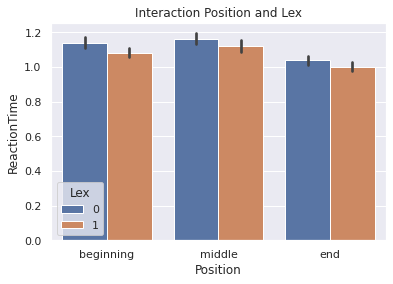

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ReactionTime', hue = 'Lex',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Lex');

In [ ]:
print('WORDS')
print('Ttest for position 1 vs 2 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 3][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Words')
subset = position[position['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))

print('NON WORDS')
print('Ttest for position 1 vs 2 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 3][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Non-Words')
subset = position[position['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 W vs NW')
subset = position[position['Position'] == 1]
x, y = subset[subset['Lex'] == 0][['ReactionTime']].values, subset[subset['Lex'] == 1][['ReactionTime']].values
print(ttest(x,y))

print('Position 2 W vs NW')
subset = position[position['Position'] == 2]
x, y = subset[subset['Lex'] == 0][['ReactionTime']].values, subset[subset['Lex'] == 1][['ReactionTime']].values
print(ttest(x,y))

print('Position 3 W vs NW')
subset = position[position['Position'] == 3]
x, y = subset[subset['Lex'] == 0][['ReactionTime']].values, subset[subset['Lex'] == 1][['ReactionTime']].values
print(ttest(x,y))

WORDS
Ttest for position 1 vs 2 Words
Ttest_indResult(statistic=array([-1.75511904]), pvalue=array([0.07959374]))
Ttest for position 2 vs 3 Words
Ttest_indResult(statistic=array([-5.4561435]), pvalue=array([6.46743178e-08]))
Ttest for position 1 vs 3 Words
Ttest_indResult(statistic=array([4.25742782]), pvalue=array([2.2568281e-05]))
NON WORDS
Ttest for position 1 vs 2 Non-Words
Ttest_indResult(statistic=array([-0.9778485]), pvalue=array([0.32841679]))
Ttest for position 2 vs 3 Non-Words
Ttest_indResult(statistic=array([-5.75319958]), pvalue=array([1.23729532e-08]))
Ttest for position 1 vs 3 Non-Words
Ttest_indResult(statistic=array([4.68067497]), pvalue=array([3.34774235e-06]))
POSITION
Position 1 W vs NW
Ttest_indResult(statistic=array([2.6596202]), pvalue=array([0.00795934]))
Position 2 W vs NW
Ttest_indResult(statistic=array([1.75254122]), pvalue=array([0.08003837]))
Position 3 W vs NW
Ttest_indResult(statistic=array([1.85549109]), pvalue=array([0.06388378]))


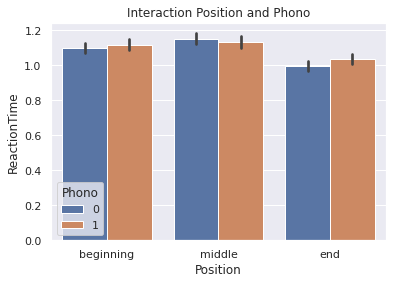

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ReactionTime', hue = 'Phono',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Phono');

In [ ]:
print('Low')
print('Ttest for position 1 vs 2 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 3][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Low')
subset = position[position['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))

print('High')
print('Ttest for position 1 vs 2 High')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Non-Words')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 3][['ReactionTime']].values, subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Non-Words')
subset = position[position['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['ReactionTime']].values, subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 H vs L')
subset = position[position['Position'] == 1]
x, y = subset[subset['Phono'] == 0][['ReactionTime']].values, subset[subset['Phono'] == 1][['ReactionTime']].values
print(ttest(x,y))

print('Position 2 H vs L')
subset = position[position['Position'] == 2]
x, y = subset[subset['Phono'] == 0][['ReactionTime']].values, subset[subset['Phono'] == 1][['ReactionTime']].values
print(ttest(x,y))

print('Position 3 H vs L')
subset = position[position['Position'] == 3]
x, y = subset[subset['Phono'] == 0][['ReactionTime']].values, subset[subset['Phono'] == 1][['ReactionTime']].values
print(ttest(x,y))

Low
Ttest for position 1 vs 2 Low
Ttest_indResult(statistic=array([-0.65763103]), pvalue=array([0.51097085]))
Ttest for position 2 vs 3 Low
Ttest_indResult(statistic=array([-4.31216313]), pvalue=array([1.85392937e-05]))
Ttest for position 1 vs 3 Low
Ttest_indResult(statistic=array([3.9800326]), pvalue=array([7.3883149e-05]))
High
Ttest for position 1 vs 2 High
Ttest_indResult(statistic=array([-2.48815536]), pvalue=array([0.01300015]))
Ttest for position 2 vs 3 Non-Words
Ttest_indResult(statistic=array([-7.15849303]), pvalue=array([1.72177264e-12]))
Ttest for position 1 vs 3 Non-Words
Ttest_indResult(statistic=array([4.94848367]), pvalue=array([8.99616477e-07]))
POSITION
Position 1 H vs L
Ttest_indResult(statistic=array([-0.92024582]), pvalue=array([0.35765503]))
Position 2 H vs L
Ttest_indResult(statistic=array([0.76584757]), pvalue=array([0.44399836]))
Position 3 H vs L
Ttest_indResult(statistic=array([-1.90821603]), pvalue=array([0.05671678]))


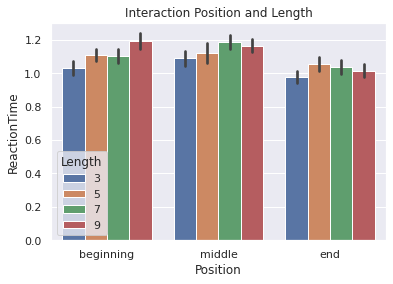

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'ReactionTime', hue = 'Length',
    data = position
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Length');

In [ ]:
print('Length 3')
subset = eeg_no_trials[eeg_no_trials['Length'] == 3]
print('Beginning vs middle')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1])
print('Middle vs end')
x = subset[subset['Position'] == 3][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1]) 
print('Beginning vs end')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 3][['ReactionTime']].values 
print(ttest(x,y)[1])

print('')
print('Length 5')
subset = eeg_no_trials[eeg_no_trials['Length'] == 5]
print('Beginning vs middle')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1])
print('Middle vs end')
x = subset[subset['Position'] == 3][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1]) 
print('Beginning vs end')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y)[1]) 

print('')
print('Length 7')
subset = eeg_no_trials[eeg_no_trials['Length'] == 7]
print('Beginning vs middle')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1])
print('Middle vs end')
x = subset[subset['Position'] == 3][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1]) 
print('Beginning vs end')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y)[1]) 

print('')
print('Length 9')
subset = eeg_no_trials[eeg_no_trials['Length'] == 9]
print('Beginning vs middle')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1])
print('Middle vs end')
x = subset[subset['Position'] == 3][['ReactionTime']].values 
y = subset[subset['Position'] == 2][['ReactionTime']].values
print(ttest(x,y)[1]) 
print('Beginning vs end')
x = subset[subset['Position'] == 1][['ReactionTime']].values 
y = subset[subset['Position'] == 3][['ReactionTime']].values
print(ttest(x,y)[1]) 

Length 3
Beginning vs middle
[0.05106824]
Middle vs end
[0.0001317]
Beginning vs end
[0.06862791]

Length 5
Beginning vs middle
[0.76766594]
Middle vs end
[0.07903414]
Beginning vs end
[0.04817346]

Length 7
Beginning vs middle
[0.00857184]
Middle vs end
[2.19842841e-06]
Beginning vs end
[0.02374432]

Length 9
Beginning vs middle
[0.39708653]
Middle vs end
[4.31891102e-07]
Beginning vs end
[3.25956409e-08]


In [ ]:
print('Beginning')
subset = eeg_no_trials[eeg_no_trials['Position'] == 1]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ReactionTime']].values 
y = subset[subset['Length'] == 5][['ReactionTime']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['ReactionTime']].values 
y = subset[subset['Length'] == 7][['ReactionTime']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ReactionTime']].values 
y = subset[subset['Length'] == 9][['ReactionTime']].values
print(ttest(x,y))

Beginning
Length 3 vs 5
Ttest_indResult(statistic=array([-2.84241754]), pvalue=array([0.00466048]))
Length 5 vs 7
Ttest_indResult(statistic=array([0.20984148]), pvalue=array([0.8338731]))
Length 7 vs 9
Ttest_indResult(statistic=array([-2.75474609]), pvalue=array([0.00612316]))


In [ ]:
print('Middle')
subset = eeg_no_trials[eeg_no_trials['Position'] == 2]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ReactionTime']].values 
y = subset[subset['Length'] == 5][['ReactionTime']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['ReactionTime']].values 
y = subset[subset['Length'] == 7][['ReactionTime']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ReactionTime']].values 
y = subset[subset['Length'] == 9][['ReactionTime']].values
print(ttest(x,y))

Middle
Length 3 vs 5
Ttest_indResult(statistic=array([-0.76179523]), pvalue=array([0.44690237]))
Length 5 vs 7
Ttest_indResult(statistic=array([-1.76338637]), pvalue=array([0.07900491]))
Length 7 vs 9
Ttest_indResult(statistic=array([0.69262418]), pvalue=array([0.48886895]))


In [ ]:
print('End')
subset = eeg_no_trials[eeg_no_trials['Position'] == 3]
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['ReactionTime']].values 
y = subset[subset['Length'] == 5][['ReactionTime']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 7][['ReactionTime']].values 
y = subset[subset['Length'] == 5][['ReactionTime']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['ReactionTime']].values 
y = subset[subset['Length'] == 9][['ReactionTime']].values
print(ttest(x,y))

End
Length 3 vs 5
Ttest_indResult(statistic=array([-2.77784808]), pvalue=array([0.00571785]))
Length 5 vs 7
Ttest_indResult(statistic=array([-0.69736391]), pvalue=array([0.48600642]))
Length 7 vs 9
Ttest_indResult(statistic=array([0.63294856]), pvalue=array([0.52714996]))


**Position 2**

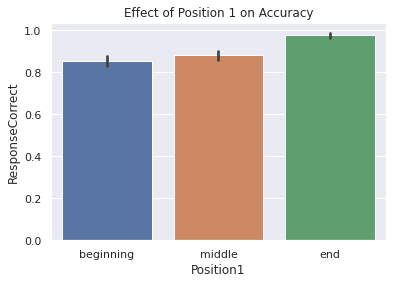

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position1', y = 'ResponseCorrect', 
    data = eeg_no_trials[eeg_no_trials['Position1'] != 0]
)
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Effect of Position 1 on Accuracy');

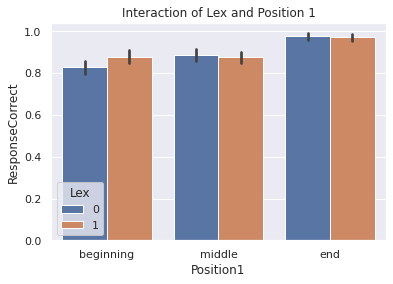

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position1',
    y = 'ResponseCorrect', hue = 'Lex',
    data = eeg_no_trials[eeg_no_trials['Position1'] != 0]
)
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction of Lex and Position 1');

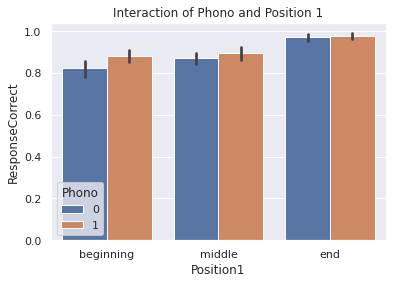

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position1',
    y = 'ResponseCorrect', hue = 'Phono',
    data = eeg_no_trials[eeg_no_trials['Position1'] != 0]
)
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction of Phono and Position 1');

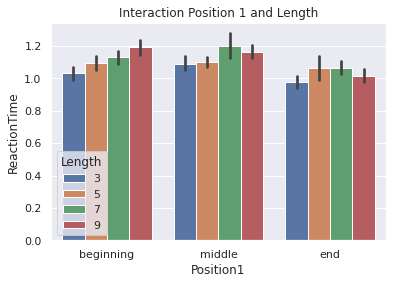

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position1', y = 'ReactionTime', hue = 'Length',
    data = eeg_no_trials[eeg_no_trials['Position'] != 0]
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position 1 and Length');

**Position 3**

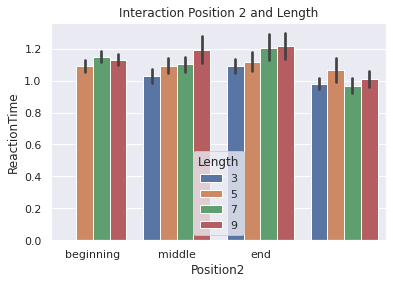

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position2', y = 'ReactionTime', hue = 'Length',
    data = eeg_no_trials[eeg_no_trials['Position'] != 0]
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position 2 and Length');

## Models with position

In [ ]:
%%R -i eeg_no_trials
m <- lmer('ResponseCorrect ~ Length + Lex + ProbeType + Position + Lex:ProbeType + Position:Length + Length:ProbeType + (1|Subject)', data=eeg_no_trials)
m1 <- lmer('ResponseCorrect ~ Length + Lex + ProbeType + Position + Lex:ProbeType + Position:Length + Length:ProbeType + Lex:Position:ProbeType + (1|Subject)', data=eeg_no_trials)
anova(m, m1)

  npar      AIC      BIC    logLik deviance   Chisq Df Pr..Chisq.
1   10 3142.894 3208.961 -1561.447 3122.894      NA NA         NA
2   11 3141.968 3214.641 -1559.984 3119.968 2.92602  1 0.08716211


In [ ]:
mod = Lmer(
    'ResponseCorrect ~ Length + Lex + ProbeType + Position + Lex:ProbeType + Position:Length + Length:ProbeType + (1|Subject)',
    data=eeg_no_trials
)
mod.fit()

Formula: ResponseCorrect~Length+Lex+ProbeType+Position+Lex:ProbeType+Position:Length+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1594.817 	 AIC: 3189.635

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.903   0.785    1.020  0.060  5254.623  15.081  0.000   
Length              -0.004  -0.022    0.014  0.009  5434.666  -0.442  0.658   
Lex                  0.099   0.045    0.153  0.028  5433.131   3.598  0.000   
ProbeType            0.115   0.017    0.213  0.050  5432.844   2.294  0.022   
Position            -0.047  -0.088   -0.005  0.021  5433.015  -2.199  0.028   
Lex:ProbeType       -0.042  -0.076   -0.007  0.017  5433.338  -2.382  0.017   
Length:Position      0.018   0.012    0.025  0.003  5433.330   5.397  0.000   
Length:ProbeType    -0.029  -0.044   -0.013  0.008  5433.379  -3.643  0.000   

                  Sig  
(Intercept)       ***  
Length                 
Lex               ***  
ProbeType           *  
Position            *  
Lex:ProbeType       *  
Length:Position   ***  
Length:ProbeType  ***

In [ ]:
%%R -i position
m <- lmer('stdRT ~ Lex + Length + Position + Length:Position + (1|Subject)', data=position)
m1 <- lmer('stdRT ~ Lex + Length + Position + Length:Position + Length:Position:Lex + (1|Subject)', data=position)
anova(m, m1)

  npar       AIC       BIC   logLik  deviance     Chisq Df Pr..Chisq.
1    7 -250.9716 -209.5285 132.4858 -264.9716        NA NA         NA
2    8 -249.0947 -201.7311 132.5473 -265.0947 0.1230773  1  0.7257205


In [ ]:
mod1 = Lmer(
    'stdRT ~ Lex + Length + Position + Length:Position + (1|Subject)',
    data=position
)
mod1.fit()

Formula: stdRT~Lex+Length+Position+Length:Position+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2753	 Groups: {'Subject': 29.0}

Log-likelihood: 111.395 	 AIC: -222.790

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.032  0.180
Residual               0.051  0.226

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)        -0.046  -0.137    0.046  0.047   103.084  -0.975  0.332   
Lex                -0.043  -0.060   -0.026  0.009  2720.038  -5.018  0.000   
Length              0.030   0.020    0.040  0.005  2720.023   5.857  0.000   
Position            0.010  -0.019    0.040  0.015  2720.054   0.687  0.492   
Length:Position    -0.008  -0.013   -0.003  0.002  2720.072  -3.416  0.001   

                 Sig  
(Intercept)           
Lex              ***  
Length           ***  
Position              
Length:Position  ***

## Bad/good Slow/fast

### iEEG dataset

## Preprocessing of the iEEG dataset



1.   a lot of outliers and no response trials for D54: 50 % are either outliers or no response trials 
2.   7 subject below 75% threshold. 70% - 4. If we count no response trials as INCORRECT. 
3.   After this, outliers and no response are no greater than 10% of data. 75 no response and 79 outliers overall



In [29]:
print('The shape of the iEEG dataset with "No Response" trials', ieeg.shape)
print('The accuracy', ieeg.RespCorrect.mean())
print('The shape of the iEEG dataset without "No Response" trials', ieeg[ieeg['Resp'] != 'No Response'].shape)
print('The accuracy', ieeg[ieeg['Resp'] != 'No Response'].RespCorrect.mean())

The shape of the iEEG dataset with "No Response" trials (5140, 18)
The accuracy 0.7910505836575875
The shape of the iEEG dataset without "No Response" trials (4925, 18)
The accuracy 0.8255837563451777


In [30]:
checkset = ieeg.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)

In [32]:
options_drop1 = checkset[checkset['RespCorrect'] < 0.75].index
new1 = checkset.reset_index()
print('The subjects with accuracy less than 75 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new1.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new1.loc[new1['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg1 = ieeg[
                        (ieeg['Subject'] != 'D30') &
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65') &
                        (ieeg['Subject'] != 'D70')
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg1.RespCorrect.mean())
print('')

options_drop1 = checkset[checkset['RespCorrect'] < 0.70].index
new2 = checkset.reset_index()
print('The subjects with accuracy less than 70 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new2.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new2.loc[new2['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg2 = ieeg[
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65')                       
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg2.RespCorrect.mean())
print('')

The subjects with accuracy less than 75 %
The dataset with "No response" trials
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875]
Poor performers 7
Accuracy without poor performers 0.8389681943400952

The subjects with accuracy less than 70 %
The dataset with "No response" trials
Index(['D33', 'D49', 'D54', 'D61', 'D65'], dtype='object', name='Subject')
[0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65]
Poor performers 5
Accuracy without poor performers 0.8295849756549966



In [33]:
ieeg2.shape

(4313, 18)

In [38]:
print(
    'No response trials in the dataset: ',
    ieeg2[ieeg2['Resp'] == 'No Response'].shape[0]
)


No response trials in the dataset:  94


**Looking into outliers**

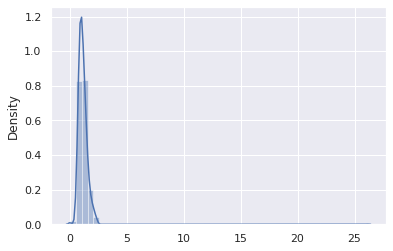

In [41]:
sns.distplot(ieeg2[ieeg2['Resp'] != 'No Response'][['ReactionTime']].values);

In [42]:
print('In seconds')
print(
    'mean', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.mean(),
    'max', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.max(),
    'min', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.min())

In seconds
mean 1.1692777979230295 max 26.11535499338061 min 0.0163338184356689


In [51]:
# kicking out all the trials (13) that are below 150 msec, two of the are no response trials
ieeg_no_outliers = ieeg2[ieeg2['ReactionTime'] > 0.15]

In [54]:
# kicking out the trial of 26 sec, only 1 
ieeg_no_outliers = ieeg_no_outliers[ieeg_no_outliers['ReactionTime'] < 25]

D23 Max 2.5044814660213888 Min 0.5284106724429876
D26 Max 2.248248639079975 Min 0.7032921151840128
D27 Max 2.504055735189468 Min 0.8089978282805532
D28 Max 2.502478436334058 Min 0.5284106724429876
D29 Max 2.390633505769074 Min 0.7759903273545206
D30 Max 2.5042315841419622 Min 0.6001890921761515
D31 Max 2.5029665574547835 Min 1.010608747776132
D34 Max 2.5029558130481746 Min 0.3314915607334114
D35 Max 2.50634925061604 Min 0.4253534044255502
D36 Max 2.502573014283712 Min 0.5638364125347834
D38 Max 2.5024061138974503 Min 0.6113873518770561
D39 Max 2.502780161215924 Min 0.7234540177159943
D41 Max 2.5019888426177204 Min 0.7655674288980663
D42 Max 2.50259930966422 Min 0.8343088356778026
D47 Max 2.503154328718665 Min 0.9056599745672428
D48 Max 2.50514738484344 Min 0.6624780359707074
D53 Max 2.5029803460929543 Min 0.7813855952117592
D55 Max 2.502972317219246 Min 0.6055784318014048
D57 Max 2.502066373825073 Min 0.5506687164306641
D59 Max 2.502418279647827 Min 0.7078800201416016
D63 Max 2.5026211

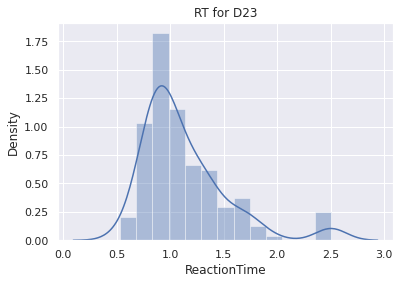

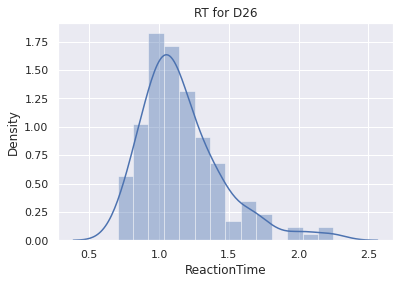

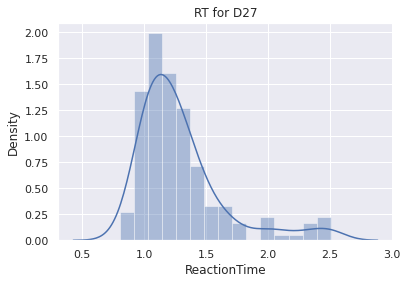

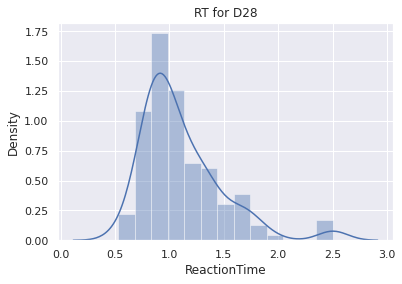

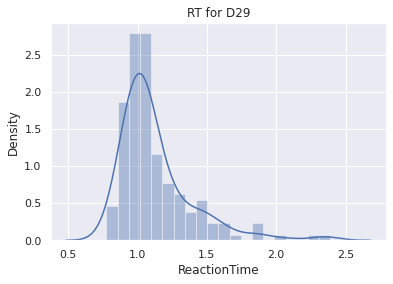

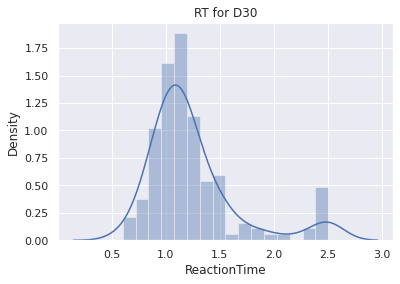

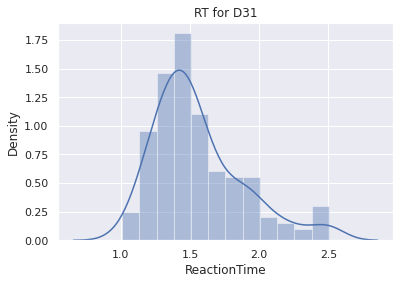

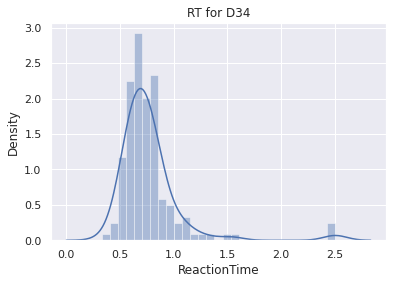

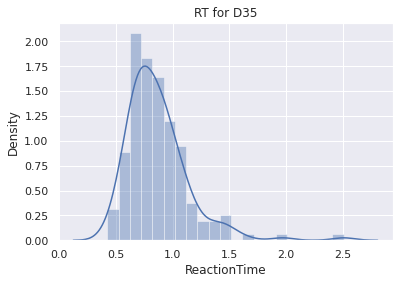

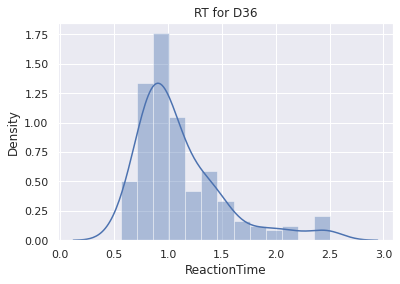

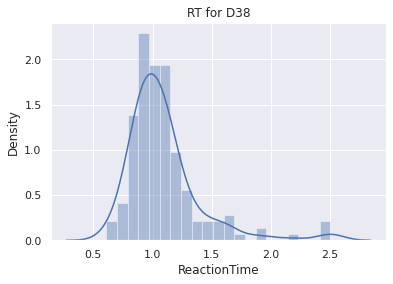

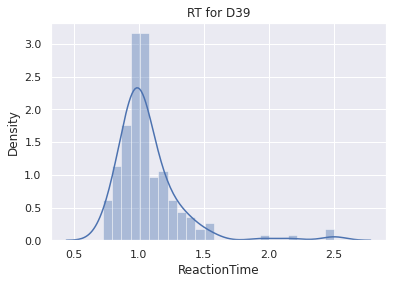

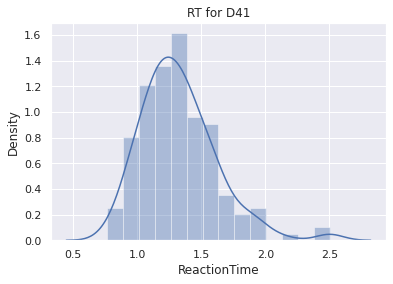

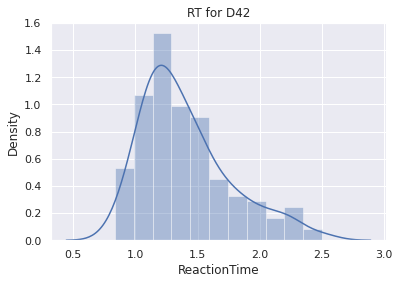

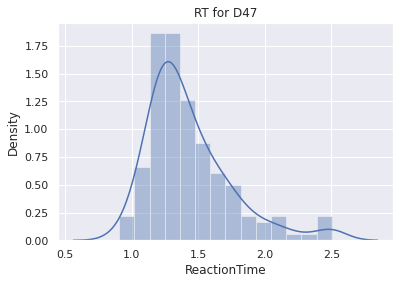

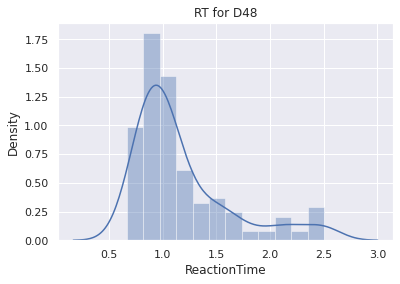

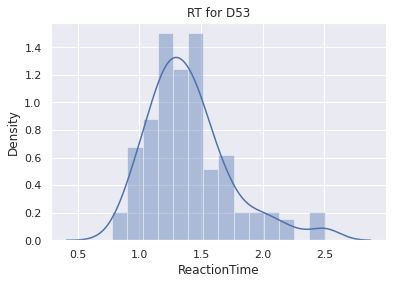

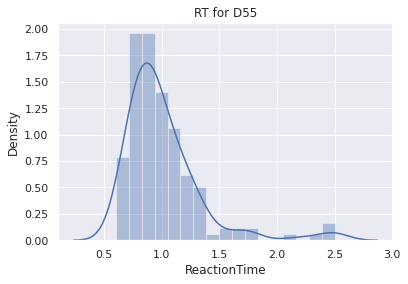

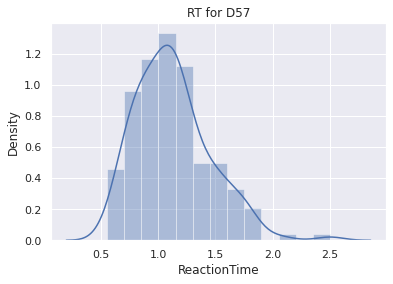

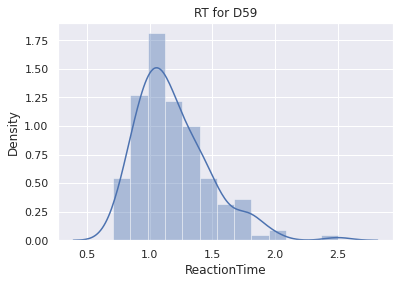

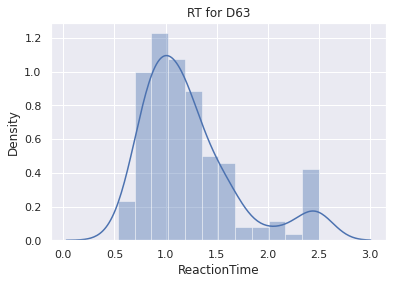

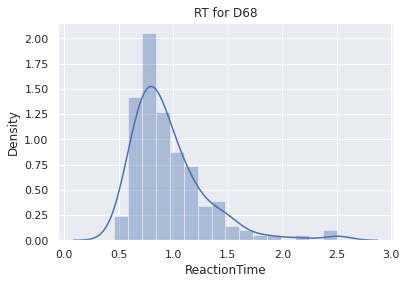

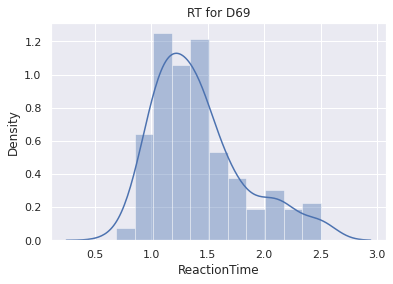

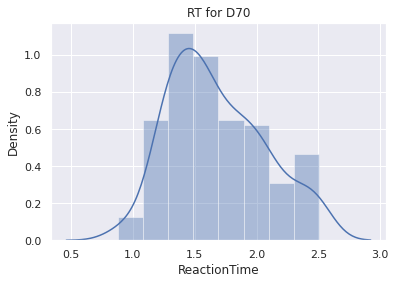

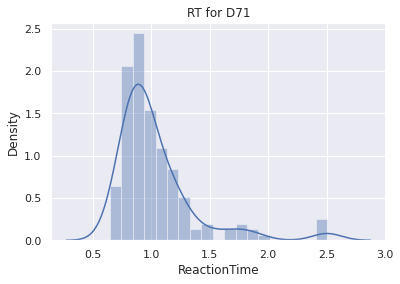

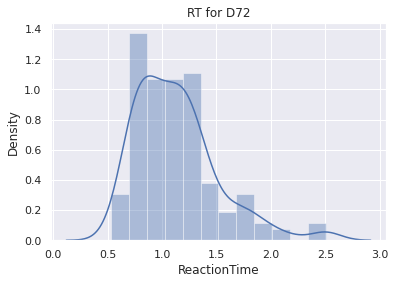

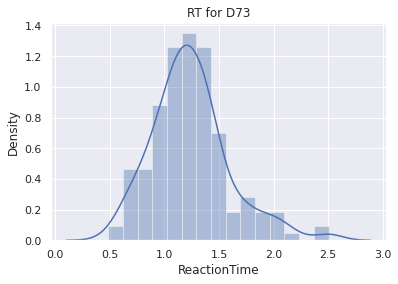

In [57]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.distplot(subset[subset['Resp'] != ' No Response'].ReactionTime)
  pl.title('RT for ' + i);
  print(i, 'Max', subset[subset['Resp'] != ' No Response'].ReactionTime.max(), 'Min', subset[subset['Resp'] != ' No Response'].ReactionTime.min())

Mean 1.166299277058403 Max 2.490496158599853 Min 0.3314915607334114


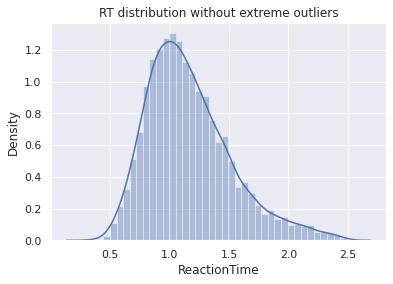

In [58]:
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime)
pl.title('RT distribution without extreme outliers');
print(
    'Mean', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.mean(),
    'Max', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.max(),
    'Min', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.min()
)

In [59]:
values = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  q75 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 75)
  q25 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset[subset['Resp'] != 'No Response'].ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D23 0
D26 2
D27 3
D28 0
D29 3
D30 2
D31 0
D34 2
D35 1
D36 0
D38 3
D39 2
D41 0
D42 0
D47 0
D48 3
D53 0
D55 2
D57 0
D59 0
D63 0
D68 1
D69 0
D70 0
D71 3
D72 0
D73 0


In [60]:
len(values)

27

In [61]:
print(shapiro(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))
print(normaltest(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))

ShapiroResult(statistic=0.9542523622512817, pvalue=2.0983582056748166e-34)
NormaltestResult(statistic=456.1451455166634, pvalue=8.898978911158251e-100)


In [62]:
fitted_data_, fitted_lambda_ = boxcox(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values)

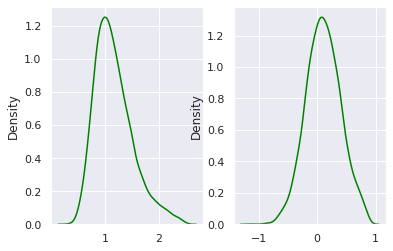

In [63]:
fig, ax = plt.subplots(1, 2)
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data_, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [64]:
print(shapiro(fitted_data_))
print(normaltest(fitted_data_))
print(fitted_lambda_)

ShapiroResult(statistic=0.9984480738639832, pvalue=0.0004106160195078701)
NormaltestResult(statistic=2.0278704217738546, pvalue=0.3627885175088262)
-0.059361959648785365


In [66]:
ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['stdRT'] = fitted_data_

In [69]:
ieeg = ieeg_no_outliers

## Accuracy plots iEEG dataset w/out No response trials

**PLOTS**

BOTH MATCH AND MISMATCH

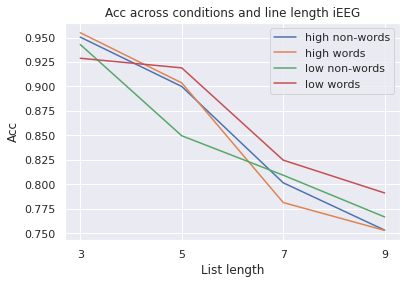

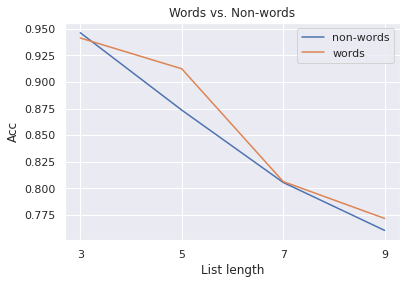

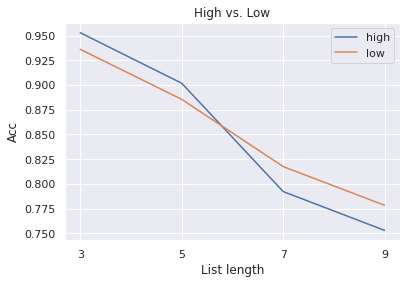

In [ ]:
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG');

pl.figure()
subset = ieeg_no_outliers.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = ieeg_no_outliers.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low');

ONLY MATCH

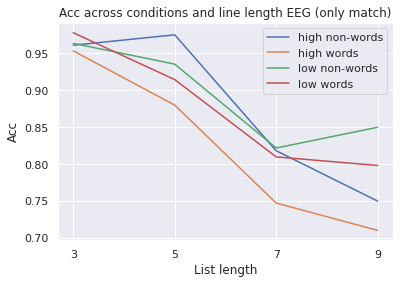

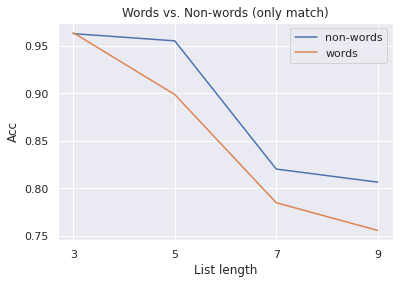

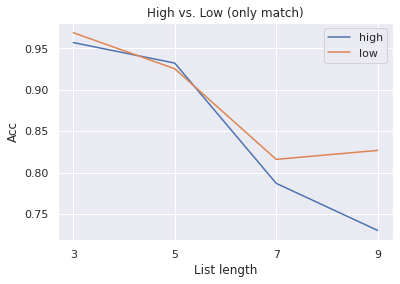

In [ ]:
only_match = ieeg_no_outliers[ieeg_subset['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
    pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match)');

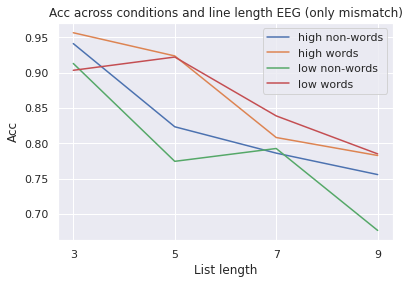

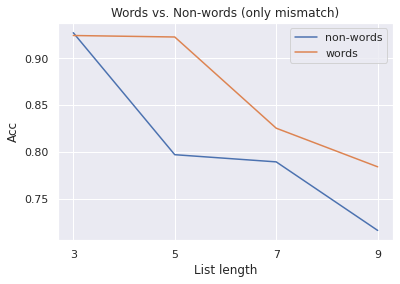

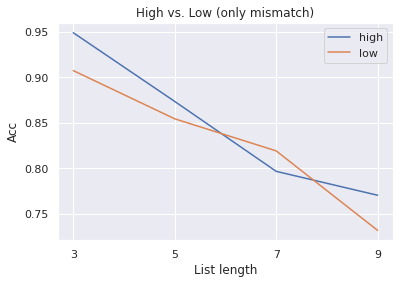

In [ ]:
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch)');

MATCH AND MISMATCH ON THE SAME PLOT

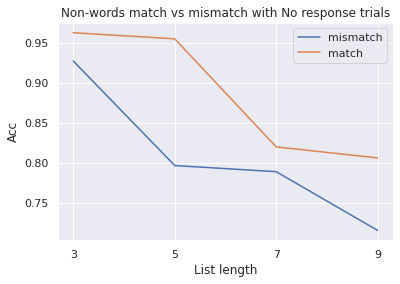

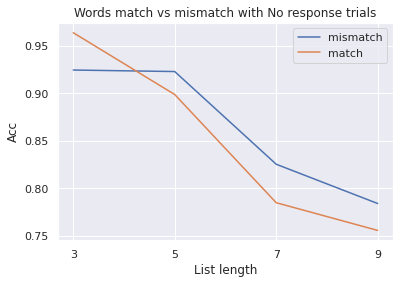

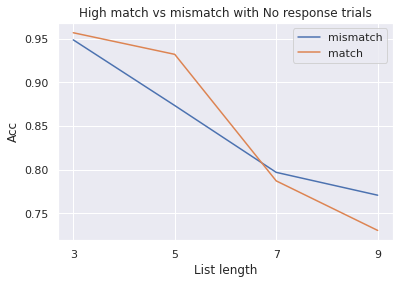

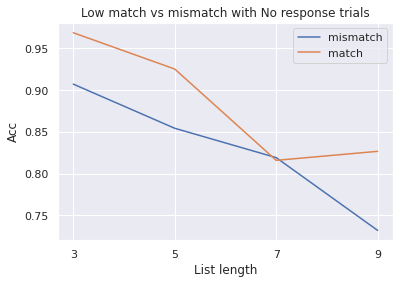

In [ ]:
pl.figure()
nonwords = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');

## Accuracy bar plots

In [ ]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

P-value 0.5271815031643929
H 0.8482758620689655 L 0.8553604436229205


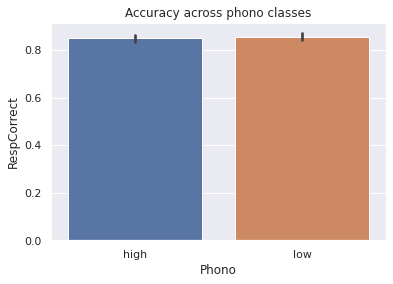

In [ ]:
# W vs NW
pl.figure()
fig = sns.barplot('Phono', 'RespCorrect', data=ieeg_no_outliers)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy across phono classes');

x, y = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]['RespCorrect'].values, ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]['RespCorrect'].values
print('P-value', ttest(x, y)[1])
print('H', y.mean(), 'L', x.mean())

P-value for words 0.2036088121821598
H 0.8472222222222222 L 0.8670944087992667
P-value for non-words 0.7141954851615668
H 0.8493150684931506 L 0.8434296365330848


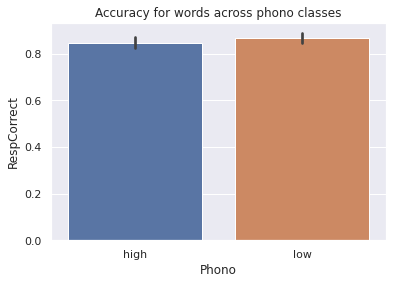

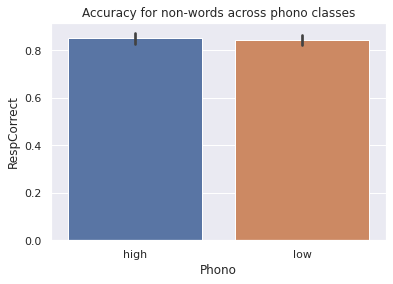

In [ ]:
# W H vs L, NW H vs L
for i in ieeg_no_outliers.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.figure()
  subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == i]
  fig = sns.barplot('Phono', 'RespCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy for ' + name + ' across phono classes');

  x, y = subset[subset['Phono'] == 1]['RespCorrect'].values, subset[subset['Phono'] == 0]['RespCorrect'].values
  print('P-value for', name, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

P-value for words match 0.13707792891789844
H 0.8306264501160093 L 0.8663793103448276
P-value for words mismatch 0.7610186359604696
H 0.8613861386138614 L 0.8676236044657097
P-value for non-words match 0.38378758509780253
H 0.8763796909492274 L 0.8939130434782608
P-value for non-words mismatch 0.11674656228576161
H 0.8245967741935484 L 0.785140562248996


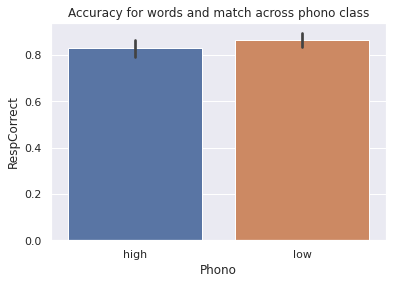

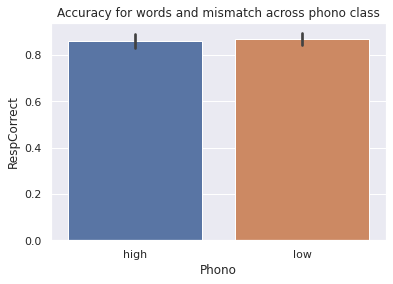

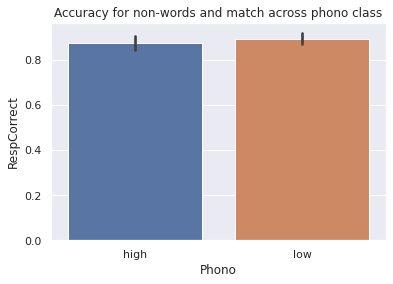

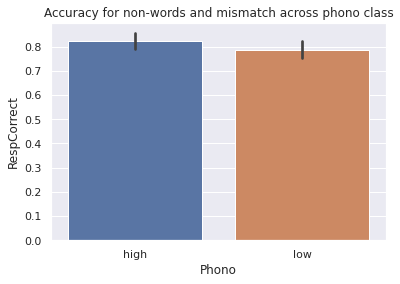

In [ ]:
# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for lex_class in ieeg_no_outliers.Lex.unique():
  if lex_class == 0:
    name1 = 'non-words'
  elif lex_class == 1:
    name1 = 'words'
  subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == lex_class]
  for probe_class in subset.ProbeType.unique():
    if probe_class == 1:
      name2 = 'mismatch'
    elif probe_class == 2:
      name2 = 'match'
    ss = subset[subset['ProbeType'] == probe_class]

    pl.figure()
    fig = sns.barplot('Phono', 'RespCorrect', data=ss)
    fig.set_xticklabels(['high', 'low'])
    pl.title(
        'Accuracy for ' + name1 + ' and ' + name2 + ' across phono class'
    );

    x, y = ss[ss['Phono'] == 1]['RespCorrect'].values, ss[ss['Phono'] == 0]['RespCorrect'].values
    print('P-value for', name1, name2, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

In [ ]:
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i] 
  x, y = subset[subset['Phono'] == 1]['RespCorrect'].values, subset[subset['Phono'] == 0]['RespCorrect'].values
  print('P-value for', i, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

P-value for 3 0.24325556755474803
H 0.9527896995708155 L 0.9360146252285192
P-value for 7 0.31352497579947797
H 0.7922912205567452 L 0.8175182481751825
P-value for 9 0.34107641227094454
H 0.7530364372469636 L 0.7784200385356455
P-value for 5 0.4026274736993214
H 0.9017467248908297 L 0.8854545454545455


In [ ]:
# check for different length
for i in ieeg_no_outliers.Length.unique():
  print(i)
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  for j in subset.Lex.unique():
    if j == 0:
      print('Non-words')
    elif j == 1:
      print('Words')
    ss = subset[subset['Lex'] == j]
    x, y = ss[ss['Phono'] == 1]['RespCorrect'].values, ss[ss['Phono'] == 0]['RespCorrect'].values
    print('P-value for', i, j, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

3
Words
P-value for 3 1 0.20679449778013234
H 0.9549180327868853 L 0.9288389513108615
Non-words
P-value for 3 0 0.7065208145305831
H 0.9504504504504504 L 0.9428571428571428
7
Words
P-value for 7 1 0.22932089100774464
H 0.7813953488372093 L 0.8247422680412371
Non-words
P-value for 7 0 0.825618529599358
H 0.8015873015873016 L 0.8093385214007782
9
Words
P-value for 9 1 0.30470338307857314
H 0.752895752895753 L 0.7911646586345381
Non-words
P-value for 9 0 0.7244423850356685
H 0.7531914893617021 L 0.7666666666666667
5
Words
P-value for 5 1 0.5518706755066514
H 0.9036697247706422 L 0.9190140845070423
Non-words
P-value for 5 0 0.08621122158311831
H 0.9 L 0.849624060150376


In [ ]:
# check for different length

# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  for lex_class in subset.Lex.unique():
    if lex_class == 0:
      name1 = 'non-words'
    elif lex_class == 1:
      name1 = 'words'
    ss = subset[subset['Lex'] == lex_class]
    for probe_class in subset.ProbeType.unique():
      if probe_class == 1:
        name2 = 'mismatch'
      elif probe_class == 2:
        name2 = 'match'
      s = ss[ss['ProbeType'] == probe_class]

      x, y = s[s['Phono'] == 1]['RespCorrect'].values, s[s['Phono'] == 0]['RespCorrect'].values
      print('P-value for', i, 'items', name1, name2, ttest(x, y)[1])
      print('H', y.mean(), 'L', x.mean())
      print('')

P-value for 3 items words match 0.3116707234669746
H 0.9534883720930233 L 0.978021978021978

P-value for 3 items words mismatch 0.07172532680641462
H 0.9565217391304348 L 0.9034090909090909

P-value for 3 items non-words match 0.9183383552546484
H 0.9611650485436893 L 0.9636363636363636

P-value for 3 items non-words mismatch 0.41081471049382756
H 0.9411764705882353 L 0.9130434782608695

P-value for 7 items words match 0.2631993356200037
H 0.7473684210526316 L 0.8098591549295775

P-value for 7 items words mismatch 0.5162751158580279
H 0.8083333333333333 L 0.8389261744966443

P-value for 7 items non-words match 0.9372716411681166
H 0.8181818181818182 L 0.821917808219178

P-value for 7 items non-words mismatch 0.9016003268546038
H 0.7862595419847328 L 0.7927927927927928

P-value for 9 items words mismatch 0.962620902942694
H 0.7828947368421053 L 0.7851851851851852

P-value for 9 items words match 0.1309943117475308
H 0.7102803738317757 L 0.7982456140350878

P-value for 9 items non-words 

## RT plots

both MATCH AND MISMATCH

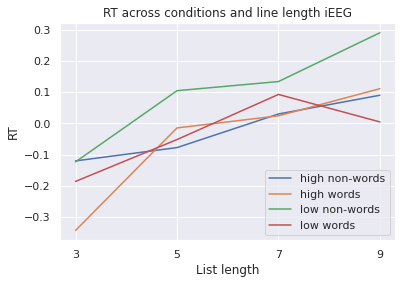

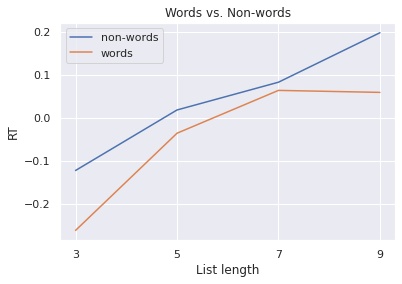

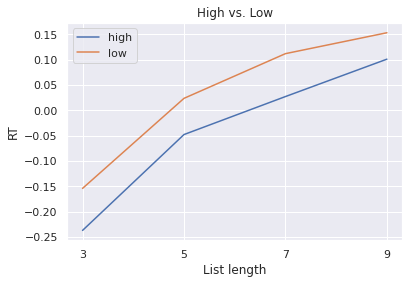

In [ ]:
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length iEEG');

pl.figure()
subset = ieeg_no_outliers.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = ieeg_no_outliers.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low');

P-value [0.00495248]
P-value 0.027857986851166104


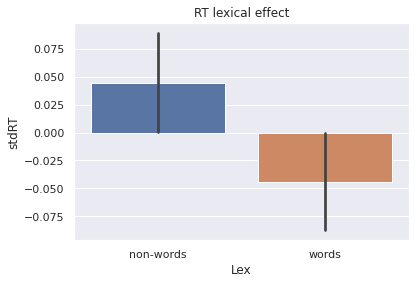

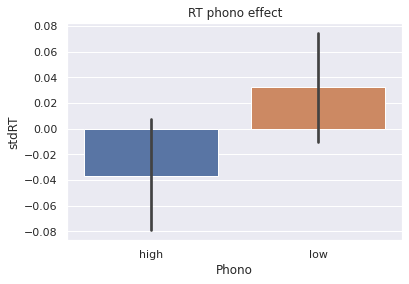

In [ ]:
# significance with length combined
x, y = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1][['stdRT']].values, ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0][['stdRT']].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ieeg_no_outliers['Lex'], ieeg_no_outliers['stdRT'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect');

x, y = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]['stdRT'].values, ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ieeg_no_outliers['Phono'], ieeg_no_outliers['stdRT'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect');

In [ ]:
# significance with different lengths
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['stdRT'].values, subset[subset['Lex'] == 0]['stdRT'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['stdRT'].values, subset[subset['Phono'] == 0]['stdRT'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

P-value for 3 Lex 0.022853206457536246
P-value for 3 Phono 0.17288542027229603
P-value for 7 Lex 0.7525854383884791
P-value for 7 Phono 0.15978358404719487
P-value for 9 Lex 0.03026026627756805
P-value for 9 Phono 0.41430074604134637
P-value for 5 Lex 0.40374049554679114
P-value for 5 Phono 0.2696001215277189


MATCH

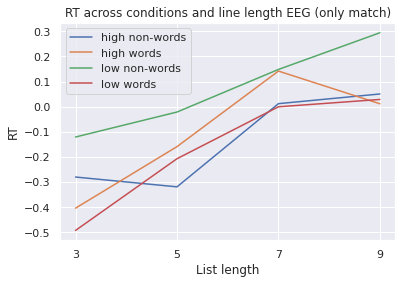

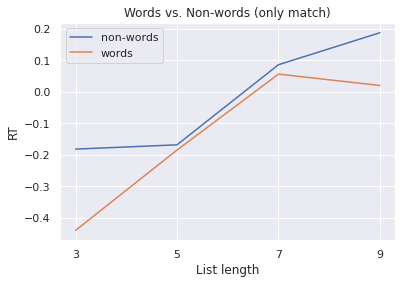

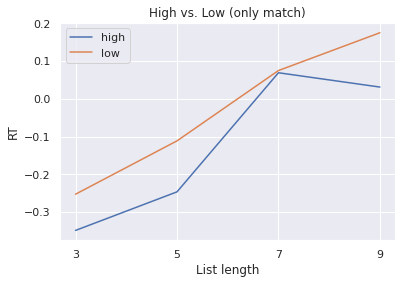

In [ ]:
only_match = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.stdRT, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.stdRT, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only match)');

P-value 0.010763312964797921
P-value 0.019171907041639687


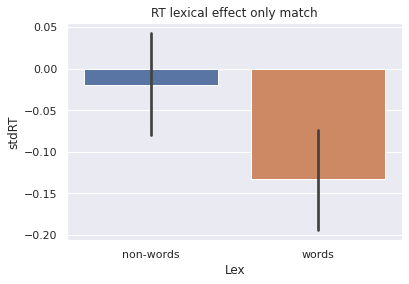

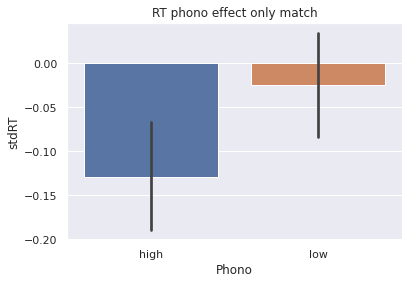

In [ ]:
# significance with length combined
x, y = only_match[only_match['Lex'] == 1]['stdRT'].values, only_match[only_match['Lex'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Lex'], only_match['stdRT'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only match');

x, y = only_match[only_match['Phono'] == 1]['stdRT'].values, only_match[only_match['Phono'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Phono'], only_match['stdRT'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only match');

In [ ]:
# significance with different lengths
print('Only match')
for i in only_match.Length.unique():
  subset = only_match[only_match['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['stdRT'].values, subset[subset['Lex'] == 0]['stdRT'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['stdRT'].values, subset[subset['Phono'] == 0]['stdRT'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Only match
P-value for 3 Lex 0.0007548539793320294
P-value for 3 Phono 0.21748911761503428
P-value for 7 Lex 0.730548377279753
P-value for 7 Phono 0.9469501094609889
P-value for 9 Lex 0.08430008818894967
P-value for 9 Phono 0.13687710434673167
P-value for 5 Lex 0.8518802886143053
P-value for 5 Phono 0.12820889697317475


MISMATCH

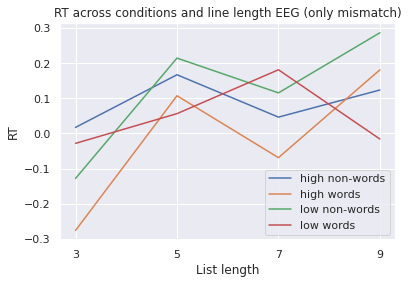

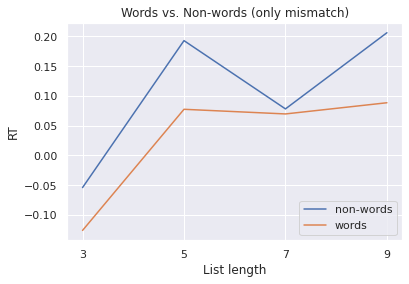

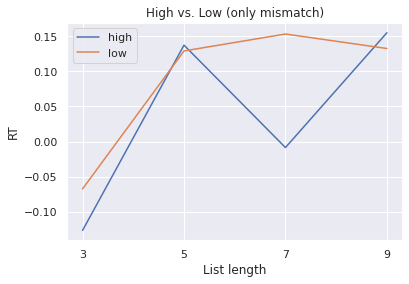

In [ ]:
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only mismatch)');

P-value 0.05683647135271321
P-value 0.3577608935827463


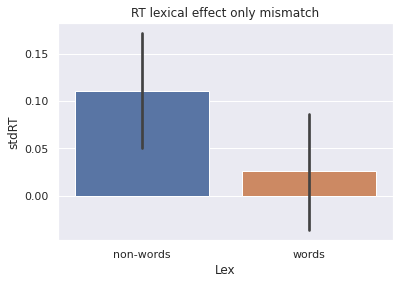

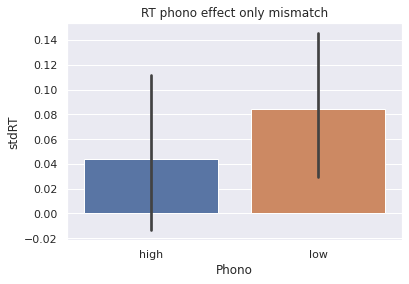

In [ ]:
# significance with length combined
x, y = only_mismatch[only_mismatch['Lex'] == 1]['stdRT'].values, only_mismatch[only_mismatch['Lex'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Lex'], only_mismatch['stdRT'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only mismatch');

x, y = only_mismatch[only_mismatch['Phono'] == 1]['stdRT'].values, only_mismatch[only_mismatch['Phono'] == 0]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Phono'], only_mismatch['stdRT'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only mismatch');

In [ ]:
# significance with different lengths
print('Only mismatch')
for i in only_mismatch.Length.unique():
  subset = only_mismatch[only_mismatch['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['stdRT'].values, subset[subset['Lex'] == 0]['stdRT'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['stdRT'].values, subset[subset['Phono'] == 0]['stdRT'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Only mismatch
P-value for 9 Lex 0.16418393162257883
P-value for 9 Phono 0.7907980181966432
P-value for 5 Lex 0.2051764586588515
P-value for 5 Phono 0.9281083317177167
P-value for 3 Lex 0.4336611863800427
P-value for 3 Phono 0.520860630061774
P-value for 7 Lex 0.919633972119928
P-value for 7 Phono 0.05289889850446694


plotting MATCH AND MISMATCH together

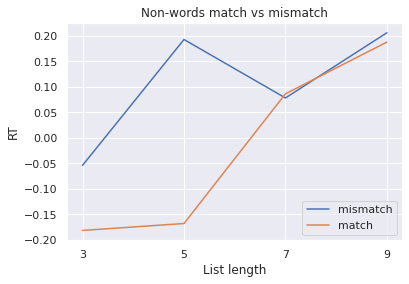

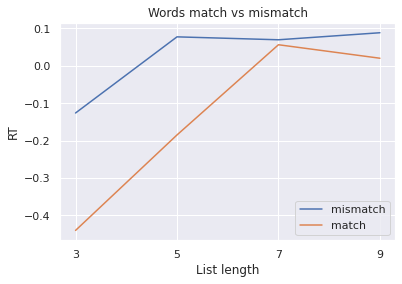

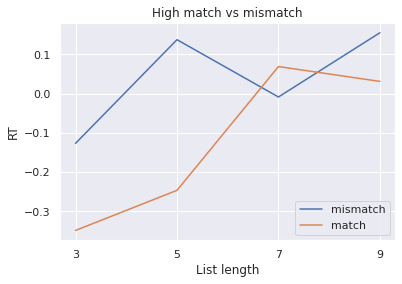

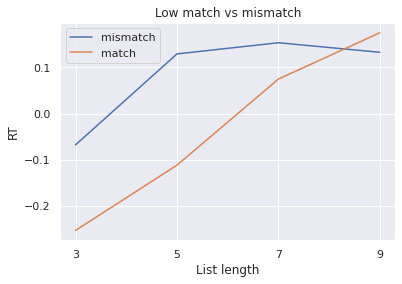

In [ ]:
pl.figure()
nonwords = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Low match vs mismatch');

P-value 0.00341071797152329
P-value 0.00032430051030794805
P-value 0.00013989649416430643
P-value 0.01184774206393009


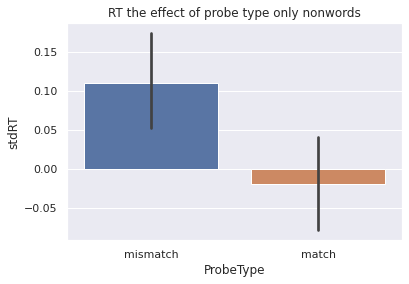

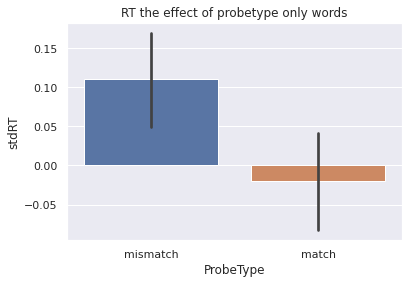

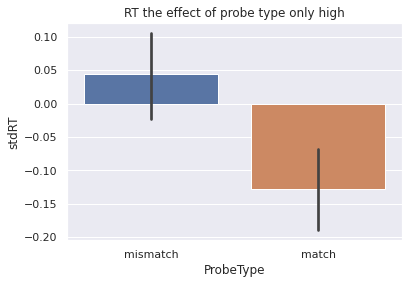

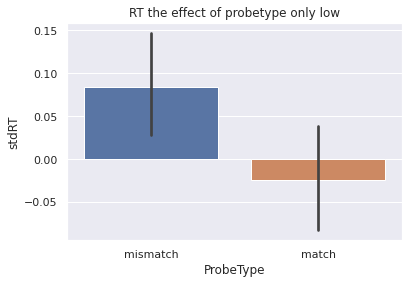

In [ ]:
# significance with length combined
ss = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = ss[ss['ProbeType'] == 2]['stdRT'].values, ss[ss['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ss['ProbeType'], ss['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probe type only nonwords');

s = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = s[s['ProbeType'] == 2]['stdRT'].values, s[s['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ss['ProbeType'], ss['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probetype only words');

hh = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
x, y = hh[hh['ProbeType'] == 2]['stdRT'].values, hh[hh['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(hh['ProbeType'], hh['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probe type only high');

h = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
x, y = h[h['ProbeType'] == 2]['stdRT'].values, h[h['ProbeType'] == 1]['stdRT'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(h['ProbeType'], h['stdRT'])
fig.set_xticklabels(['mismatch', 'match'])
pl.title('RT the effect of probetype only low');

In [ ]:
# significance with different lengths
print('Only nonwords')
for i in ss.Length.unique():
  subset = ss[ss['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only words')
for i in s.Length.unique():
  subset = s[s['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only high')
for i in hh.Length.unique():
  subset = hh[hh['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

print('Only low')
for i in h.Length.unique():
  subset = h[h['Length'] == i]
  x, y = subset[subset['ProbeType'] == 1]['stdRT'].values, subset[subset['ProbeType'] == 2]['stdRT'].values
  print('P-value for', i, 'ProbeType', ttest(x, y)[1])

Only nonwords
P-value for 7 ProbeType 0.9244152488750605
P-value for 3 ProbeType 0.14146374573729767
P-value for 9 ProbeType 0.8372574272258901
P-value for 5 ProbeType 8.45018752087174e-05
Only words
P-value for 3 ProbeType 0.00014634645166998367
P-value for 7 ProbeType 0.8762477803490185
P-value for 9 ProbeType 0.46138106247189103
P-value for 5 ProbeType 0.003175373435387729
Only high
P-value for 7 ProbeType 0.3839345703559258
P-value for 5 ProbeType 4.5232365845460544e-05
P-value for 9 ProbeType 0.17895712134292358
P-value for 3 ProbeType 0.009450515130624108
Only low
P-value for 3 ProbeType 0.0306636373906996
P-value for 9 ProbeType 0.6365389318760595
P-value for 7 ProbeType 0.33996575687732966
P-value for 5 ProbeType 0.005840169957922052


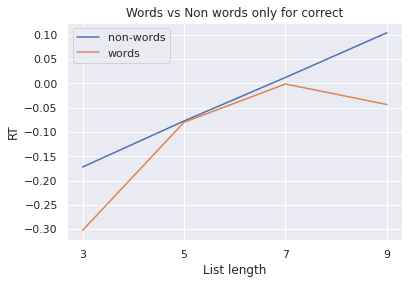

In [ ]:
# CORRECT
pl.figure()
correct = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 1]
subset = correct.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  x = subset[subset['Lex'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs Non words only for correct');

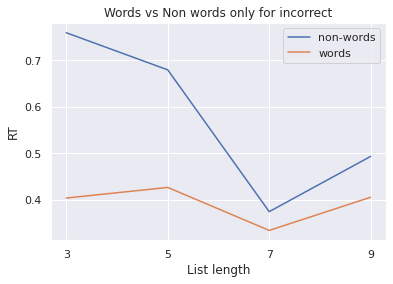

In [ ]:
# INCORRECT
pl.figure()
incorrect = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 0]
subset = incorrect.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  x = subset[subset['Lex'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs Non words only for incorrect');

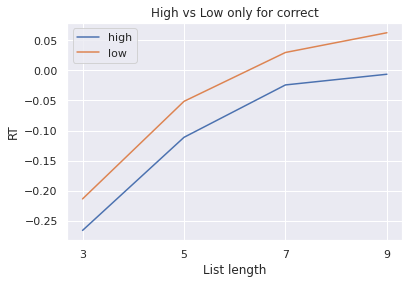

In [ ]:
# CORRECT
pl.figure()
correct = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 1]
subset = correct.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  x = subset[subset['Phono'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs Low only for correct');

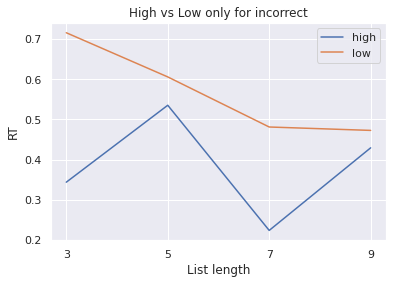

In [ ]:
# CORRECT
pl.figure()
incorrect = ieeg_no_outliers[ieeg_no_outliers['RespCorrect'] == 0]
subset = incorrect.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.Phono.unique():
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  x = subset[subset['Phono'] == i]
  pl.plot(x.Length, x.stdRT, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs Low only for incorrect');

## Ttests

In [ ]:
ieeg_data = ieeg_no_outliers[[
              'Trial', 'Subject', 'block', 'Out',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Resp', 'ReactionTime', 'Length', 'Lex', 'Phono'
]]

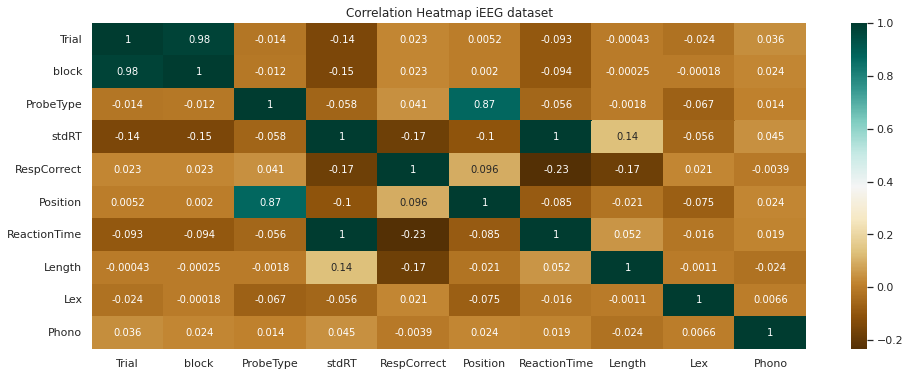

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

In [ ]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

In [ ]:
ieeg_subset = ieeg_data[ieeg_data['Out'] != 'No Response']
match = ieeg_subset[ieeg_subset['ProbeType'] == 2]
mismatch = ieeg_subset[ieeg_subset['ProbeType'] == 1]

In [ ]:
x, y = match[match['Lex'] == 1]['RespCorrect'].values, match[match['Lex'] == 0]['RespCorrect'].values
ttest(x, y)

Ttest_indResult(statistic=-1.9285683843978816, pvalue=0.05395525301632962)

In [ ]:
for i in match.Length.unique():
  subset = match[match['Length'] == i]
  a = subset[subset['Lex'] == 0]['RespCorrect'].values
  b = subset[subset['Lex'] == 1]['RespCorrect'].values
  print(ttest(a,b), i)

Ttest_indResult(statistic=0.6429707746721036, pvalue=0.5206143110083132) 3
Ttest_indResult(statistic=0.49507108505129294, pvalue=0.6207958084308167) 7
Ttest_indResult(statistic=0.811197392751667, pvalue=0.41772686470597165) 9
Ttest_indResult(statistic=2.4260492883148665, pvalue=0.015793064525775218) 5


In [ ]:
for i in match.Length.unique():
  subset = match[match['Length'] == i]
  a = subset[subset['Phono'] == 0]['RespCorrect'].values
  b = subset[subset['Phono'] == 1]['RespCorrect'].values
  print(ttest(a,b), i)


Ttest_indResult(statistic=-0.5028338304724563, pvalue=0.6153421491110809) 3
Ttest_indResult(statistic=-0.8396160908191973, pvalue=0.40161830019338407) 7
Ttest_indResult(statistic=-1.9555000521555255, pvalue=0.0512498186529689) 9
Ttest_indResult(statistic=-0.02796091720310665, pvalue=0.9777065841534331) 5


## Models Accuracy

In [ ]:
tryout1 = Lmer(
    'RespCorrect ~ Lex + (1|Subject)',
    data = ieeg_no_outliers
)
tryout1.fit()

Formula: RespCorrect~Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4049	 Groups: {'Subject': 26.0}

Log-likelihood: -1549.753 	 AIC: 3099.507

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.039
Residual               0.125  0.353

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.846   0.825    0.867  0.011    45.490  77.559  0.000  ***
Lex             0.012  -0.010    0.034  0.011  4022.268   1.061  0.289

In [ ]:
tryout2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + (1|Subject)',
    data = ieeg_no_outliers
)
tryout2.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4049	 Groups: {'Subject': 26.0}

Log-likelihood: -1478.354 	 AIC: 2956.708

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.039
Residual               0.120  0.346

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.983   0.933    1.032  0.025  1070.426  38.897  0.000  ***
Phono           0.004  -0.017    0.025  0.011  4036.658   0.361  0.718     
Lex             0.014  -0.008    0.035  0.011  4019.349   1.245  0.213     
Length         -0.031  -0.036   -0.026  0.002  4019.440 -12.724  0.000  ***
ProbeType       0.031   0.010    0.053  0.011  4034.731   2.853  0.004   **

In [ ]:
final_model = Lmer(
    'RespCorrect ~ Lex + Length + ProbeType + ProbeType:Lex + (1|Subject)',
    data = ieeg_no_outliers
)
final_model.fit()

Formula: RespCorrect~Lex+Length+ProbeType+ProbeType:Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4207	 Groups: {'Subject': 27.0}

Log-likelihood: -1563.423 	 AIC: 3126.845

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.040
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       0.905   0.847    0.962  0.029  1647.361  30.844    0.0  ***
Lex               0.138   0.072    0.204  0.034  4193.991   4.087    0.0  ***
Length           -0.030  -0.035   -0.025  0.002  4176.458 -12.415    0.0  ***
ProbeType         0.079   0.050    0.109  0.015  4181.353   5.215    0.0  ***
Lex:ProbeType    -0.087  -0.129   -0.045  0.022  4195.796  -4.023    0.0  ***

In [ ]:
%%R -i ieeg_no_outliers
comp1<-lmer('RespCorrect ~ Length + ProbeType + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('RespCorrect ~ Length + ProbeType + Lex + Lex:ProbeType + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df   Pr..Chisq.
1    5 3115.721 3147.443 -1552.860 3105.721       NA NA           NA
2    7 3102.831 3147.242 -1544.415 3088.831 16.88988  2 0.0002149858


**Words vs Non words**

In [ ]:
words_ieeg = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
nonwords_ieeg = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]

In [ ]:
# for words
%%R -i words_ieeg
comp1<-lmer('RespCorrect ~ Length + (1|Subject)', data=words_ieeg)
comp2<-lmer('RespCorrect ~ Length + ProbeType + Phono*Length + (1|Subject)', data=words_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    4 1392.611 1415.069 -692.3057 1384.611       NA NA         NA
2    7 1392.161 1431.461 -689.0806 1378.161 6.450188  3 0.09164781


In [ ]:
mod = Lmer(
    'RespCorrect ~ Length + (1|Subject)',
    data=words_ieeg
)
mod.fit()

Formula: RespCorrect~Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2027	 Groups: {'Subject': 26.0}

Log-likelihood: -700.512 	 AIC: 1401.023

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.055
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.042   0.995    1.089  0.024   263.115  43.438    0.0  ***
Length         -0.031  -0.037   -0.024  0.003  2000.340  -9.186    0.0  ***

In [ ]:
# for nonwords
%%R -i nonwords_ieeg
comp1<-lmer('RespCorrect ~ ProbeType + Length + (1|Subject)', data=nonwords_ieeg)
comp2<-lmer('RespCorrect ~ ProbeType + Length + ProbeType*Length + (1|Subject)', data=nonwords_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance      Chisq Df Pr..Chisq.
1    5 1519.180 1547.239 -754.5900 1509.180         NA NA         NA
2    6 1521.103 1554.775 -754.5517 1509.103 0.07654523  1   0.782035


In [ ]:
mod1 = Lmer(
    'RespCorrect ~ Length + ProbeType + (1|Subject)',
    data=nonwords_ieeg
)
mod1.fit()

Formula: RespCorrect~Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2022	 Groups: {'Subject': 26.0}

Log-likelihood: -766.247 	 AIC: 1532.494

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.913   0.847    0.978  0.033  1300.701  27.313    0.0  ***
Length         -0.031  -0.038   -0.024  0.003  1994.703  -8.844    0.0  ***
ProbeType       0.079   0.048    0.109  0.016  2002.967   5.040    0.0  ***

**If we distinguish between match and mismatch**

In [ ]:
match_ieeg = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
mismatch_ieeg = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

In [ ]:
# for match
%%R -i match_ieeg
comp1<-lmer('RespCorrect ~ Length + Lex + Phono + Length:Phono + (1|Subject)', data=match_ieeg)
comp2<-lmer('RespCorrect ~ Length + Lex + Phono + Length:Phono + Phono:Lex:Length + (1|Subject)', data=match_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    7 1142.878 1181.810 -564.4392 1128.878        NA NA         NA
2    8 1144.754 1189.247 -564.3769 1128.754 0.1245815  1  0.7241176


In [ ]:
mod = Lmer(
    'RespCorrect ~ Length + Lex + Phono + Length:Phono + (1|Subject)',
    data=match_ieeg
)
mod.fit()

Formula: RespCorrect~Length+Lex+Phono+Length:Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1923	 Groups: {'Subject': 26.0}

Log-likelihood: -583.222 	 AIC: 1166.444

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.004  0.066
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      1.123   1.056    1.191  0.034   550.342  32.784  0.000  ***
Length          -0.043  -0.052   -0.033  0.005  1898.591  -8.809  0.000  ***
Lex             -0.038  -0.067   -0.009  0.015  1902.658  -2.586  0.010   **
Phono           -0.071  -0.154    0.012  0.042  1896.642  -1.685  0.092    .
Length:Phono     0.017   0.004    0.030  0.007  1898.369   2.520  0.012    *

In [ ]:
# for mismatch
%%R -i mismatch_ieeg
comp1<-lmer('RespCorrect ~ Length + Lex + (1|Subject)', data=mismatch_ieeg)
comp2<-lmer('RespCorrect ~ Length + Lex + Lex:Phono:Length + (1|Subject)', data=mismatch_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance      Chisq Df Pr..Chisq.
1    5 1700.251 1728.561 -845.1254 1690.251         NA NA         NA
2    6 1702.194 1736.166 -845.0969 1690.194 0.05704128  1   0.811235


In [ ]:
mod1 = Lmer(
    'RespCorrect ~ Length + Lex + (1|Subject)',
    data=mismatch_ieeg
)
mod1.fit()

Formula: RespCorrect~Length+Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2126	 Groups: {'Subject': 26.0}

Log-likelihood: -856.416 	 AIC: 1712.832

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.004  0.065
Residual               0.128  0.357

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.978   0.925    1.031  0.027   254.296  36.267    0.0  ***
Length         -0.029  -0.036   -0.022  0.003  2099.930  -8.344    0.0  ***
Lex             0.059   0.029    0.090  0.016  2106.970   3.791    0.0  ***

**Plots for significant results**

All conditions

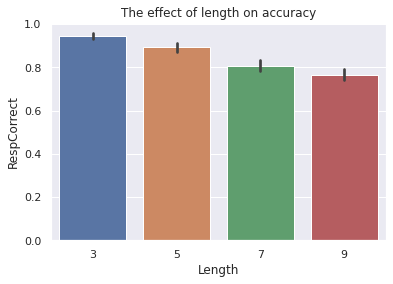

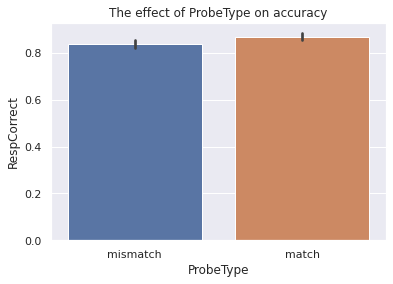

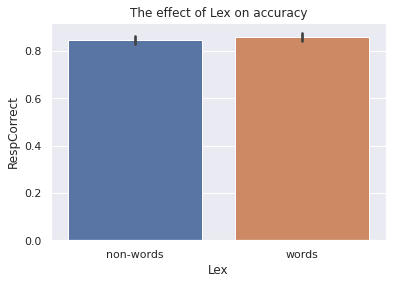

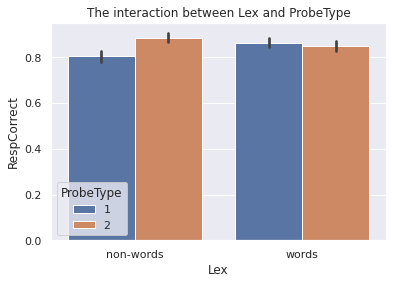

In [ ]:
pl.figure()
ax = sns.barplot('Length', 'RespCorrect', data=ieeg_no_outliers)
pl.title('The effect of length on accuracy');

pl.figure()
ax = sns.barplot('ProbeType', 'RespCorrect', data=ieeg_no_outliers)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of ProbeType on accuracy');

pl.figure()
ax = sns.barplot('Lex', 'RespCorrect', data=ieeg_no_outliers)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The effect of Lex on accuracy');

pl.figure()
ax = sns.barplot(x="Lex", y="RespCorrect", hue="ProbeType", data=ieeg_no_outliers)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The interaction between Lex and ProbeType');


In [ ]:
# for W M vs MM
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['ProbeType'] == 2][['RespCorrect']].values, subset[subset['ProbeType'] == 1][['RespCorrect']].values
print(ttest(x,y))

# for NW M vs MM
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['ProbeType'] == 2][['RespCorrect']].values, subset[subset['ProbeType'] == 1][['RespCorrect']].values
print(ttest(x,y))

# for M W vs NW 
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
print(ttest(x,y))

# for MM W vs NW 
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
print(ttest(x,y))

Ttest_indResult(statistic=array([-0.99838816]), pvalue=array([0.31821986]))
Ttest_indResult(statistic=array([5.0809463]), pvalue=array([4.12381252e-07]))
Ttest_indResult(statistic=array([2.3825981]), pvalue=array([0.01729408]))
Ttest_indResult(statistic=array([-3.710824]), pvalue=array([0.0002123]))


WORDS VS NONWORDS

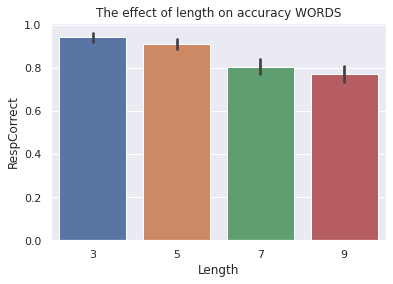

In [ ]:
#for words 
pl.figure()
ax = sns.barplot(
    'Length', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
    )
pl.title('The effect of length on accuracy WORDS');

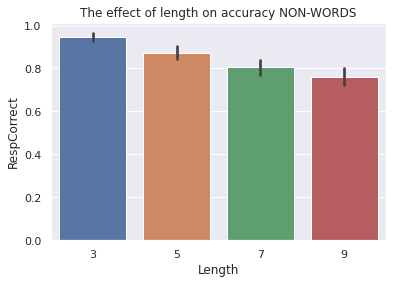

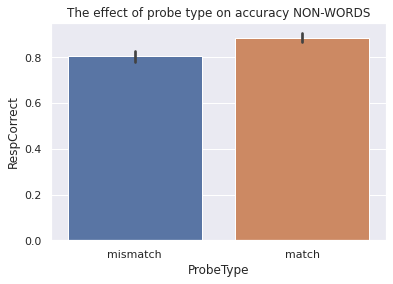

In [ ]:
#for nonwords 
pl.figure()
ax = sns.barplot(
    'Length', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
    )
pl.title('The effect of length on accuracy NON-WORDS');

pl.figure()
ax = sns.barplot(
    'ProbeType', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
    )
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of probe type on accuracy NON-WORDS');

MATCH VS MISMATCH

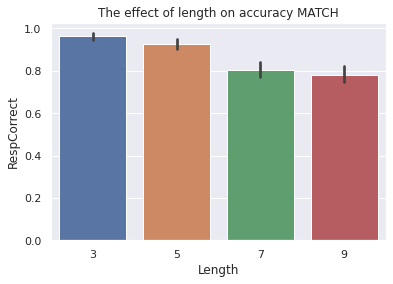

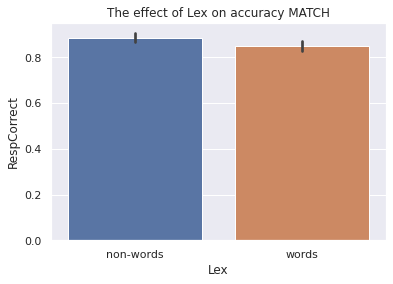

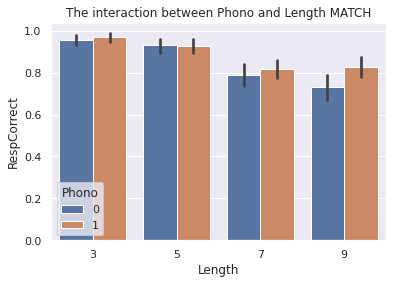

In [ ]:
# for match
pl.figure()
ax = sns.barplot(
    'Length', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
    )
pl.title('The effect of length on accuracy MATCH');

pl.figure()
ax = sns.barplot(
    'Lex', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
    )
ax.set_xticklabels(['non-words', 'words'])
pl.title('The effect of Lex on accuracy MATCH');

pl.figure()
ax = sns.barplot(
    x="Length", y="RespCorrect", hue="Phono", 
    data=ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
    )
pl.title('The interaction between Phono and Length MATCH');


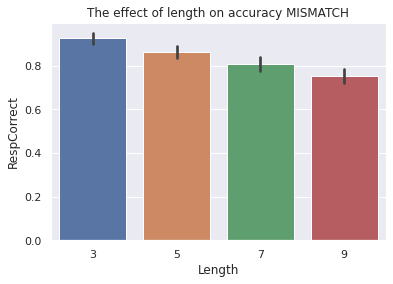

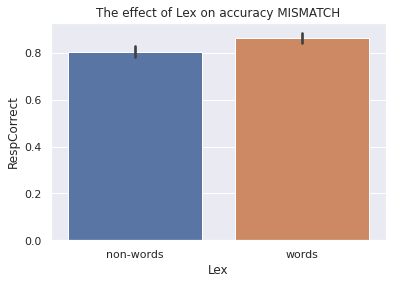

In [ ]:
#for mismatch
pl.figure()
ax = sns.barplot(
    'Length', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
    )
pl.title('The effect of length on accuracy MISMATCH');

pl.figure()
ax = sns.barplot(
    'Lex', 'RespCorrect', 
    data=ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
    )
ax.set_xticklabels(['non-words', 'words'])
pl.title('The effect of Lex on accuracy MISMATCH');


## Models RT

All condition

In [ ]:
%%R
comp1<-lmer('stdRT ~ Lex + Length + ProbeType + Length:ProbeType + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('stdRT ~ Lex + Length + ProbeType + Length:ProbeType + Lex:Length:ProbeType + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar       AIC       BIC   logLik  deviance    Chisq Df Pr..Chisq.
1    7 -111.7885 -67.64497 62.89427 -125.7885       NA NA         NA
2    8 -110.1920 -59.74223 63.09602 -126.1920 0.403489  1  0.5252929


In [ ]:
rt = Lmer(
    'stdRT ~ Lex + Length + ProbeType + Length:ProbeType + (1|Subject)',
    data=ieeg_no_outliers
)
rt.fit()

Formula: stdRT~Lex+Length+ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4049	 Groups: {'Subject': 26.0}

Log-likelihood: 42.204 	 AIC: -84.407

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.032  0.178
Residual               0.055  0.235

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.176   0.081    0.271  0.048    88.707   3.641  0.000   
Lex                 -0.031  -0.046   -0.017  0.007  4019.012  -4.241  0.000   
Length              -0.001  -0.011    0.009  0.005  4019.151  -0.124  0.901   
ProbeType           -0.108  -0.150   -0.067  0.021  4019.124  -5.109  0.000   
Length:ProbeType     0.012   0.006    0.019  0.003  4019.171   3.660  0.000   

                  Sig  
(Intercept)       ***  
Lex               ***  
Length                 
ProbeType         ***  
Length:ProbeType  ***

**Words vs Nonwords**

Words

In [ ]:
# for words
%%R
comp1<-lmer('stdRT ~ ProbeType + Length + ProbeType:Length + (1|Subject)', data=words_ieeg)
comp2<-lmer('stdRT ~ Length + ProbeType + ProbeType:Length + ProbeType:Phono:Length + (1|Subject)', data=words_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    6 5034.765 5068.451 -2511.382 5022.765        NA NA         NA
2    7 5036.623 5075.924 -2511.312 5022.623 0.1414224  1   0.706871


In [ ]:
rt1 = Lmer(
    'stdRT ~ ProbeType + Length + ProbeType:Length + (1|Subject)',
    data=words_ieeg
)
rt1.fit()

Formula: stdRT~ProbeType+Length+ProbeType:Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2027	 Groups: {'Subject': 26.0}

Log-likelihood: -2522.120 	 AIC: 5044.240

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.325  0.570
Residual               0.667  0.817

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.305  -0.075    0.686  0.194   206.168   1.572  0.117   
ProbeType           -0.463  -0.668   -0.258  0.105  1998.310  -4.418  0.000   
Length              -0.029  -0.078    0.019  0.025  1998.357  -1.175  0.240   
ProbeType:Length     0.057   0.025    0.089  0.016  1998.375   3.506  0.000   

                  Sig  
(Intercept)            
ProbeType         ***  
Length                 
ProbeType:Length  ***

Non-words

In [ ]:
%%R
comp1<-lmer('stdRT ~ ProbeType + Length + Phono + Length:ProbeType + Phono:ProbeType + (1|Subject)', data=nonwords_ieeg)
comp2<-lmer('stdRT ~ Phono + Length + ProbeType + Length:ProbeType + Phono:ProbeType + Length:Phono:ProbeType + (1|Subject)', data=nonwords_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    8 5061.033 5105.928 -2522.517 5045.033        NA NA         NA
2    9 5062.471 5112.978 -2522.236 5044.471 0.5622776  1   0.453344


In [ ]:
rt1 = Lmer(
    'stdRT ~ ProbeType + Length + Phono + Length:ProbeType + Phono:ProbeType + (1|Subject)',
    data=nonwords_ieeg
)
rt1.fit()

Formula: stdRT~ProbeType+Length+Phono+Length:ProbeType+Phono:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2022	 Groups: {'Subject': 26.0}

Log-likelihood: -2537.334 	 AIC: 5074.668

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.307  0.554
Residual               0.680  0.825

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.345  -0.066    0.757  0.210   302.482   1.647  0.101   
ProbeType           -0.434  -0.656   -0.212  0.113  1991.089  -3.838  0.000   
Length              -0.007  -0.058    0.045  0.026  1991.150  -0.259  0.795   
Phono               -0.144  -0.373    0.085  0.117  1991.330  -1.232  0.218   
ProbeType:Length     0.039   0.007    0.071  0.016  1991.166   2.378  0.017   
ProbeType:Phono      0.146   0.001    0.290  0.074  1991.349   1.976  0.048   

                  Sig  
(Intercept)            
ProbeType         ***  
Length                 
Phono                  
ProbeType:Length    *  
ProbeType:Phono     *

[Text(0, 0, 'mismatch'), Text(0, 0, 'match')]

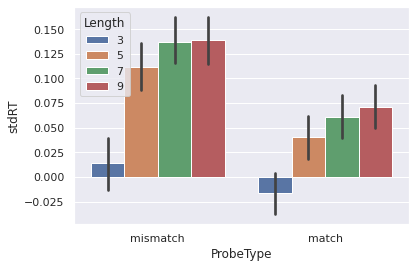

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'ProbeType',
    y = 'stdRT',
    hue = 'Length',
    data = eeg_no_trials
);
ax.set_xticklabels(['mismatch', 'match'])

[Text(0, 0, 'mismatch'), Text(0, 0, 'match')]

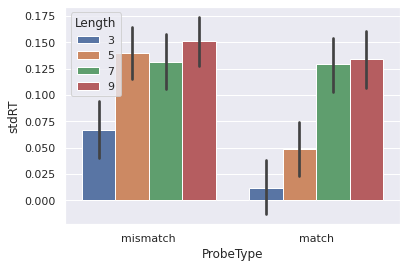

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'ProbeType',
    y = 'stdRT',
    hue = 'Length',
    data = ieeg_no_outliers
);
ax.set_xticklabels(['mismatch', 'match'])

**Match vs Mismatch**

Match

In [ ]:
%%R
comp1<-lmer('stdRT ~ Phono + Lex + Length + Phono:Lex + (1|Subject)', data=match_ieeg)
comp2<-lmer('stdRT ~ Phono + Lex + Length + Phono:Lex + Lex:Length:Phono + (1|Subject)', data=match_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    7 4678.934 4717.865 -2332.467 4664.934        NA NA         NA
2    8 4680.750 4725.243 -2332.375 4664.750 0.1842042  1  0.6677848


In [ ]:
mod1 = Lmer(
    'stdRT ~ Phono + Lex + Length + Phono:Lex + (1|Subject)',
    data=match_ieeg
)
mod1.fit()

Formula: stdRT~Phono+Lex+Length+Phono:Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1923	 Groups: {'Subject': 26.0}

Log-likelihood: -2344.140 	 AIC: 4688.280

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.300  0.547
Residual               0.633  0.795

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.561  -0.804   -0.318  0.124    41.781  -4.528  0.000  ***
Phono           0.143   0.044    0.242  0.050  1894.648   2.841  0.005   **
Lex            -0.013  -0.118    0.092  0.054  1893.317  -0.248  0.804     
Length          0.079   0.063    0.095  0.008  1893.203   9.644  0.000  ***
Phono:Lex      -0.144  -0.289   -0.000  0.074  1894.412  -1.962  0.050    *

Mismatch

In [ ]:
%%R
comp1<-lmer('stdRT ~ Length + Lex + (1|Subject)', data=mismatch_ieeg)
comp2<-lmer('stdRT ~ Length + Lex + Phono + Length:Lex + (1|Subject)', data=mismatch_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    5 5349.796 5378.106 -2669.898 5339.796        NA NA         NA
2    7 5353.196 5392.830 -2669.598 5339.196 0.6007204  2  0.7405514


In [ ]:
mod1 = Lmer(
    'stdRT ~ Lex + Length + (1|Subject)',
    data=mismatch_ieeg
)
mod1.fit()

Formula: stdRT~Lex+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2126	 Groups: {'Subject': 26.0}

Log-likelihood: -2677.434 	 AIC: 5354.867

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.349  0.591
Residual               0.690  0.831

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)    -0.076  -0.328    0.176  0.128    35.960  -0.590  0.559     
Lex            -0.090  -0.161   -0.019  0.036  2098.901  -2.474  0.013    *
Length          0.030   0.015    0.046  0.008  2098.207   3.787  0.000  ***

**Significant plots**

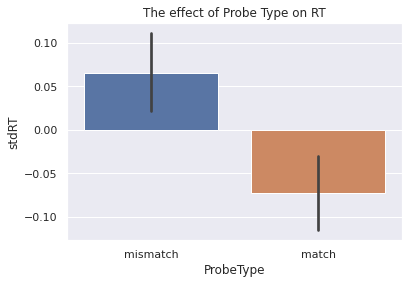

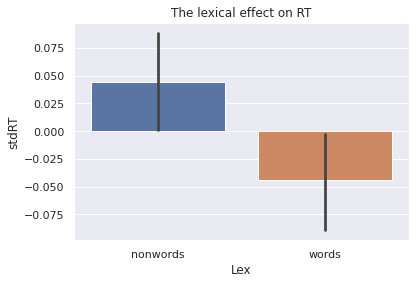

In [ ]:
pl.figure()
ax = sns.barplot(
    ieeg_no_outliers['ProbeType'], ieeg_no_outliers['stdRT']
)
ax.set_xticklabels(['mismatch', 'match'])
pl.title('The effect of Probe Type on RT');

pl.figure()
ax = sns.barplot(
    ieeg_no_outliers['Lex'], ieeg_no_outliers['stdRT']
)
ax.set_xticklabels(['nonwords', 'words'])
pl.title('The lexical effect on RT');

Ttest_indResult(statistic=array([-2.20008419]), pvalue=array([0.02785799]))

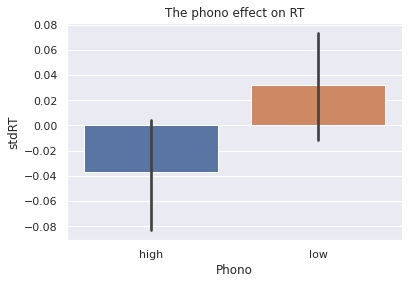

In [ ]:
pl.figure()
ax = sns.barplot(
    ieeg_no_outliers['Phono'], ieeg_no_outliers['stdRT']
)
ax.set_xticklabels(['high', 'low'])
pl.title('The phono effect on RT');

x, y = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0][['stdRT']].values, ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1][['stdRT']].values
ttest(x,y)

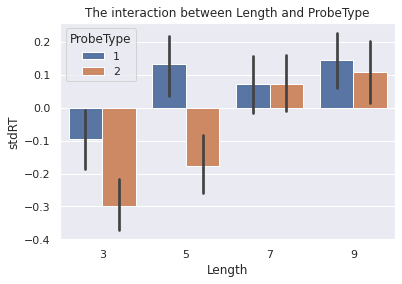

In [ ]:
pl.figure()
ax = sns.barplot(x="Length", y="stdRT", hue="ProbeType", data=ieeg_no_outliers)
pl.title('The interaction between Length and ProbeType');

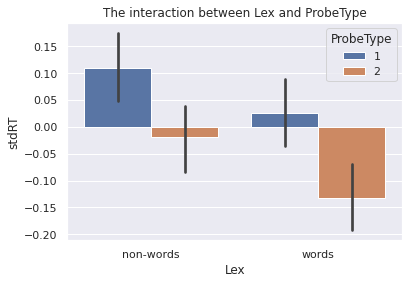

In [ ]:
pl.figure()
ax = sns.barplot(x="Lex", y="stdRT", hue="ProbeType", data=ieeg_no_outliers)
ax.set_xticklabels(['non-words', 'words'])
pl.title('The interaction between Lex and ProbeType');

In [ ]:
# for W M vs MM
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['ProbeType'] == 2][['stdRT']].values, subset[subset['ProbeType'] == 1][['stdRT']].values
print(ttest(x,y))

# for NW M vs MM
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['ProbeType'] == 2][['stdRT']].values, subset[subset['ProbeType'] == 1][['stdRT']].values
print(ttest(x,y))

# for M W vs NW 
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x,y))

# for MM W vs NW 
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x,y))

Ttest_indResult(statistic=array([-3.60141126]), pvalue=array([0.0003243]))
Ttest_indResult(statistic=array([-2.93155131]), pvalue=array([0.00341072]))
Ttest_indResult(statistic=array([2.55280725]), pvalue=array([0.01076331]))
Ttest_indResult(statistic=array([1.90561485]), pvalue=array([0.05683647]))


## Position in iEEG

In [ ]:
position_ieeg = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]

**Accuracy**

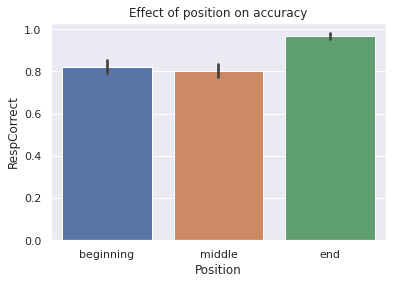

In [ ]:
pl.figure()
fig = sns.barplot(position_ieeg['Position'], position_ieeg['RespCorrect'])
fig.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Effect of position on accuracy');

In [ ]:
print('Ttest for position 1 vs 2')
x, y = position_ieeg[position_ieeg['Position'] == 1][['RespCorrect']].values, position_ieeg[position_ieeg['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3')
x, y = position_ieeg[position_ieeg['Position'] == 2][['RespCorrect']].values, position_ieeg[position_ieeg['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3')
x, y = position_ieeg[position_ieeg['Position'] == 1][['RespCorrect']].values, position_ieeg[position_ieeg['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

Ttest for position 1 vs 2
Ttest_indResult(statistic=array([0.89065999]), pvalue=array([0.37328624]))
Ttest for position 2 vs 3
Ttest_indResult(statistic=array([-9.49314385]), pvalue=array([2.35574855e-20]))
Ttest for position 1 vs 3
Ttest_indResult(statistic=array([-8.65382965]), pvalue=array([2.50536716e-17]))


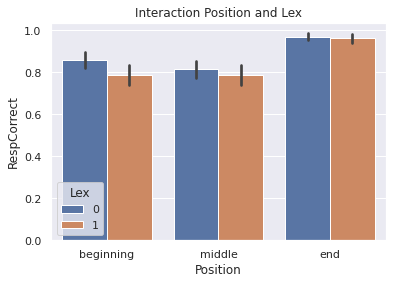

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'RespCorrect', hue = 'Lex',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Lex');

In [ ]:
print('WORDS')
print('Ttest for position 1 vs 2 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 3][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('NON WORDS')
print('Ttest for position 1 vs 2 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 3][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 1]
x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
print(ttest(x,y))

print('Position 2 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 2]
x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
print(ttest(x,y))

print('Position 3 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 3]
x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
print(ttest(x,y))

WORDS
Ttest for position 1 vs 2 Words
Ttest_indResult(statistic=array([-0.0202068]), pvalue=array([0.98388553]))
Ttest for position 2 vs 3 Words
Ttest_indResult(statistic=array([6.54503043]), pvalue=array([2.06047578e-10]))
Ttest for position 1 vs 3 Words
Ttest_indResult(statistic=array([-7.01824537]), pvalue=array([8.67486421e-12]))
NON WORDS
Ttest for position 1 vs 2 Non-Words
Ttest_indResult(statistic=array([1.57226275]), pvalue=array([0.1163788]))
Ttest for position 2 vs 3 Non-Words
Ttest_indResult(statistic=array([6.88661773]), pvalue=array([1.87272791e-11]))
Ttest for position 1 vs 3 Non-Words
Ttest_indResult(statistic=array([-5.06363317]), pvalue=array([6.21065359e-07]))
POSITION
Position 1 W vs NW
Ttest_indResult(statistic=array([2.4312272]), pvalue=array([0.01533761]))
Position 2 W vs NW
Ttest_indResult(statistic=array([0.86687043]), pvalue=array([0.38638534]))
Position 3 W vs NW
Ttest_indResult(statistic=array([0.45211424]), pvalue=array([0.65134018]))


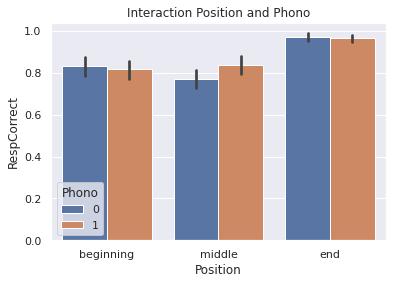

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'RespCorrect', hue = 'Phono',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Phono');

In [ ]:
print('LOW')
print('Ttest for position 1 vs 2 Low')
subset = position_ieeg[position_ieeg['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Low')
x, y = subset[subset['Position'] == 3][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Low')
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('HIGH')
print('Ttest for position 1 vs 2 High')
subset = position_ieeg[position_ieeg['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 High')
x, y = subset[subset['Position'] == 3][['RespCorrect']].values, subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 High')
x, y = subset[subset['Position'] == 1][['RespCorrect']].values, subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 1]
x, y = subset[subset['Phono'] == 0][['RespCorrect']].values, subset[subset['Phono'] == 1][['RespCorrect']].values
print(ttest(x,y))

print('Position 2 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 2]
x, y = subset[subset['Phono'] == 0][['RespCorrect']].values, subset[subset['Phono'] == 1][['RespCorrect']].values
print(ttest(x,y))

print('Position 3 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 3]
x, y = subset[subset['Phono'] == 0][['RespCorrect']].values, subset[subset['Phono'] == 1][['RespCorrect']].values
print(ttest(x,y))

LOW
Ttest for position 1 vs 2 Low
Ttest_indResult(statistic=array([-0.75612262]), pvalue=array([0.44986446]))
Ttest for position 2 vs 3 Low
Ttest_indResult(statistic=array([5.38161657]), pvalue=array([1.28962647e-07]))
Ttest for position 1 vs 3 Low
Ttest_indResult(statistic=array([-6.56319366]), pvalue=array([1.4053136e-10]))
HIGH
Ttest for position 1 vs 2 High
Ttest_indResult(statistic=array([1.83368208]), pvalue=array([0.06719902]))
Ttest for position 2 vs 3 High
Ttest_indResult(statistic=array([7.92275799]), pvalue=array([1.90677355e-14]))
Ttest for position 1 vs 3 High
Ttest_indResult(statistic=array([-5.65889471]), pvalue=array([3.0437446e-08]))
POSITION
Position 1 W vs NW
Ttest_indResult(statistic=array([0.49144438]), pvalue=array([0.62329453]))
Position 2 W vs NW
Ttest_indResult(statistic=array([-2.11196518]), pvalue=array([0.0350934]))
Position 3 W vs NW
Ttest_indResult(statistic=array([0.43216123]), pvalue=array([0.66577046]))


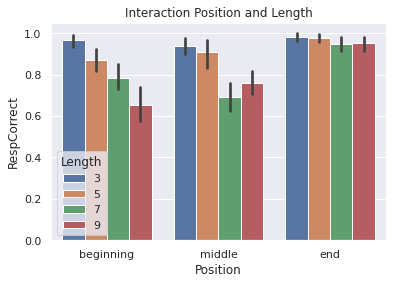

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'RespCorrect', hue = 'Length',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Length');

In [ ]:
print('Beginning') 
print('Length 3 vs 5')
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 5][['RespCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['RespCorrect']].values
y = subset[subset['Length'] == 7][['RespCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['RespCorrect']].values
y = subset[subset['Length'] == 9][['RespCorrect']].values
print(ttest(x,y))
print('Length 3 vs 7')
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 7][['RespCorrect']].values
print(ttest(x,y))

In [ ]:
print('Middle') 
print('Length 3 vs 5')
subset = position_ieeg[position_ieeg['Position'] == 2]
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 5][['RespCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['RespCorrect']].values
y = subset[subset['Length'] == 7][['RespCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['RespCorrect']].values
y = subset[subset['Length'] == 9][['RespCorrect']].values
print(ttest(x,y))
print('Length 3 vs 9')
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 9][['RespCorrect']].values
print(ttest(x,y))

In [ ]:
print('End') 
print('Length 3 vs 5')
subset = position_ieeg[position_ieeg['Position'] == 3]
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 5][['RespCorrect']].values
print(ttest(x,y))
print('Length 5 vs 7')
x = subset[subset['Length'] == 5][['RespCorrect']].values
y = subset[subset['Length'] == 7][['RespCorrect']].values
print(ttest(x,y))
print('Length 7 vs 9')
x = subset[subset['Length'] == 7][['RespCorrect']].values
y = subset[subset['Length'] == 9][['RespCorrect']].values
print(ttest(x,y))
print('Length 3 vs 7')
x = subset[subset['Length'] == 3][['RespCorrect']].values
y = subset[subset['Length'] == 7][['RespCorrect']].values
print(ttest(x,y))

End
Length 3 vs 5
Ttest_indResult(statistic=array([0.39526396]), pvalue=array([0.69285595]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.46794783]), pvalue=array([0.14340712]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.15308282]), pvalue=array([0.87844685]))
Length 3 vs 7
Ttest_indResult(statistic=array([1.74040399]), pvalue=array([0.083086]))


In [ ]:
print('Length')
print('List 3')
subset = position_ieeg[position_ieeg['Length'] == 3]
print('Position beginning vs middle')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))
print('Position middle vs end')
x = subset[subset['Position'] == 2][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))
print('Position beginning vs end')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('List 5')
subset = position_ieeg[position_ieeg['Length'] == 5]
print('Position beginning vs middle')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))
print('Position middle vs end')
x = subset[subset['Position'] == 2][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))
print('Position beginning vs end')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('List 7')
subset = position_ieeg[position_ieeg['Length'] == 7]
print('Position beginning vs middle')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))
print('Position middle vs end')
x = subset[subset['Position'] == 2][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))
print('Position beginning vs end')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

print('List 9')
subset = position_ieeg[position_ieeg['Length'] == 9]
print('Position beginning vs middle')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 2][['RespCorrect']].values
print(ttest(x,y))
print('Position middle vs end')
x = subset[subset['Position'] == 2][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))
print('Position beginning vs end')
x = subset[subset['Position'] == 1][['RespCorrect']].values
y = subset[subset['Position'] == 3][['RespCorrect']].values
print(ttest(x,y))

Length
List 3
Position beginning vs middle
Ttest_indResult(statistic=array([1.13240128]), pvalue=array([0.25838417]))
Position middle vs end
Ttest_indResult(statistic=array([-2.14225552]), pvalue=array([0.03319766]))
Position beginning vs end
Ttest_indResult(statistic=array([-1.00497318]), pvalue=array([0.31589082]))
List 5
Position beginning vs middle
Ttest_indResult(statistic=array([-0.86615246]), pvalue=array([0.38795419]))
Position middle vs end
Ttest_indResult(statistic=array([-1.88157676]), pvalue=array([0.06385978]))
Position beginning vs end
Ttest_indResult(statistic=array([-3.91931015]), pvalue=array([0.00011966]))
List 7
Position beginning vs middle
Ttest_indResult(statistic=array([1.98484034]), pvalue=array([0.04795721]))
Position middle vs end
Ttest_indResult(statistic=array([-6.51770302]), pvalue=array([3.71961444e-10]))
Position beginning vs end
Ttest_indResult(statistic=array([-4.50833712]), pvalue=array([9.74493804e-06]))
List 9
Position beginning vs middle
Ttest_indRes

**Reaction Time**

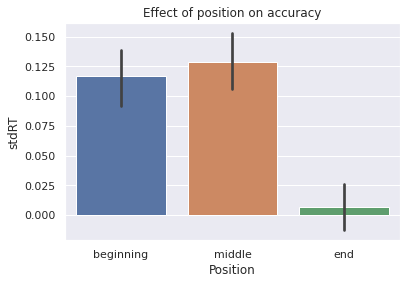

In [ ]:
pl.figure()
fig = sns.barplot(position_ieeg['Position'], position_ieeg['stdRT'])
fig.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Effect of position on accuracy');

In [ ]:
print('Ttest for position 1 vs 2')
x, y = position_ieeg[position_ieeg['Position'] == 1][['stdRT']].values, position_ieeg[position_ieeg['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3')
x, y = position_ieeg[position_ieeg['Position'] == 2][['stdRT']].values, position_ieeg[position_ieeg['Position'] == 3][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3')
x, y = position_ieeg[position_ieeg['Position'] == 1][['stdRT']].values, position_ieeg[position_ieeg['Position'] == 3][['stdRT']].values
print(ttest(x,y))

Ttest for position 1 vs 2
Ttest_indResult(statistic=array([-0.71481866]), pvalue=array([0.47485695]))
Ttest for position 2 vs 3
Ttest_indResult(statistic=array([7.58944554]), pvalue=array([6.23251271e-14]))
Ttest for position 1 vs 3
Ttest_indResult(statistic=array([6.93538649]), pvalue=array([6.43570587e-12]))


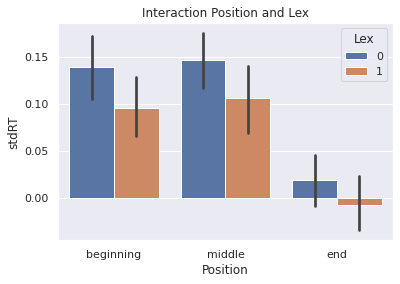

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'stdRT', hue = 'Lex',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Lex');

In [ ]:
print('WORDS')
print('Ttest for position 1 vs 2 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 3][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Words')
subset = position_ieeg[position_ieeg['Lex'] == 1]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 3][['stdRT']].values
print(ttest(x,y))

print('NON WORDS')
print('Ttest for position 1 vs 2 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 3][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Non-Words')
subset = position_ieeg[position_ieeg['Lex'] == 0]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 3][['stdRT']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 1]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x,y))

print('Position 2 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 2]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x,y))

print('Position 3 W vs NW')
subset = position_ieeg[position_ieeg['Position'] == 3]
x, y = subset[subset['Lex'] == 0][['stdRT']].values, subset[subset['Lex'] == 1][['stdRT']].values
print(ttest(x,y))

WORDS
Ttest for position 1 vs 2 Words
Ttest_indResult(statistic=array([-0.43488861]), pvalue=array([0.66381048]))
Ttest for position 2 vs 3 Words
Ttest_indResult(statistic=array([-4.71659252]), pvalue=array([3.0486593e-06]))
Ttest for position 1 vs 3 Words
Ttest_indResult(statistic=array([4.52394544]), pvalue=array([7.27002213e-06]))
NON WORDS
Ttest for position 1 vs 2 Non-Words
Ttest_indResult(statistic=array([-0.31909395]), pvalue=array([0.74975958]))
Ttest for position 2 vs 3 Non-Words
Ttest_indResult(statistic=array([-5.92361151]), pvalue=array([4.91740775e-09]))
Ttest for position 1 vs 3 Non-Words
Ttest_indResult(statistic=array([5.44504003]), pvalue=array([7.41782775e-08]))
POSITION
Position 1 W vs NW
Ttest_indResult(statistic=array([1.84825275]), pvalue=array([0.06504699]))
Position 2 W vs NW
Ttest_indResult(statistic=array([1.6486037]), pvalue=array([0.0997767]))
Position 3 W vs NW
Ttest_indResult(statistic=array([1.22747904]), pvalue=array([0.22007405]))


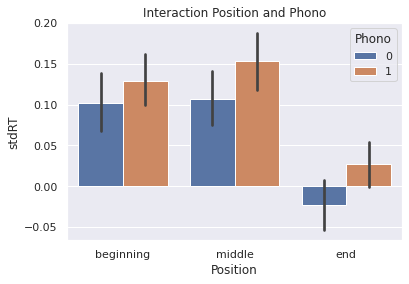

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'stdRT', hue = 'Phono',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Phono');

In [ ]:
print('LOW')
print('Ttest for position 1 vs 2 Low')
subset = position_ieeg[position_ieeg['Phono'] == 1]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 Low')
x, y = subset[subset['Position'] == 3][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 Low')
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 3][['stdRT']].values
print(ttest(x,y))

print('HIGH')
print('Ttest for position 1 vs 2 High')
subset = position_ieeg[position_ieeg['Phono'] == 0]
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 2 vs 3 High')
x, y = subset[subset['Position'] == 3][['stdRT']].values, subset[subset['Position'] == 2][['stdRT']].values
print(ttest(x,y))

print('Ttest for position 1 vs 3 High')
x, y = subset[subset['Position'] == 1][['stdRT']].values, subset[subset['Position'] == 3][['stdRT']].values
print(ttest(x,y))

print('POSITION')
print('Position 1 L vs H')
subset = position_ieeg[position_ieeg['Position'] == 1]
x, y = subset[subset['Phono'] == 0][['stdRT']].values, subset[subset['Phono'] == 1][['stdRT']].values
print(ttest(x,y))

print('Position 2 L vs H')
subset = position_ieeg[position_ieeg['Position'] == 2]
x, y = subset[subset['Phono'] == 0][['stdRT']].values, subset[subset['Phono'] == 1][['stdRT']].values
print(ttest(x,y))

print('Position 3 L vs H')
subset = position_ieeg[position_ieeg['Position'] == 3]
x, y = subset[subset['Phono'] == 0][['stdRT']].values, subset[subset['Phono'] == 1][['stdRT']].values
print(ttest(x,y))

LOW
Ttest for position 1 vs 2 Low
Ttest_indResult(statistic=array([-1.04847223]), pvalue=array([0.2948377]))
Ttest for position 2 vs 3 Low
Ttest_indResult(statistic=array([-5.6520622]), pvalue=array([2.44675198e-08]))
Ttest for position 1 vs 3 Low
Ttest_indResult(statistic=array([4.77961894]), pvalue=array([2.13012274e-06]))
HIGH
Ttest for position 1 vs 2 High
Ttest_indResult(statistic=array([-0.23999602]), pvalue=array([0.81041686]))
Ttest for position 2 vs 3 High
Ttest_indResult(statistic=array([-5.65115296]), pvalue=array([2.4495758e-08]))
Ttest for position 1 vs 3 High
Ttest_indResult(statistic=array([5.27034089]), pvalue=array([1.96692473e-07]))
POSITION
Position 1 L vs H
Ttest_indResult(statistic=array([-1.15996142]), pvalue=array([0.24653545]))
Position 2 L vs H
Ttest_indResult(statistic=array([-1.91971596]), pvalue=array([0.05536255]))
Position 3 L vs H
Ttest_indResult(statistic=array([-2.34956514]), pvalue=array([0.01910009]))


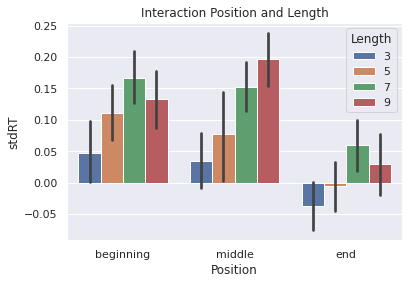

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Position', y = 'stdRT', hue = 'Length',
    data = position_ieeg
    )
ax.set_xticklabels(['beginning', 'middle', 'end'])
pl.title('Interaction Position and Length');

## Models with position

In [ ]:
%%R -i position_ieeg
comp1<-lmer('RespCorrect ~ Lex + Position + Length + Length:Position + (1|Subject)', data=position_ieeg)
comp2<-lmer('RespCorrect ~ Lex + Position + Length + Length:Position + Length:Lex + (1|Subject)', data=position_ieeg)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 1073.080 1112.011 -529.5399 1059.080       NA NA         NA
2    8 1074.044 1118.537 -529.0218 1058.044 1.036222  1  0.3087019


In [ ]:
modd = Lmer(
    'RespCorrect ~ Lex + Position + Length + Length:Position + (1|Subject)',
    data = position_ieeg
)
modd.fit()

Formula: RespCorrect~Lex+Position+Length+Length:Position+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1923	 Groups: {'Subject': 26.0}

Log-likelihood: -549.390 	 AIC: 1098.781

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.004  0.063
Residual               0.100  0.316

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)         1.193   1.079    1.307  0.058  1619.239  20.523  0.000   
Lex                -0.030  -0.058   -0.001  0.015  1903.354  -2.052  0.040   
Position           -0.058  -0.108   -0.008  0.025  1896.911  -2.289  0.022   
Length             -0.075  -0.093   -0.058  0.009  1895.261  -8.392  0.000   
Position:Length     0.021   0.013    0.029  0.004  1895.746   5.169  0.000   

                 Sig  
(Intercept)      ***  
Lex                *  
Position           *  
Length           ***  
Position:Length  ***

### Uniting datasets

In [ ]:
print(eeg_no_trials.shape)
print(ieeg_no_outliers.shape)

(5468, 24)
(4207, 19)


In [ ]:
eeg_no_trials.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
       'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
       'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx',
       'CorrPercentage', 'Position', 'Length', 'stdRT', 'Lex', 'Phono',
       'Position1', 'Position2'],
      dtype='object')

In [ ]:
ieeg_no_outliers.columns

Index(['Trial', 'Subject', 'block', 'ProbeType', 'probeSound_idx',
       'ProbeTypeName', 'StimlusCategory', 'ReactionTime', 'KeyCode', 'Resp',
       'RespCorrect', 'Omission', 'ProbeCategory', 'stimulusSounds_idx',
       'Position', 'Length', 'Lex', 'Phono', 'stdRT'],
      dtype='object')

### Accuracy plots 

In [ ]:
toplot = eeg_no_trials.groupby(['Subject', 'Lex'])[['ResponseCorrect']].mean().reset_index()

In [ ]:
words = []
nonwords = []
lex_1 = toplot[toplot['Lex'] == 1][['ResponseCorrect']].values
lex_0 = toplot[toplot['Lex'] == 0][['ResponseCorrect']].values
for i in lex_1:
  words.append(i[0])
for i in lex_0:
  nonwords.append(i[0])

In [ ]:
a, b = np.polyfit(
    words, nonwords, 1
    )
y = []
for i in words:
  y.append(a*i + b)
print(len(y))

29


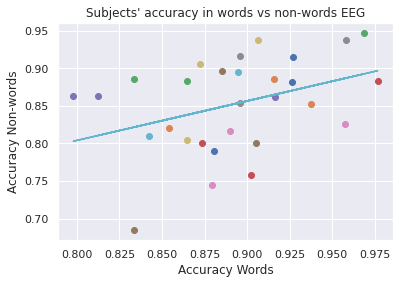

In [ ]:
pl.figure()
for i in toplot.Subject.unique():
  subset = toplot[toplot['Subject'] == i]
  pl.plot(
      subset[subset['Lex'] == 1][['ResponseCorrect']],
      subset[subset['Lex'] == 0][['ResponseCorrect']],
      'o', label = i
  )
pl.plot(
    words, y
    )
pl.xlabel('Accuracy Words')
pl.ylabel('Accuracy Non-words')
pl.title("Subjects' accuracy in words vs non-words EEG");
#pl.legend();

In [ ]:
toplot_i = ieeg_no_outliers.groupby(['Subject', 'Lex'])[['RespCorrect']].mean().reset_index()

In [ ]:
toplot_i.head()

Subject  Lex  RespCorrect
0     D23    0     0.826667
1     D23    1     0.820513
2     D26    0     0.937500
3     D26    1     0.949367
4     D27    0     0.734177

In [ ]:
words_i = []
nonwords_i = []
lex_1_i = toplot_i[toplot_i['Lex'] == 1][['RespCorrect']].values
lex_0_i = toplot_i[toplot_i['Lex'] == 0][['RespCorrect']].values
for i in lex_1_i:
  words_i.append(i[0])
for i in lex_0_i:
  nonwords_i.append(i[0])

In [ ]:
a_, b_ = np.polyfit(
    words_i, nonwords_i, 1
    )
y_ = []
for i in words_i:
  y_.append(a_*i + b_)
print(len(y_))

27


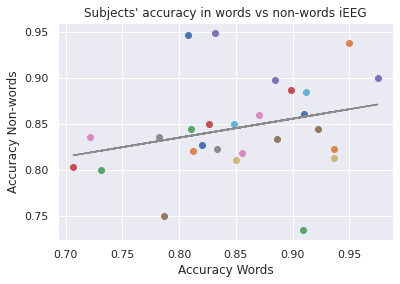

In [ ]:
pl.figure()
for i in toplot_i.Subject.unique():
  subset = toplot_i[toplot_i['Subject'] == i]
  pl.plot(
      subset[subset['Lex'] == 1][['RespCorrect']],
      subset[subset['Lex'] == 0][['RespCorrect']],
      'o', label = i
  )
pl.plot(
    words_i, y_
    )
pl.xlabel('Accuracy Words')
pl.ylabel('Accuracy Non-words')
pl.title("Subjects' accuracy in words vs non-words iEEG");
#pl.legend();

2nd option

In [ ]:
x = []
subjs = []
words = []
non_words = []
for i in eeg_no_trials.Subject.unique():
  subset = eeg_no_trials[eeg_no_trials['Subject'] == i]
  x.append(subset.ResponseCorrect.mean())
  subjs.append(i)
  words.append(subset[subset['Lex'] == 1][['ResponseCorrect']].values.mean())
  non_words.append(subset[subset['Lex'] == 0][['ResponseCorrect']].values.mean())

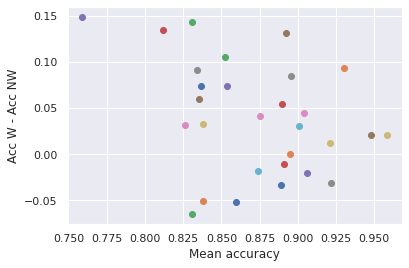

In [ ]:
pl.figure()
for i in range(0, len(subjs)):
  pl.plot(x[i], words[i] - non_words[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc W - Acc NW');

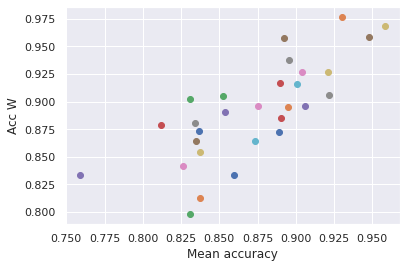

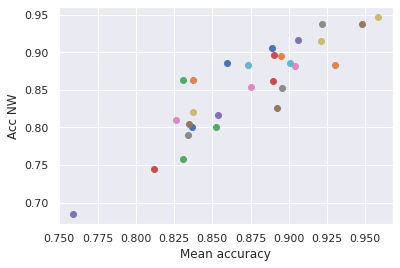

In [ ]:
pl.figure()
for i in range(0, len(subjs)):
  pl.plot(x[i], words[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc W');

pl.figure()
for i in range(0, len(subjs)):
  pl.plot(x[i], non_words[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc NW');

In [ ]:
# iEEG
x_ = []
subjs_ = []
words_ = []
non_words_ = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  x_.append(subset.RespCorrect.mean())
  subjs_.append(i)
  words_.append(subset[subset['Lex'] == 1][['RespCorrect']].mean())
  non_words_.append(subset[subset['Lex'] == 0][['RespCorrect']].mean())

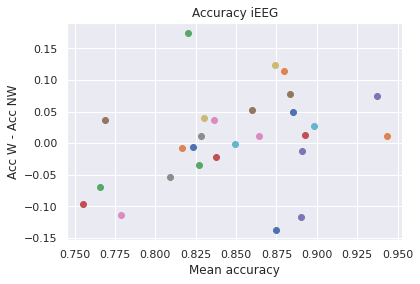

In [ ]:
pl.figure()
for i in range(0, len(subjs_)):
  pl.plot(x_[i], words_[i] - non_words_[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc W - Acc NW')
pl.title('Accuracy iEEG');

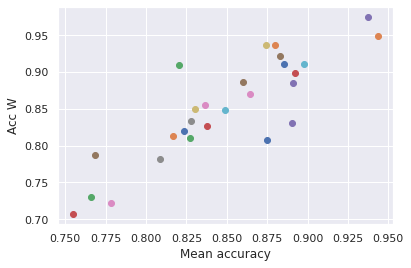

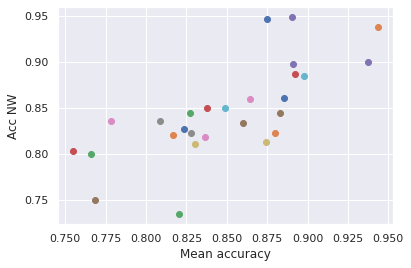

In [ ]:
pl.figure()
for i in range(0, len(subjs_)):
  pl.plot(x_[i], words_[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc W');

pl.figure()
for i in range(0, len(subjs_)):
  pl.plot(x_[i], non_words_[i], 'o')
pl.xlabel('Mean accuracy')
pl.ylabel('Acc NW');

Correlation map of lexical effect on acccuracy

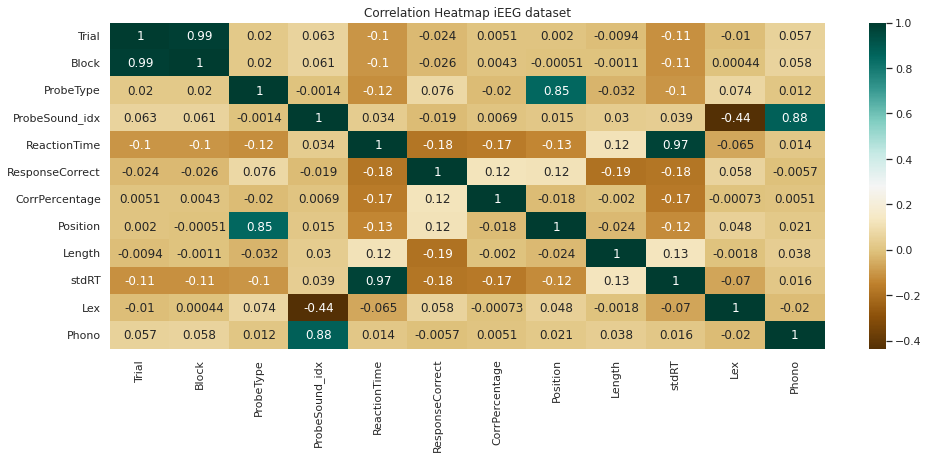

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_no_trials.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

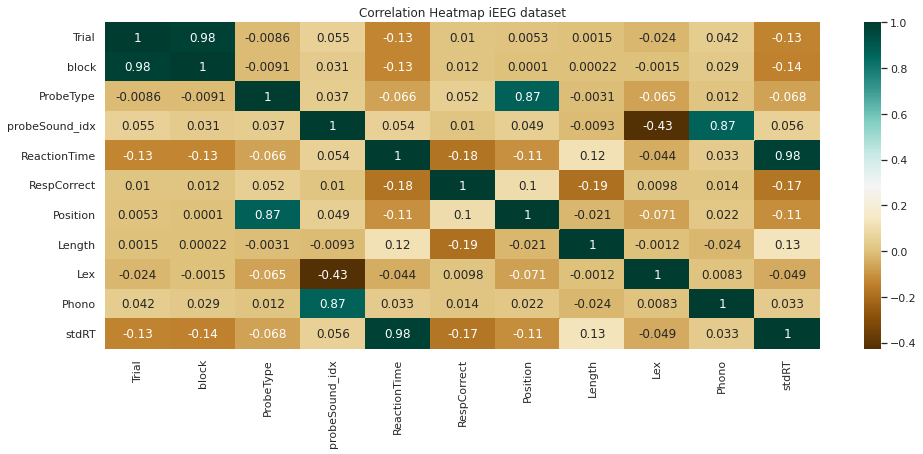

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_no_outliers.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

21
['E2', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E11', 'E12', 'E13', 'E15', 'E17', 'E21', 'E24', 'E25', 'E26', 'E27', 'E29', 'E30', 'E31', 'E33']


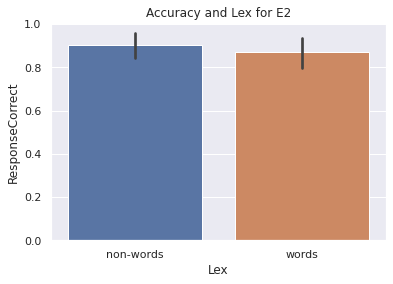

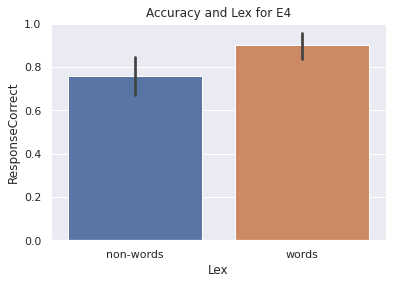

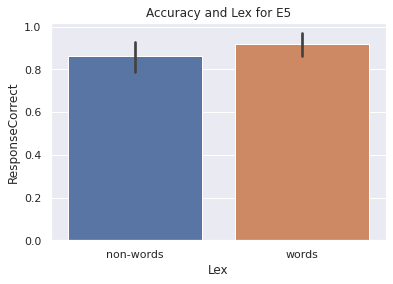

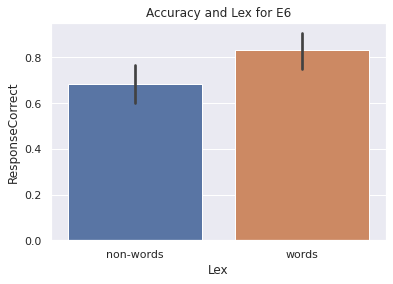

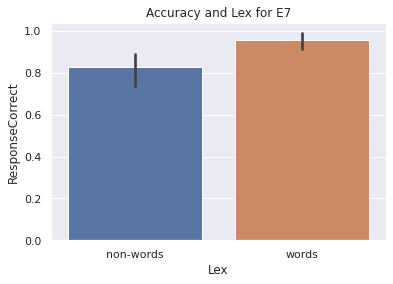

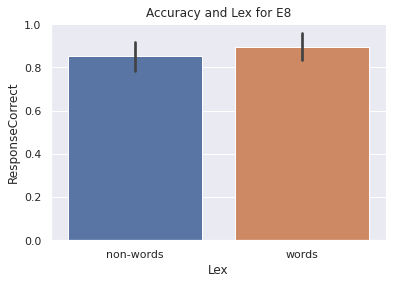

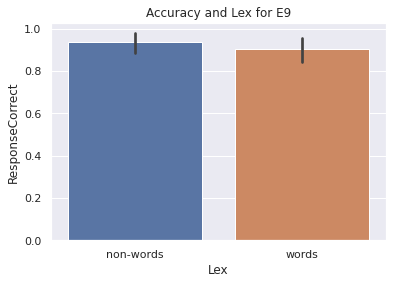

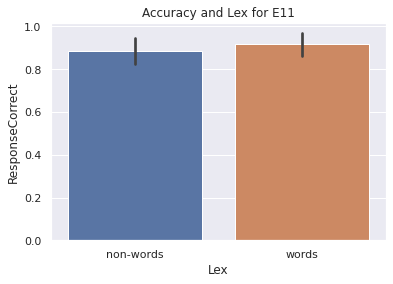

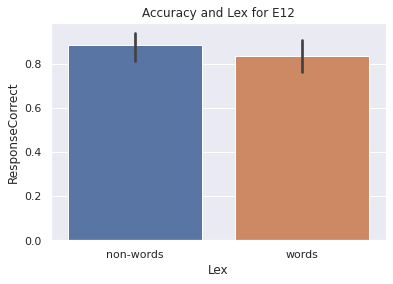

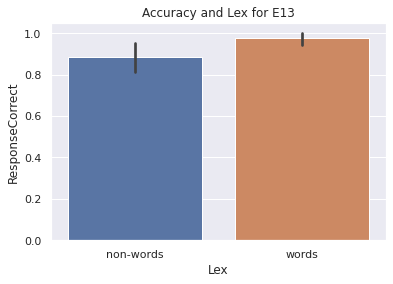

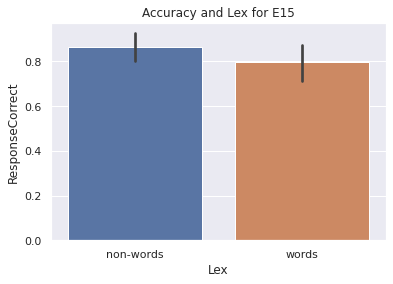

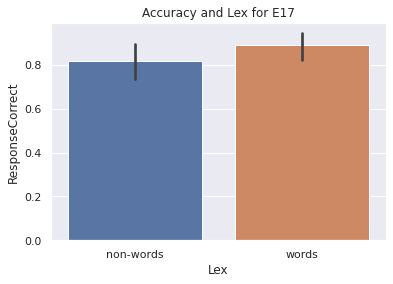

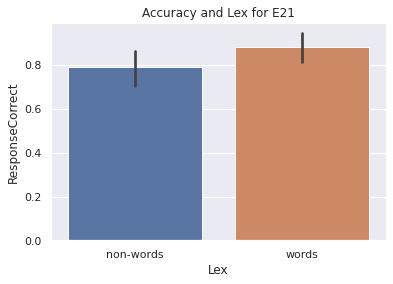

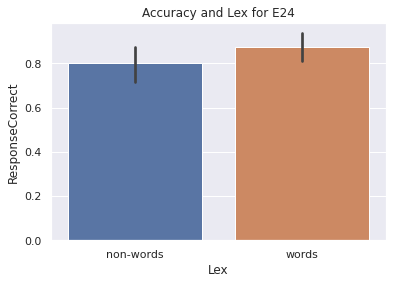

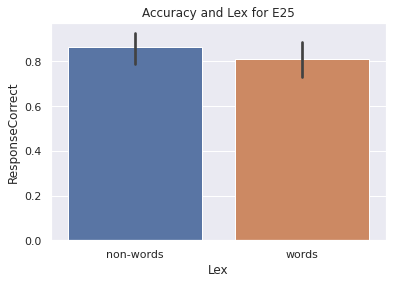

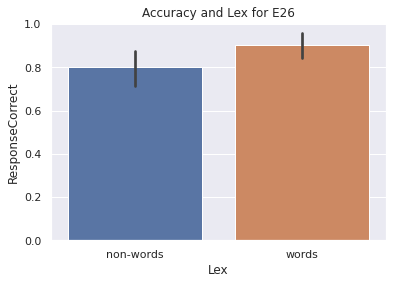

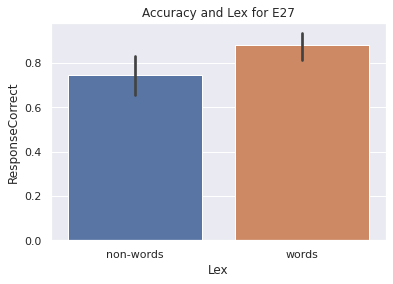

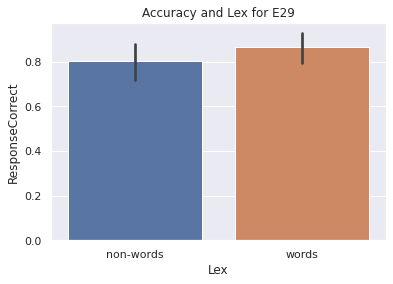

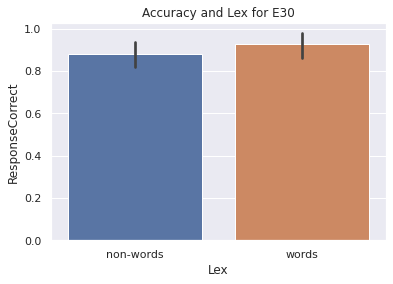

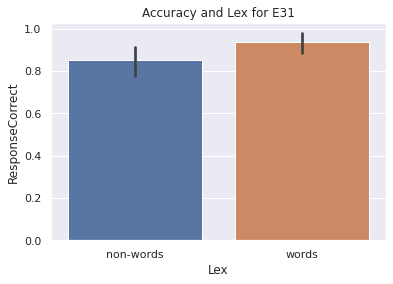

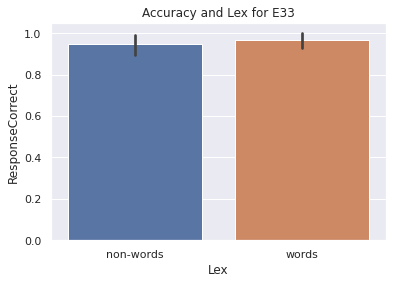

In [ ]:
sign_subjs = []
for i in eeg_no_trials.Subject.unique():
  subset = eeg_no_trials[eeg_no_trials['Subject'] == i]
  x, y = subset[subset['Lex'] == 0][['ResponseCorrect']].values, subset[subset['Lex'] == 1][['ResponseCorrect']].values
  if ttest(x,y)[1] < 0.5:
    sign_subjs.append(i)
    pl.figure()
    ax = sns.barplot(
        'Lex', 'ResponseCorrect', data = subset
        )
    ax.set_xticklabels(['non-words', 'words'])
    pl.title('Accuracy and Lex for ' + i);
print(len(sign_subjs))
print(sign_subjs)

13
['D27', 'D29', 'D34', 'D35', 'D38', 'D39', 'D41', 'D48', 'D63', 'D70', 'D71', 'D72', 'D73']


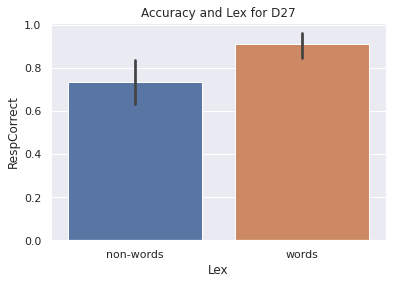

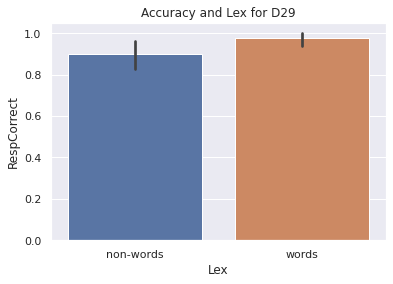

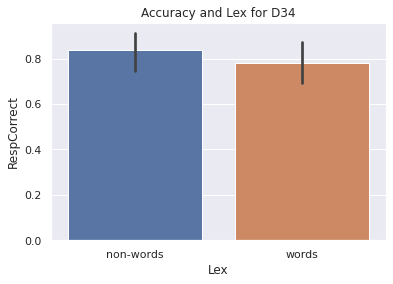

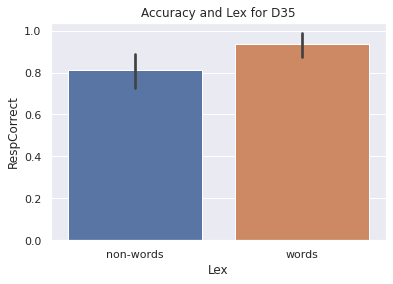

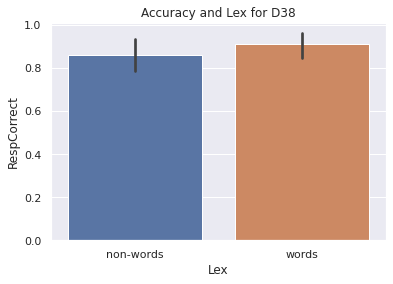

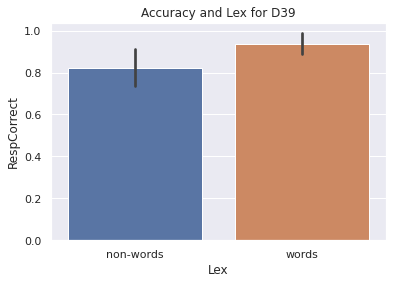

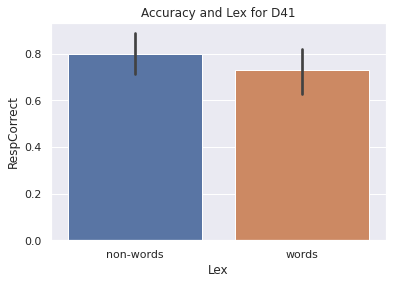

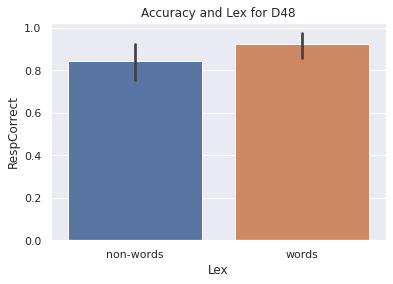

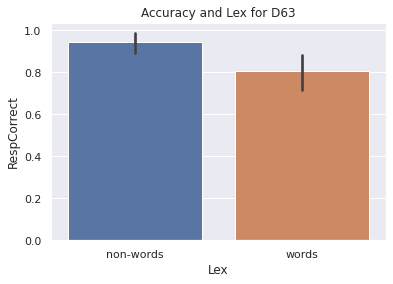

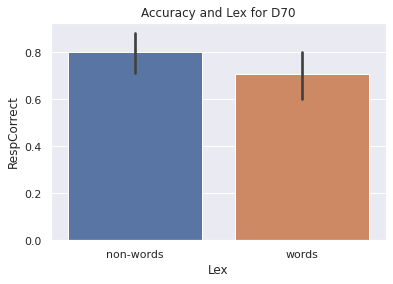

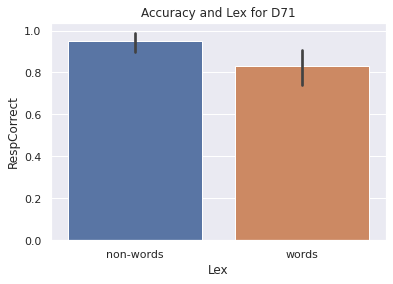

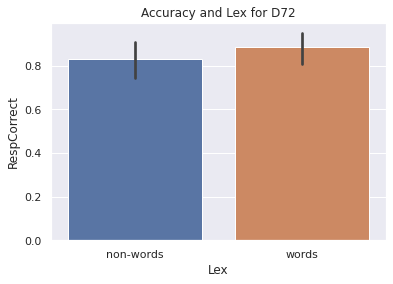

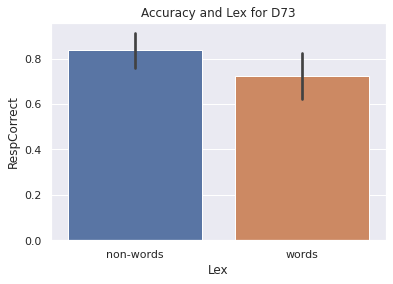

In [ ]:
sign_subjs = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  x, y = subset[subset['Lex'] == 0][['RespCorrect']].values, subset[subset['Lex'] == 1][['RespCorrect']].values
  if ttest(x,y)[1] < 0.5:
    sign_subjs.append(i)
    pl.figure()
    ax = sns.barplot(
        'Lex', 'RespCorrect', data = subset
        )
    ax.set_xticklabels(['non-words', 'words'])
    pl.title('Accuracy and Lex for ' + i);
print(len(sign_subjs))
print(sign_subjs)

### Slow/fast performers

**Accuracy**

**EEG**

In [ ]:
slow = []
fast = []
slow_fast = eeg_no_trials.groupby(['Subject'])[['ReactionTime']].mean().reset_index()
mean_rt = slow_fast.ReactionTime.mean()
for i in slow_fast.Subject.values:
  if slow_fast[slow_fast['Subject'] == i][['ReactionTime']].values > mean_rt:
    slow.append(i)
  else:
    fast.append(i)

In [ ]:
slowfast = []
subjs = eeg_no_trials.Subject.values
for i in subjs:
  if i in slow:
    slowfast.append(0)
  elif i in fast:
    slowfast.append(1)

In [ ]:
eeg_no_trials['Speed'] = slowfast

In [ ]:
eeg_no_trials.groupby(['Speed'])[['Trial']].count()

Trial
Speed       
0       2421
1       3047

Significant difference [0.19509035]


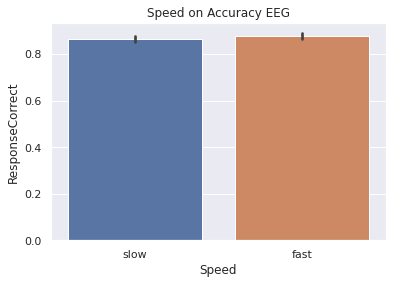

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ResponseCorrect', data = eeg_no_trials
    );
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed on Accuracy EEG');

x, y = eeg_no_trials[eeg_no_trials['Speed'] == 0][['ResponseCorrect']], eeg_no_trials[eeg_no_trials['Speed'] == 1][['ResponseCorrect']]
if ttest(x,y)[1] < 0.5:
  print('Significant difference', ttest(x,y)[1])
else:
  print('Not significant' + ttest(x,y)[1])

Fast
Ttest_indResult(statistic=array([1.77426449]), pvalue=array([0.07611995]))
Slow
Ttest_indResult(statistic=array([4.45241705]), pvalue=array([8.89272498e-06]))
Words
Ttest_indResult(statistic=array([-0.69704646]), pvalue=array([0.48583506]))
Non-words
Ttest_indResult(statistic=array([2.33049504]), pvalue=array([0.01986016]))


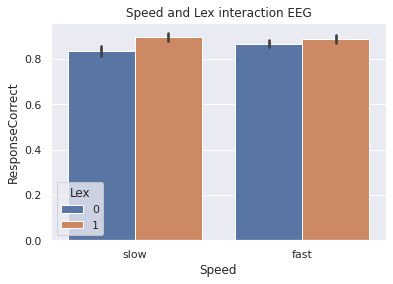

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ResponseCorrect', hue = 'Lex',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Lex interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['Lex'] == 1][['ResponseCorrect']], subset[subset['Lex'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['Lex'] == 1][['ResponseCorrect']], subset[subset['Lex'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Non-words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([0.12965452]), pvalue=array([0.89684833]))
Slow
Ttest_indResult(statistic=array([-8.50066068]), pvalue=array([3.55513515e-17]))
Mismatch
Ttest_indResult(statistic=array([5.08763993]), pvalue=array([3.92171178e-07]))
Match
Ttest_indResult(statistic=array([-4.07749894]), pvalue=array([4.68140688e-05]))


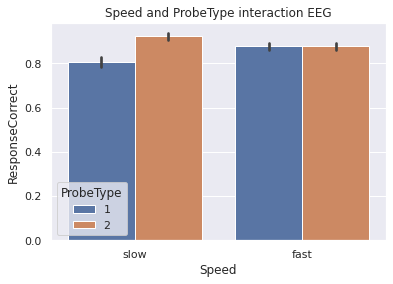

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ResponseCorrect', hue = 'ProbeType',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and ProbeType interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ResponseCorrect']], subset[subset['ProbeType'] == 2][['ResponseCorrect']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ResponseCorrect']], subset[subset['ProbeType'] == 2][['ResponseCorrect']]
print(ttest(x,y))
print('Mismatch')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Match')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([-0.33925896]), pvalue=array([0.73443818]))
Slow
Ttest_indResult(statistic=array([-0.25404474]), pvalue=array([0.79948269]))
Low
Ttest_indResult(statistic=array([0.87692761]), pvalue=array([0.38061103]))
High
Ttest_indResult(statistic=array([0.95435762]), pvalue=array([0.33999076]))


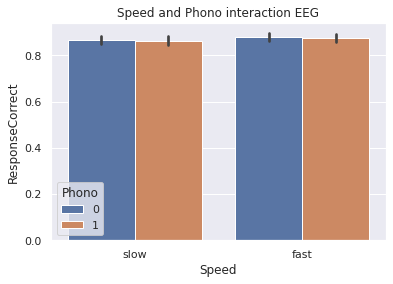

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ResponseCorrect', hue = 'Phono',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Phono interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['Phono'] == 1][['ResponseCorrect']], subset[subset['Phono'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['Phono'] == 1][['ResponseCorrect']], subset[subset['Phono'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Low')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 1]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('High')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 0]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Fast
Length 3 vs 5
Ttest_indResult(statistic=array([6.43457469]), pvalue=array([1.81093468e-10]))
Length 5 vs 7
Ttest_indResult(statistic=array([-2.55088162]), pvalue=array([0.01084445]))
Length 7 vs 9
Ttest_indResult(statistic=array([2.23161178]), pvalue=array([0.02578705]))

Slow
Length 3 vs 5
Ttest_indResult(statistic=array([7.08943131]), pvalue=array([2.87529885e-12]))
Length 5 vs 7
Ttest_indResult(statistic=array([-2.22323107]), pvalue=array([0.02638663]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.45410981]), pvalue=array([0.14617595]))

Length 3
Ttest_indResult(statistic=array([-0.52134498]), pvalue=array([0.60221301]))
Length 5
Ttest_indResult(statistic=array([1.10389438]), pvalue=array([0.26985225]))
Length 7
Ttest_indResult(statistic=array([1.05055149]), pvalue=array([0.2936639]))
Length 9
Ttest_indResult(statistic=array([0.48433501]), pvalue=array([0.62823071]))


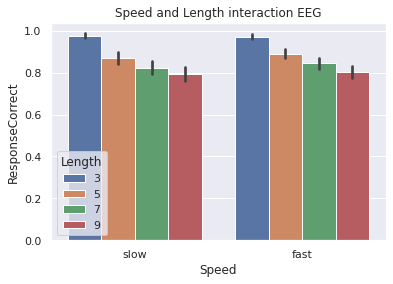

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ResponseCorrect', hue = 'Length',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Length interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 9][['ResponseCorrect']]
print(ttest(x,y))
print('')
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 9][['ResponseCorrect']]
print(ttest(x,y))
print('')
print('Length 3')
subset = eeg_no_trials[eeg_no_trials['Length'] == 3]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5')
subset = eeg_no_trials[eeg_no_trials['Length'] == 5]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7')
subset = eeg_no_trials[eeg_no_trials['Length'] == 7]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 9')
subset = eeg_no_trials[eeg_no_trials['Length'] == 9]
x, y = subset[subset['Speed'] == 1][['ResponseCorrect']], subset[subset['Speed'] == 0][['ResponseCorrect']]
print(ttest(x,y))

**iEEG**

In [ ]:
slow = []
fast = []
slow_fast = ieeg_no_outliers.groupby(['Subject'])[['ReactionTime']].mean().reset_index()
mean_rt = slow_fast.ReactionTime.mean()
for i in slow_fast.Subject.values:
  if slow_fast[slow_fast['Subject'] == i][['ReactionTime']].values > mean_rt:
    slow.append(i)
  else:
    fast.append(i)

In [ ]:
slowfast = []
subjs = ieeg_no_outliers.Subject.values
for i in subjs:
  if i in slow:
    slowfast.append(0)
  elif i in fast:
    slowfast.append(1)

In [ ]:
ieeg_no_outliers['Speed'] = slowfast

In [ ]:
ieeg_no_outliers.groupby(['Speed'])[['Trial']].count()

Trial
Speed       
0       1712
1       2495

Significant difference [0.01214258]


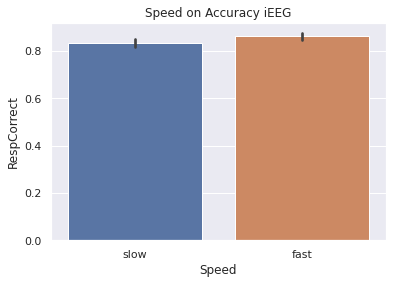

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'RespCorrect', data = ieeg_no_outliers
    );
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed on Accuracy iEEG');

x, y = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0][['RespCorrect']], ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1][['RespCorrect']]
if ttest(x,y)[1] < 0.5:
  print('Significant difference', ttest(x,y)[1])
else:
  print('Not significant' + ttest(x,y)[1])

Fast
Ttest_indResult(statistic=array([1.8500163]), pvalue=array([0.06443027]))
Slow
Ttest_indResult(statistic=array([-1.12128485]), pvalue=array([0.26232447]))
Words
Ttest_indResult(statistic=array([3.19602072]), pvalue=array([0.00141957]))
Non-words
Ttest_indResult(statistic=array([0.34798526]), pvalue=array([0.72789144]))


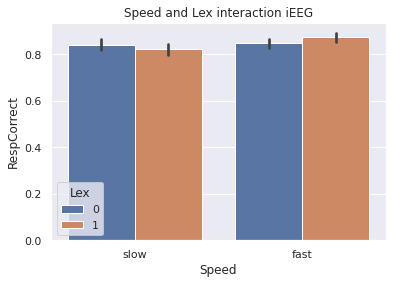

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'RespCorrect', hue = 'Lex',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Lex interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['Lex'] == 1][['RespCorrect']], subset[subset['Lex'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['Lex'] == 1][['RespCorrect']], subset[subset['Lex'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Non-words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([-2.21500256]), pvalue=array([0.02685023]))
Slow
Ttest_indResult(statistic=array([-2.46322251]), pvalue=array([0.01386781]))
Mismatch
Ttest_indResult(statistic=array([2.0636396]), pvalue=array([0.03918654]))
Match
Ttest_indResult(statistic=array([1.28189153]), pvalue=array([0.20006864]))


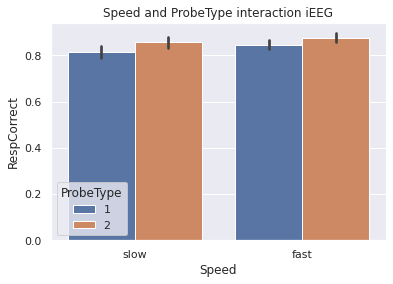

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'RespCorrect', hue = 'ProbeType',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and ProbeType interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['ProbeType'] == 1][['RespCorrect']], subset[subset['ProbeType'] == 2][['RespCorrect']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['ProbeType'] == 1][['RespCorrect']], subset[subset['ProbeType'] == 2][['RespCorrect']]
print(ttest(x,y))
print('Mismatch')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Match')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([0.88282137]), pvalue=array([0.37741937]))
Slow
Ttest_indResult(statistic=array([0.4645647]), pvalue=array([0.64230516]))
Low
Ttest_indResult(statistic=array([1.99866847]), pvalue=array([0.04578528]))
High
Ttest_indResult(statistic=array([1.57360052]), pvalue=array([0.11578194]))


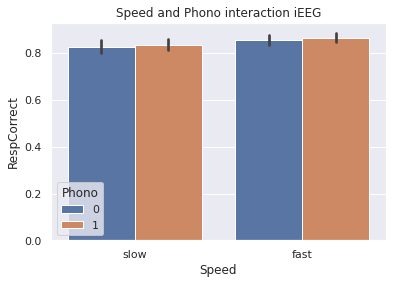

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'RespCorrect', hue = 'Phono',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Phono interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['Phono'] == 1][['RespCorrect']], subset[subset['Phono'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['Phono'] == 1][['RespCorrect']], subset[subset['Phono'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Low')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('High')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))

Fast
Length 3 vs 5
Ttest_indResult(statistic=array([3.51264539]), pvalue=array([0.00046104]))
Length 5 vs 7
Ttest_indResult(statistic=array([-3.39016933]), pvalue=array([0.00072115]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.82400105]), pvalue=array([0.06839283]))

Slow
Length 3 vs 5
Ttest_indResult(statistic=array([2.18029357]), pvalue=array([0.02952225]))
Length 5 vs 7
Ttest_indResult(statistic=array([-4.25262204]), pvalue=array([2.36181859e-05]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.19650727]), pvalue=array([0.23182995]))

Length 3
Ttest_indResult(statistic=array([1.12715171]), pvalue=array([0.25999901]))
Length 5
Ttest_indResult(statistic=array([0.3306231]), pvalue=array([0.74100679]))
Length 7
Ttest_indResult(statistic=array([1.90322294]), pvalue=array([0.05734375]))
Length 9
Ttest_indResult(statistic=array([1.56593577]), pvalue=array([0.11772204]))


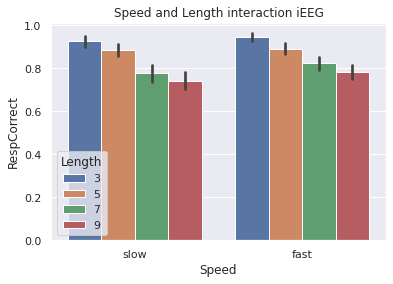

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'RespCorrect', hue = 'Length',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Length interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 9][['RespCorrect']]
print(ttest(x,y))
print('')
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 9][['RespCorrect']]
print(ttest(x,y))
print('')
print('Length 3')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 3]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 5]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 7]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 9]
x, y = subset[subset['Speed'] == 1][['RespCorrect']], subset[subset['Speed'] == 0][['RespCorrect']]
print(ttest(x,y))

**Models with speed variable**

In [ ]:
%%R -i eeg_no_trials
comp1<-lmer('ResponseCorrect ~ Lex + Length + ProbeType + Speed + ProbeType:Speed + Lex:ProbeType + Length:ProbeType + (1|Subject)', data=eeg_no_trials)
comp2<-lmer('ResponseCorrect ~ Lex + Length + ProbeType + Speed + ProbeType:Speed + Lex:ProbeType + Length:ProbeType + ProbeType:Speed:Lex + (1|Subject)', data=eeg_no_trials)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1   10 3192.925 3258.991 -1586.462 3172.925       NA NA         NA
2   11 3192.980 3265.653 -1585.490 3170.980 1.944669  1  0.1631625


In [ ]:
mod = Lmer(
    'ResponseCorrect ~ Lex + Length + ProbeType + Speed + ProbeType:Speed + Lex:ProbeType + Length:ProbeType + (1|Subject)',
    data = eeg_no_trials
)
mod.fit()

Formula: ResponseCorrect~Lex+Length+ProbeType+Speed+ProbeType:Speed+Lex:ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1617.387 	 AIC: 3234.773

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.323

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.895   0.805    0.985  0.046  2804.008  19.522  0.000   
Lex                  0.102   0.047    0.156  0.028  5434.081   3.673  0.000   
Length              -0.041  -0.053   -0.029  0.006  5442.286  -6.652  0.000   
ProbeType            0.082   0.027    0.138  0.028  5437.434   2.914  0.004   
Speed                0.190   0.128    0.251  0.031   324.116   6.069  0.000   
ProbeType:Speed     -0.118  -0.152   -0.083  0.018  5436.890  -6.706  0.000   
Lex:ProbeType       -0.044  -0.078   -0.010  0.018  5434.277  -2.504  0.012   
Length:ProbeType     0.008   0.001    0.016  0.004  5442.773   2.142  0.032   

                  Sig  
(Intercept)       ***  
Lex               ***  
Length            ***  
ProbeType          **  
Speed             ***  
ProbeType:Speed   ***  
Lex:ProbeType       *  
Length:ProbeType    *

In [ ]:
%%R -i ieeg_no_outliers
comp1<-lmer('RespCorrect ~ Length + ProbeType + Lex + Speed + Lex:ProbeType + Speed:Lex + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('RespCorrect ~ Length + ProbeType + Lex + Speed + Lex:ProbeType + Speed:Lex + Phono + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    9 3100.086 3157.187 -1541.043 3082.086        NA NA         NA
2   10 3101.929 3165.374 -1540.964 3081.929 0.1573994  1  0.6915622


In [ ]:
mod = Lmer(
    'RespCorrect ~ Length + ProbeType + Lex + Speed + Lex:ProbeType + Speed:Lex + (1|Subject)',
    data = ieeg_no_outliers
)
mod.fit()

Formula: RespCorrect~Length+ProbeType+Lex+Speed+Lex:ProbeType+Speed:Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4207	 Groups: {'Subject': 27.0}

Log-likelihood: -1566.068 	 AIC: 3132.135

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.039
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       0.901   0.839    0.964  0.032   547.910  28.207  0.000  ***
Length           -0.030  -0.034   -0.025  0.002  4175.430 -12.408  0.000  ***
ProbeType         0.079   0.050    0.109  0.015  4180.535   5.216  0.000  ***
Lex               0.114   0.044    0.184  0.036  4189.949   3.187  0.001   **
Speed             0.006  -0.037    0.048  0.022    44.779   0.270  0.788     
ProbeType:Lex    -0.089  -0.132   -0.047  0.022  4193.280  -4.124  0.000  ***
Lex:Speed         0.046   0.003    0.088  0.022  4175.298   2.083  0.037    *

**Reaction Time**

**EEG**

Ttest_indResult(statistic=array([-42.34459826]), pvalue=array([0.]))


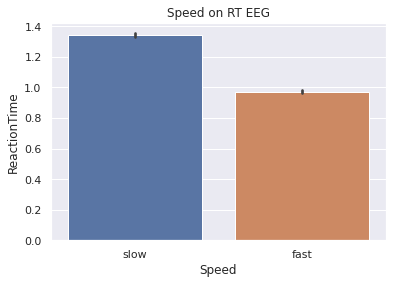

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed on RT EEG');

x, y = eeg_no_trials[eeg_no_trials['Speed'] == 1][['ReactionTime']], eeg_no_trials[eeg_no_trials['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([-5.08016505]), pvalue=array([4.00030016e-07]))
Slow
Ttest_indResult(statistic=array([-2.91061755]), pvalue=array([0.00364012]))
Words
Ttest_indResult(statistic=array([-31.12759]), pvalue=array([1.3459748e-178]))
Non-words
Ttest_indResult(statistic=array([-28.94697357]), pvalue=array([6.29714877e-159]))


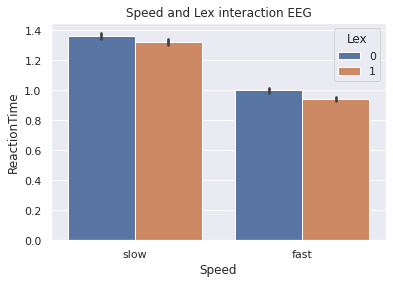

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Lex',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Lex interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Non-words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([1.41622559]), pvalue=array([0.15681207]))
Slow
Ttest_indResult(statistic=array([0.24389415]), pvalue=array([0.80733355]))
Low
Ttest_indResult(statistic=array([-29.03275375]), pvalue=array([1.10117385e-158]))
High
Ttest_indResult(statistic=array([-30.82665359]), pvalue=array([3.99353362e-177]))


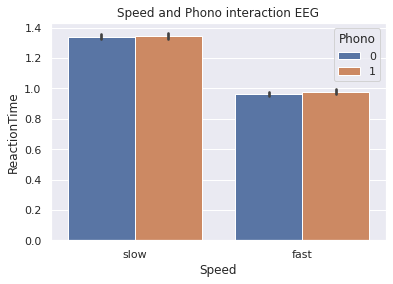

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Phono',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Phono interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Low')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('High')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 0]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([3.94255671]), pvalue=array([8.24731556e-05]))
Slow
Ttest_indResult(statistic=array([11.13452816]), pvalue=array([4.1515958e-28]))
Mismatch
Ttest_indResult(statistic=array([-32.98175325]), pvalue=array([9.02523373e-198]))
Match
Ttest_indResult(statistic=array([-27.88673356]), pvalue=array([7.15799156e-149]))


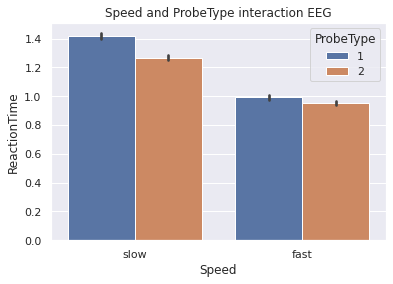

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'ProbeType',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and ProbeType interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Mismatch')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Match')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Length 3 vs 5
Ttest_indResult(statistic=array([-4.98403883]), pvalue=array([6.94082319e-07]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.77332799]), pvalue=array([0.07637462]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.86124935]), pvalue=array([0.38923658]))

Slow
Length 3 vs 5
Ttest_indResult(statistic=array([-5.2123364]), pvalue=array([2.19365999e-07]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.48771471]), pvalue=array([0.1370879]))
Length 7 vs 9
Ttest_indResult(statistic=array([0.1803648]), pvalue=array([0.85689635]))

Length 3
Ttest_indResult(statistic=array([-21.90854949]), pvalue=array([4.82957894e-90]))
Length 5
Ttest_indResult(statistic=array([-22.10052783]), pvalue=array([2.2899831e-91]))
Length 7
Ttest_indResult(statistic=array([-20.9978733]), pvalue=array([1.24935734e-83]))
Length 9
Ttest_indResult(statistic=array([-20.73307671]), pvalue=array([6.7604263e-82]))


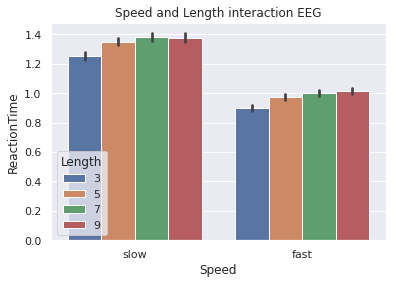

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Length',
    data = eeg_no_trials
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Length interaction EEG');

print('Fast')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Slow')
subset = eeg_no_trials[eeg_no_trials['Speed'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Length 3')
subset = eeg_no_trials[eeg_no_trials['Length'] == 3]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 5')
subset = eeg_no_trials[eeg_no_trials['Length'] == 5]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 7')
subset = eeg_no_trials[eeg_no_trials['Length'] == 7]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 9')
subset = eeg_no_trials[eeg_no_trials['Length'] == 9]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

**iEEG**

Ttest_indResult(statistic=array([30.02053058]), pvalue=array([5.88386993e-176]))


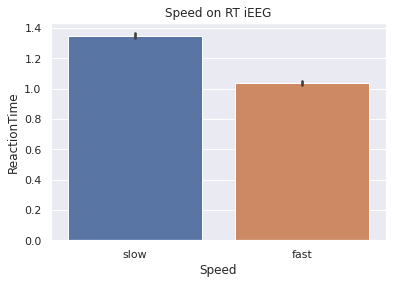

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed on RT iEEG');

x, y = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0][['ReactionTime']], ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([-2.76629006]), pvalue=array([0.00571163]))
Slow
Ttest_indResult(statistic=array([-1.61474496]), pvalue=array([0.10655043]))
Words
Ttest_indResult(statistic=array([-21.52513705]), pvalue=array([4.76267102e-91]))
Non-words
Ttest_indResult(statistic=array([-20.95479995]), pvalue=array([5.03548677e-87]))


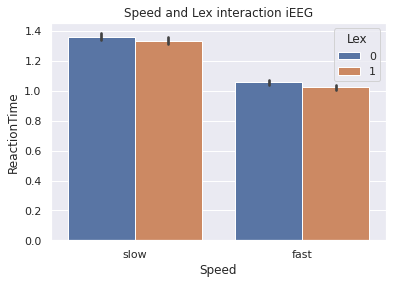

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Lex',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Lex interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Non-words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([0.28479201]), pvalue=array([0.77582757]))
Slow
Ttest_indResult(statistic=array([2.05592909]), pvalue=array([0.03994466]))
Low
Ttest_indResult(statistic=array([-22.94223599]), pvalue=array([1.08513737e-102]))
High
Ttest_indResult(statistic=array([-19.39399379]), pvalue=array([2.64137592e-75]))


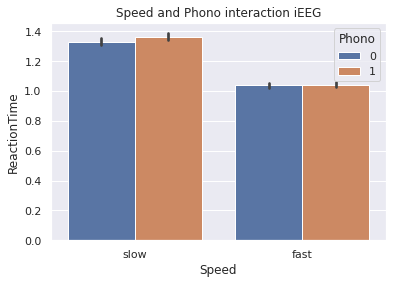

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Phono',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Phono interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Low')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('High')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Ttest_indResult(statistic=array([2.60637461]), pvalue=array([0.00920513]))
Slow
Ttest_indResult(statistic=array([2.64517657]), pvalue=array([0.00824117]))
Mismatch
Ttest_indResult(statistic=array([-21.87361365]), pvalue=array([1.088743e-94]))
Match
Ttest_indResult(statistic=array([-20.43208309]), pvalue=array([2.85573051e-82]))


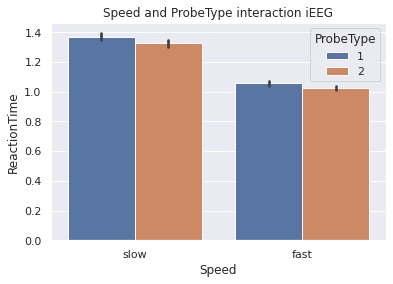

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'ProbeType',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and ProbeType interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Mismatch')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Match')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

Fast
Length 3 vs 5
Ttest_indResult(statistic=array([-3.41414006]), pvalue=array([0.00066044]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.78707034]), pvalue=array([0.07417032]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.69364598]), pvalue=array([0.48803427]))

Slow
Length 3 vs 5
Ttest_indResult(statistic=array([-2.87864944]), pvalue=array([0.00409464]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.1560001]), pvalue=array([0.24800821]))
Length 7 vs 9
Ttest_indResult(statistic=array([-1.54134261]), pvalue=array([0.123603]))

Length 3
Ttest_indResult(statistic=array([-14.99297282]), pvalue=array([2.02483912e-45]))
Length 5
Ttest_indResult(statistic=array([-14.41261797]), pvalue=array([3.33996069e-42]))
Length 7
Ttest_indResult(statistic=array([-15.48066166]), pvalue=array([9.07002705e-48]))
Length 9
Ttest_indResult(statistic=array([-15.73127624]), pvalue=array([3.26756235e-49]))


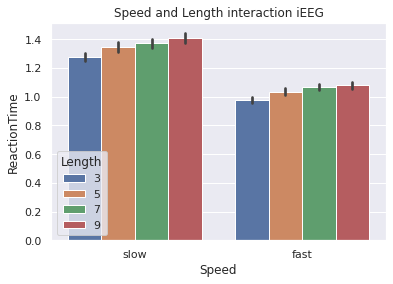

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Speed', y = 'ReactionTime', hue = 'Length',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['slow', 'fast'])
pl.title('Speed and Length interaction iEEG');

print('Fast')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Slow')
subset = ieeg_no_outliers[ieeg_no_outliers['Speed'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Length 3')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 3]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 5]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 7]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 9]
x, y = subset[subset['Speed'] == 1][['ReactionTime']], subset[subset['Speed'] == 0][['ReactionTime']]
print(ttest(x,y))

**Models with Speed as var' RT**

In [ ]:
%%R
comp1<-lmer('ReactionTime ~ Lex + Length + ProbeType + Speed + Speed:ProbeType + ProbeType:Length + (1|Subject)', data=eeg_no_trials)
comp2<-lmer('ReactionTime ~ Lex + Length + ProbeType + Speed + Speed:ProbeType + ProbeType:Length + Lex:Length + (1|Subject)', data=eeg_no_trials)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    9 2141.947 2201.407 -1061.973 2123.947        NA NA         NA
2   10 2143.806 2209.873 -1061.903 2123.806 0.1407247  1  0.7075616


In [ ]:
mod = Lmer(
    'ReactionTime ~ Lex + Length + ProbeType + Speed + Speed:ProbeType + ProbeType:Length + (1|Subject)',
    data = eeg_no_trials
)
mod.fit()

Formula: ReactionTime~Lex+Length+ProbeType+Speed+Speed:ProbeType+ProbeType:Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1088.498 	 AIC: 2176.995

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.011  0.106
Residual               0.085  0.291

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.392   1.297    1.487  0.049   181.773  28.600   0.00   
Lex                 -0.042  -0.058   -0.027  0.008  5434.011  -5.344   0.00   
Length               0.032   0.021    0.043  0.006  5435.381   5.784   0.00   
ProbeType           -0.092  -0.140   -0.044  0.024  5434.873  -3.786   0.00   
Speed               -0.535  -0.627   -0.443  0.047    48.987 -11.364   0.00   
ProbeType:Speed      0.108   0.077    0.139  0.016  5434.535   6.781   0.00   
Length:ProbeType    -0.009  -0.016   -0.002  0.004  5435.467  -2.589   0.01   

                  Sig  
(Intercept)       ***  
Lex               ***  
Length            ***  
ProbeType         ***  
Speed             ***  
ProbeType:Speed   ***  
Length:ProbeType   **

In [ ]:
%%R
comp1<-lmer('ReactionTime ~ Speed + Lex + Length + ProbeType + Phono + ProbeType:Length + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('ReactionTime ~ Speed + Lex + Length + ProbeType + Phono + ProbeType:Length + Length:Phono + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    9 1769.366 1826.466 -875.6829 1751.366        NA NA         NA
2   10 1770.923 1834.368 -875.4614 1750.923 0.4431248  1  0.5056181


In [ ]:
mod = Lmer(
    'ReactionTime ~ Speed + Lex + Length + ProbeType + Phono + ProbeType:Length + (1|Subject)',
    data = ieeg_no_outliers
)
mod.fit()

Formula: ReactionTime~Speed+Lex+Length+ProbeType+Phono+ProbeType:Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4207	 Groups: {'Subject': 27.0}

Log-likelihood: -901.773 	 AIC: 1803.546

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.016  0.126
Residual               0.087  0.295

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.448   1.337    1.559  0.057   114.541  25.585  0.000   
Speed               -0.309  -0.407   -0.211  0.050    24.998  -6.168  0.000   
Lex                 -0.034  -0.052   -0.017  0.009  4175.026  -3.778  0.000   
Length              -0.005  -0.017    0.008  0.006  4175.424  -0.765  0.444   
ProbeType           -0.137  -0.188   -0.085  0.026  4175.381  -5.225  0.000   
Phono                0.017  -0.001    0.035  0.009  4177.099   1.858  0.063   
Length:ProbeType     0.016   0.008    0.024  0.004  4175.480   3.921  0.000   

                  Sig  
(Intercept)       ***  
Speed             ***  
Lex               ***  
Length                 
ProbeType         ***  
Phono               .  
Length:ProbeType  ***

### Good and bad performers 

**EEG**

In [ ]:
good = []
bad = []
good_bad = eeg_no_trials.groupby(['Subject'])[['ResponseCorrect']].mean().reset_index()
mean_acc = good_bad.ResponseCorrect.mean()
for i in good_bad.Subject.values:
  if good_bad[good_bad['Subject'] == i][['ResponseCorrect']].values > mean_acc:
    good.append(i)
  else:
    bad.append(i)

In [ ]:
goodbad = []
subjs = eeg_no_trials.Subject.values
for i in subjs:
  if i in bad:
    goodbad.append(0)
  elif i in good:
    goodbad.append(1)

In [ ]:
eeg_no_trials['Success'] = goodbad

In [ ]:
eeg_no_trials.groupby(['Success'])[['Trial']].count()

Trial
Success       
0         2441
1         3027

Ttest_indResult(statistic=array([8.0226601]), pvalue=array([1.30602261e-15]))


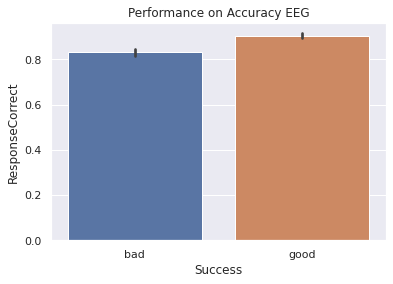

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ResponseCorrect',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance on Accuracy EEG')

x, y = eeg_no_trials[eeg_no_trials['Success'] == 1][['ResponseCorrect']], eeg_no_trials[eeg_no_trials['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([2.42638372]), pvalue=array([0.0153092]))
Bad
Ttest_indResult(statistic=array([3.6552981]), pvalue=array([0.00026241]))
Words
Ttest_indResult(statistic=array([4.89063282]), pvalue=array([1.07493371e-06]))
Non-words
Ttest_indResult(statistic=array([6.40499137]), pvalue=array([1.82374523e-10]))


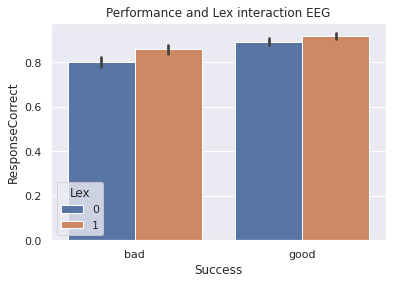

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ResponseCorrect', hue = 'Lex',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Lex interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['Lex'] == 1][['ResponseCorrect']], subset[subset['Lex'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['Lex'] == 1][['ResponseCorrect']], subset[subset['Lex'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Non-words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([0.9161913]), pvalue=array([0.3596396]))
Bad
Ttest_indResult(statistic=array([-1.40386164]), pvalue=array([0.16048915]))
Low
Ttest_indResult(statistic=array([6.72331585]), pvalue=array([2.27693596e-11]))
High
Ttest_indResult(statistic=array([4.63544968]), pvalue=array([3.75048466e-06]))


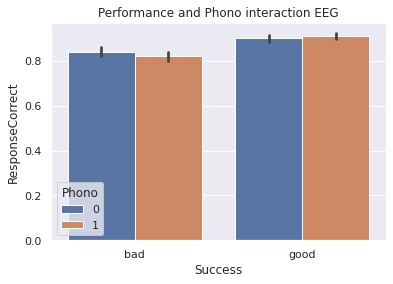

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ResponseCorrect', hue = 'Phono',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Phono interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['Phono'] == 1][['ResponseCorrect']], subset[subset['Phono'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['Phono'] == 1][['ResponseCorrect']], subset[subset['Phono'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Low')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 1]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('High')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 0]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-0.08315494]), pvalue=array([0.93373385]))
Bad
Ttest_indResult(statistic=array([-7.59254321]), pvalue=array([4.58550416e-14]))
Mismatch
Ttest_indResult(statistic=array([9.26658585]), pvalue=array([4.68840348e-20]))
Match
Ttest_indResult(statistic=array([1.58874309]), pvalue=array([0.11224193]))


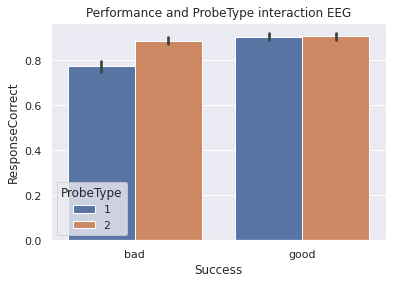

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ResponseCorrect', hue = 'ProbeType',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and ProbeType interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ResponseCorrect']], subset[subset['ProbeType'] == 2][['ResponseCorrect']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ResponseCorrect']], subset[subset['ProbeType'] == 2][['ResponseCorrect']]
print(ttest(x,y))
print('Mismatch')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Match')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))

Good
Length 3 vs 5
Ttest_indResult(statistic=array([5.60235791]), pvalue=array([2.70670284e-08]))
Length 5 vs 7
Ttest_indResult(statistic=array([-4.14338291]), pvalue=array([3.62673277e-05]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.39905884]), pvalue=array([0.16200157]))

Bad
Length 3 vs 5
Ttest_indResult(statistic=array([7.82998216]), pvalue=array([1.33787963e-14]))
Length 5 vs 7
Ttest_indResult(statistic=array([-0.96306008]), pvalue=array([0.33570846]))
Length 7 vs 9
Ttest_indResult(statistic=array([2.29191073]), pvalue=array([0.02208136]))

Length 3
Ttest_indResult(statistic=array([3.09439518]), pvalue=array([0.00203231]))
Length 5
Ttest_indResult(statistic=array([5.96783821]), pvalue=array([3.30870644e-09]))
Length 7
Ttest_indResult(statistic=array([3.19290084]), pvalue=array([0.00144502]))
Length 9
Ttest_indResult(statistic=array([4.27450344]), pvalue=array([2.06785609e-05]))


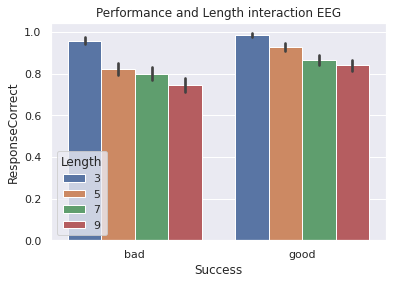

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ResponseCorrect', hue = 'Length',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Length interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 9][['ResponseCorrect']]
print(ttest(x,y))
print('')
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 5][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ResponseCorrect']], subset[subset['Length'] == 9][['ResponseCorrect']]
print(ttest(x,y))
print('')
print('Length 3')
subset = eeg_no_trials[eeg_no_trials['Length'] == 3]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 5')
subset = eeg_no_trials[eeg_no_trials['Length'] == 5]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 7')
subset = eeg_no_trials[eeg_no_trials['Length'] == 7]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))
print('Length 9')
subset = eeg_no_trials[eeg_no_trials['Length'] == 9]
x, y = subset[subset['Success'] == 1][['ResponseCorrect']], subset[subset['Success'] == 0][['ResponseCorrect']]
print(ttest(x,y))

**iEEG**

In [ ]:
good = []
bad = []
good_bad = ieeg_no_outliers.groupby(['Subject'])[['RespCorrect']].mean().reset_index()
mean_acc = good_bad.RespCorrect.mean()
for i in good_bad.Subject.values:
  if good_bad[good_bad['Subject'] == i][['RespCorrect']].values > mean_acc:
    good.append(i)
  else:
    bad.append(i)

In [ ]:
goodbad = []
subjs = ieeg_no_outliers.Subject.values
for i in subjs:
  if i in bad:
    goodbad.append(0)
  elif i in good:
    goodbad.append(1)

In [ ]:
ieeg_no_outliers['Success'] = goodbad

In [ ]:
ieeg_no_outliers.groupby(['Success'])[['Trial']].count()

Trial
Success       
0         2011
1         2196

Ttest_indResult(statistic=array([7.21612295]), pvalue=array([6.41139603e-13]))


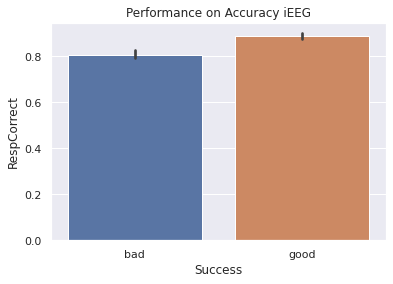

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'RespCorrect',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance on Accuracy iEEG')

x, y = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1][['RespCorrect']], ieeg_no_outliers[ieeg_no_outliers['Success'] == 0][['RespCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([1.55356883]), pvalue=array([0.12043153]))
Bad
Ttest_indResult(statistic=array([-0.45448442]), pvalue=array([0.64952931]))
Words
Ttest_indResult(statistic=array([6.09197384]), pvalue=array([1.34967592e-09]))
Non-words
Ttest_indResult(statistic=array([4.13395839]), pvalue=array([3.71567232e-05]))


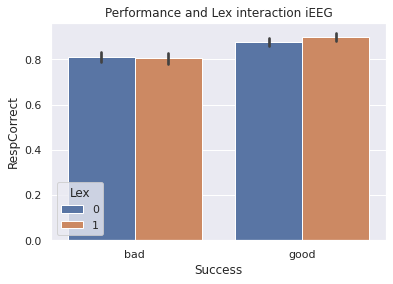

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'RespCorrect', hue = 'Lex',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Lex interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['Lex'] == 1][['RespCorrect']], subset[subset['Lex'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['Lex'] == 1][['RespCorrect']], subset[subset['Lex'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Non-words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-0.17455382]), pvalue=array([0.86144659]))
Bad
Ttest_indResult(statistic=array([1.34222057]), pvalue=array([0.17968135]))
Low
Ttest_indResult(statistic=array([4.52810038]), pvalue=array([6.28736651e-06]))
High
Ttest_indResult(statistic=array([5.70540338]), pvalue=array([1.35858604e-08]))


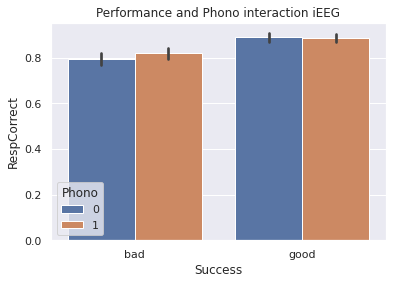

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'RespCorrect', hue = 'Phono',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Phono interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['Phono'] == 1][['RespCorrect']], subset[subset['Phono'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['Phono'] == 1][['RespCorrect']], subset[subset['Phono'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Low')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('High')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-2.23344421]), pvalue=array([0.02562039]))
Bad
Ttest_indResult(statistic=array([-2.40581002]), pvalue=array([0.01622667]))
Mismatch
Ttest_indResult(statistic=array([5.34165668]), pvalue=array([1.02248676e-07]))
Match
Ttest_indResult(statistic=array([4.78869358]), pvalue=array([1.81758631e-06]))


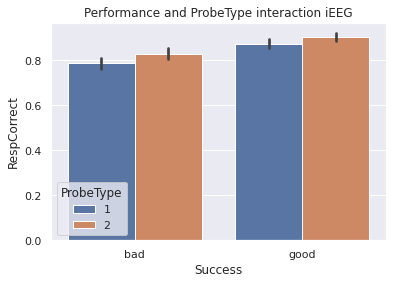

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'RespCorrect', hue = 'ProbeType',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and ProbeType interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['ProbeType'] == 1][['RespCorrect']], subset[subset['ProbeType'] == 2][['RespCorrect']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['ProbeType'] == 1][['RespCorrect']], subset[subset['ProbeType'] == 2][['RespCorrect']]
print(ttest(x,y))
print('Mismatch')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Match')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))

Good
Length 3 vs 5
Ttest_indResult(statistic=array([3.99154823]), pvalue=array([7.11300479e-05]))
Length 5 vs 7
Ttest_indResult(statistic=array([-4.08745503]), pvalue=array([4.70654547e-05]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.30341685]), pvalue=array([0.19270713]))

Bad
Length 3 vs 5
Ttest_indResult(statistic=array([2.20171067]), pvalue=array([0.02791304]))
Length 5 vs 7
Ttest_indResult(statistic=array([-3.59305807]), pvalue=array([0.00034317]))
Length 7 vs 9
Ttest_indResult(statistic=array([1.74332445]), pvalue=array([0.08158394]))

Length 3
Ttest_indResult(statistic=array([5.04946532]), pvalue=array([5.58592323e-07]))
Length 5
Ttest_indResult(statistic=array([3.50365384]), pvalue=array([0.00048073]))
Length 7
Ttest_indResult(statistic=array([3.19230146]), pvalue=array([0.00145566]))
Length 9
Ttest_indResult(statistic=array([3.69815395]), pvalue=array([0.00022902]))


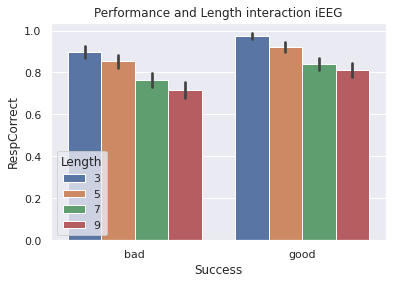

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'RespCorrect', hue = 'Length',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Length interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 9][['RespCorrect']]
print(ttest(x,y))
print('')
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 5][['RespCorrect']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['RespCorrect']], subset[subset['Length'] == 9][['RespCorrect']]
print(ttest(x,y))
print('')
print('Length 3')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 3]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 5]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 7]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 9]
x, y = subset[subset['Success'] == 1][['RespCorrect']], subset[subset['Success'] == 0][['RespCorrect']]
print(ttest(x,y))

**Models with Performance variable Accuracy**

In [ ]:
%%R -i eeg_no_trials
comp1<-lmer('ResponseCorrect ~ Length + Lex + ProbeType + Success + ProbeType:Lex + ProbeType:Length + Success:ProbeType + (1|Subject)', data=eeg_no_trials)
comp2<-lmer('ResponseCorrect ~ Length + Lex + ProbeType + Success + ProbeType:Lex + ProbeType:Length + Success:ProbeType + Success:Lex:ProbeType + (1|Subject)', data=eeg_no_trials)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1   10 3162.802 3228.868 -1571.401 3142.802       NA NA         NA
2   11 3163.259 3235.932 -1570.629 3141.259 1.543077  1  0.2141603


In [ ]:
mod = Lmer(
    'ResponseCorrect ~ Length + Lex + ProbeType + Success + ProbeType:Lex + ProbeType:Length + Success:ProbeType + (1|Subject)',
    data = eeg_no_trials
)
mod.fit()

Formula: ResponseCorrect~Length+Lex+ProbeType+Success+ProbeType:Lex+ProbeType:Length+Success:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1603.530 	 AIC: 3207.060

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.007
Residual               0.104  0.323

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)           0.867   0.779    0.955  0.045  5076.706  19.391  0.000   
Length               -0.041  -0.053   -0.029  0.006  5455.967  -6.642  0.000   
Lex                   0.101   0.047    0.156  0.028  5436.757   3.653  0.000   
ProbeType             0.078   0.022    0.133  0.028  5446.294   2.750  0.006   
Success               0.242   0.187    0.296  0.028  1749.603   8.642  0.000   
Lex:ProbeType        -0.044  -0.078   -0.009  0.018  5437.356  -2.493  0.013   
Length:ProbeType      0.008   0.001    0.016  0.004  5456.778   2.153  0.031   
ProbeType:Success    -0.111  -0.146   -0.077  0.018  5445.589  -6.331  0.000   

                   Sig  
(Intercept)        ***  
Length             ***  
Lex                ***  
ProbeType           **  
Success            ***  
Lex:ProbeType        *  
Length:ProbeType     *  
ProbeType:Success  ***

In [ ]:
%%R -i ieeg_no_outliers
comp1<-lmer('RespCorrect ~ ProbeType + Length + Success + Lex + Lex:ProbeType + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('RespCorrect ~ ProbeType + Length + Success + Lex + Lex:ProbeType + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance Chisq Df Pr..Chisq.
1    8 3073.397 3124.153 -1528.698 3057.397    NA NA         NA
2    8 3073.397 3124.153 -1528.698 3057.397     0  0         NA


In [ ]:
mod = Lmer(
    'RespCorrect ~ ProbeType + Length + Success + Lex + Lex:ProbeType + (1|Subject)',
    data = ieeg_no_outliers
)
mod.fit()

Formula: RespCorrect~ProbeType+Length+Success+Lex+Lex:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 4207	 Groups: {'Subject': 27.0}

Log-likelihood: -1551.881 	 AIC: 3103.762

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.001
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       0.864   0.807    0.920  0.029  2377.512  29.965    0.0  ***
ProbeType         0.079   0.049    0.109  0.015  4190.019   5.201    0.0  ***
Length           -0.030  -0.035   -0.025  0.002  4177.359 -12.417    0.0  ***
Success           0.080   0.059    0.101  0.011    25.005   7.432    0.0  ***
Lex               0.137   0.071    0.203  0.034  4197.331   4.083    0.0  ***
ProbeType:Lex    -0.087  -0.129   -0.044  0.022  4192.273  -4.018    0.0  ***

**Reaction Time**

**EEG**

Ttest_indResult(statistic=array([1.87284392]), pvalue=array([0.06114645]))


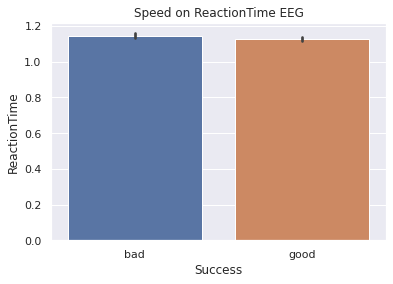

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', data = eeg_no_trials
    );
ax.set_xticklabels(['bad', 'good'])
pl.title('Speed on ReactionTime EEG');

x, y = eeg_no_trials[eeg_no_trials['Success'] == 0][['ReactionTime']], eeg_no_trials[eeg_no_trials['Success'] == 1][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-4.23461163]), pvalue=array([2.35774643e-05]))
Bad
Ttest_indResult(statistic=array([-2.55710763]), pvalue=array([0.01061474]))
Words
Ttest_indResult(statistic=array([-1.95176572]), pvalue=array([0.05107367]))
Non-words
Ttest_indResult(statistic=array([-0.71229162]), pvalue=array([0.47634903]))


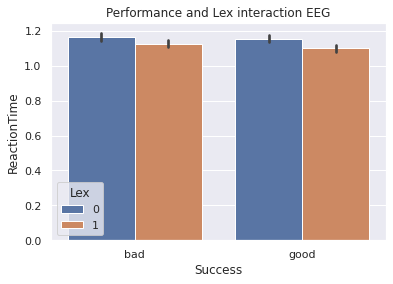

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Lex',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Lex interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Non-words')
subset = eeg_no_trials[eeg_no_trials['Lex'] == 0]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-0.26025915]), pvalue=array([0.7946816]))
Bad
Ttest_indResult(statistic=array([1.81983276]), pvalue=array([0.06890795]))
Low
Ttest_indResult(statistic=array([-2.41978092]), pvalue=array([0.01560195]))
High
Ttest_indResult(statistic=array([-0.27265128]), pvalue=array([0.78514218]))


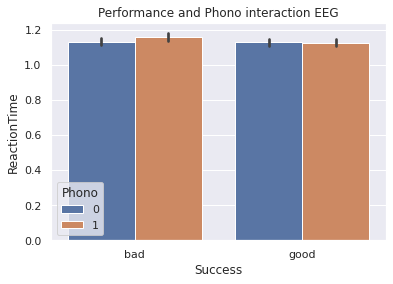

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Phono',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Phono interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Low')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('High')
subset = eeg_no_trials[eeg_no_trials['Phono'] == 0]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([3.90391262]), pvalue=array([9.67477885e-05]))
Bad
Ttest_indResult(statistic=array([8.64697028]), pvalue=array([9.70046476e-18]))
Mismatch
Ttest_indResult(statistic=array([-3.86454879]), pvalue=array([0.00011411]))
Match
Ttest_indResult(statistic=array([1.47757823]), pvalue=array([0.13963862]))


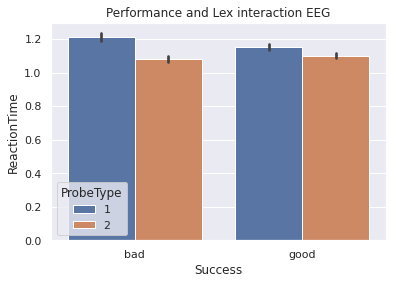

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'ProbeType',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Lex interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Mismatch')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Match')
subset = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Length 3 vs 5
Ttest_indResult(statistic=array([-3.19957408]), pvalue=array([0.00140495]))
Length 5 vs 7
Ttest_indResult(statistic=array([2.16646509]), pvalue=array([0.03043188]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.17519573]), pvalue=array([0.86094937]))

Bad
Length 3 vs 5
Ttest_indResult(statistic=array([-5.58489715]), pvalue=array([2.88472612e-08]))
Length 5 vs 7
Ttest_indResult(statistic=array([0.77325721]), pvalue=array([0.43952013]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.26464466]), pvalue=array([0.79132785]))

Length 3
Ttest_indResult(statistic=array([0.62248327]), pvalue=array([0.53373336]))
Length 5
Ttest_indResult(statistic=array([-2.21777221]), pvalue=array([0.0267431]))
Length 7
Ttest_indResult(statistic=array([-0.9427968]), pvalue=array([0.34596054]))
Length 9
Ttest_indResult(statistic=array([-1.09610144]), pvalue=array([0.27324189]))


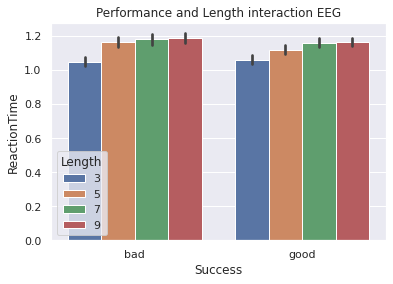

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Length',
    data = eeg_no_trials
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Length interaction EEG');

print('Good')
subset = eeg_no_trials[eeg_no_trials['Success'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Bad')
subset = eeg_no_trials[eeg_no_trials['Success'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Length 3')
subset = eeg_no_trials[eeg_no_trials['Length'] == 3]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 5')
subset = eeg_no_trials[eeg_no_trials['Length'] == 5]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 7')
subset = eeg_no_trials[eeg_no_trials['Length'] == 7]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 9')
subset = eeg_no_trials[eeg_no_trials['Length'] == 9]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

**iEEG**

Ttest_indResult(statistic=array([1.32035844]), pvalue=array([0.18678915]))


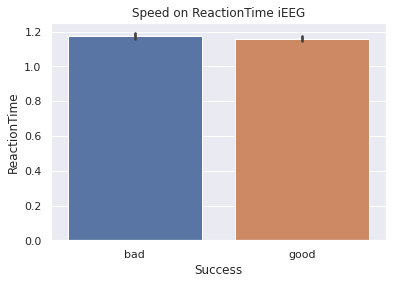

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', data = ieeg_no_outliers
    );
ax.set_xticklabels(['bad', 'good'])
pl.title('Speed on ReactionTime iEEG');

x, y = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0][['ReactionTime']], ieeg_no_outliers[ieeg_no_outliers['Success'] == 1][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([-2.50680999]), pvalue=array([0.01225441]))
Bad
Ttest_indResult(statistic=array([-1.58958227]), pvalue=array([0.11208634]))
Words
Ttest_indResult(statistic=array([-1.27243844]), pvalue=array([0.20336171]))
Non-words
Ttest_indResult(statistic=array([-0.60114191]), pvalue=array([0.54781217]))


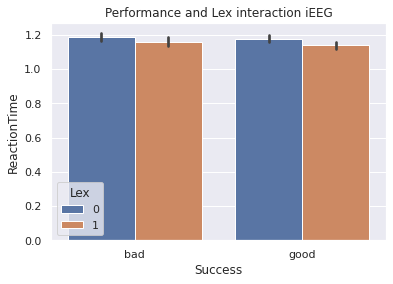

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Lex',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Lex interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['Lex'] == 1][['ReactionTime']], subset[subset['Lex'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Non-words')
subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([2.58307873]), pvalue=array([0.00985668]))
Bad
Ttest_indResult(statistic=array([0.48675704]), pvalue=array([0.6264852]))
Low
Ttest_indResult(statistic=array([-0.04902154]), pvalue=array([0.96090655]))
High
Ttest_indResult(statistic=array([-1.89256427]), pvalue=array([0.05857073]))


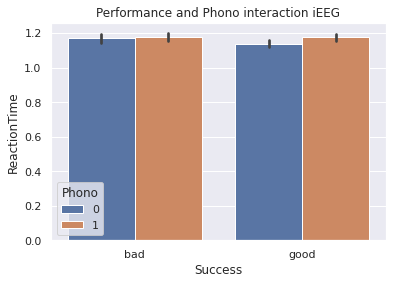

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Phono',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Phono interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['Phono'] == 1][['ReactionTime']], subset[subset['Phono'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Low')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('High')
subset = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Ttest_indResult(statistic=array([2.72261564]), pvalue=array([0.00652826]))
Bad
Ttest_indResult(statistic=array([3.32620662]), pvalue=array([0.00089626]))
Mismatch
Ttest_indResult(statistic=array([-1.34650393]), pvalue=array([0.17828272]))
Macth
Ttest_indResult(statistic=array([-0.3899832]), pvalue=array([0.69659138]))


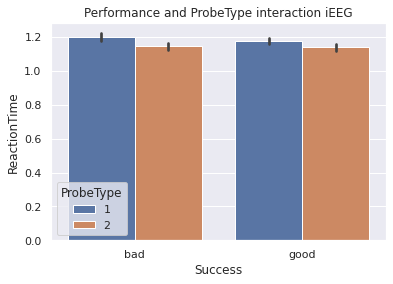

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'ProbeType',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and ProbeType interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
x, y = subset[subset['ProbeType'] == 1][['ReactionTime']], subset[subset['ProbeType'] == 2][['ReactionTime']]
print(ttest(x,y))
print('Mismatch')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Macth')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

Good
Length 3 vs 5
Ttest_indResult(statistic=array([-3.0556581]), pvalue=array([0.0023001]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.75785415]), pvalue=array([0.07905278]))
Length 7 vs 9
Ttest_indResult(statistic=array([-1.45384586]), pvalue=array([0.14627697]))

Bad
Length 3 vs 5
Ttest_indResult(statistic=array([-2.56953123]), pvalue=array([0.01032728]))
Length 5 vs 7
Ttest_indResult(statistic=array([1.00817529]), pvalue=array([0.31361477]))
Length 7 vs 9
Ttest_indResult(statistic=array([-0.56762055]), pvalue=array([0.57041974]))

Length 3
Ttest_indResult(statistic=array([-1.23815892]), pvalue=array([0.21593966]))
Length 5
Ttest_indResult(statistic=array([-1.0604671]), pvalue=array([0.2891867]))
Length 7
Ttest_indResult(statistic=array([-0.57443831]), pvalue=array([0.565798]))
Length 9
Ttest_indResult(statistic=array([0.20292224]), pvalue=array([0.83923596]))


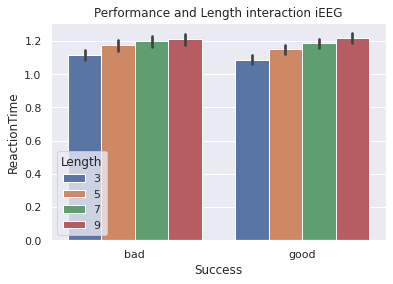

In [ ]:
pl.figure()
ax = sns.barplot(
    x = 'Success', y = 'ReactionTime', hue = 'Length',
    data = ieeg_no_outliers
)
ax.set_xticklabels(['bad', 'good'])
pl.title('Performance and Length interaction iEEG');

print('Good')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 1]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Bad')
subset = ieeg_no_outliers[ieeg_no_outliers['Success'] == 0]
print('Length 3 vs 5')
x, y = subset[subset['Length'] == 3][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 5 vs 7')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 5][['ReactionTime']]
print(ttest(x,y))
print('Length 7 vs 9')
x, y = subset[subset['Length'] == 7][['ReactionTime']], subset[subset['Length'] == 9][['ReactionTime']]
print(ttest(x,y))
print('')
print('Length 3')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 3]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 5')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 5]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 7')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 7]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))
print('Length 9')
subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == 9]
x, y = subset[subset['Success'] == 1][['ReactionTime']], subset[subset['Success'] == 0][['ReactionTime']]
print(ttest(x,y))

**Models with Performance Reaction Time**

In [ ]:
%%R
comp1<-lmer('ReactionTime ~ Lex + ProbeType + Length + Success + Success:ProbeType + Length:ProbeType + (1|Subject)', data=eeg_no_trials)
comp2<-lmer('ReactionTime ~ Lex + ProbeType + Length + Success + Success:ProbeType + Length:ProbeType + Success:Length + (1|Subject)', data=eeg_no_trials)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    9 2211.629 2271.089 -1096.814 2193.629        NA NA         NA
2   10 2213.240 2279.306 -1096.620 2193.240 0.3889143  1  0.5328706


In [ ]:
mod = Lmer(
    'ReactionTime ~ Lex + ProbeType + Length + Success + Success:ProbeType + Length:ProbeType + (1|Subject)',
    data = eeg_no_trials
)
mod.fit()

Formula: ReactionTime~Lex+ProbeType+Length+Success+Success:ProbeType+Length:ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5468	 Groups: {'Subject': 29.0}

Log-likelihood: -1121.911 	 AIC: 2243.822

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.048  0.219
Residual               0.085  0.292

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)           1.162   1.020    1.303  0.072    52.504  16.102  0.000   
Lex                  -0.042  -0.058   -0.026  0.008  5434.002  -5.302  0.000   
ProbeType            -0.069  -0.117   -0.021  0.024  5434.213  -2.819  0.005   
Length                0.032   0.021    0.043  0.006  5434.332   5.750  0.000   
Success              -0.118  -0.286    0.050  0.086    31.765  -1.382  0.177   
ProbeType:Success     0.066   0.035    0.097  0.016  5434.139   4.150  0.000   
ProbeType:Length     -0.009  -0.016   -0.002  0.004  5434.356  -2.581  0.010   

                   Sig  
(Intercept)        ***  
Lex                ***  
ProbeType           **  
Length             ***  
Success                 
ProbeType:Success  ***  
ProbeType:Length    **

In [ ]:
%%R
comp1<-lmer('ReactionTime ~ Lex + Length + ProbeType + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('ReactionTime ~ Lex + Length + ProbeType + Success + Success:ProbeType + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    6 1807.747 1845.814 -897.8735 1795.747       NA NA         NA
2    8 1810.352 1861.108 -897.1761 1794.352 1.394866  2  0.4978617


### Extra

## The effect of the experiment part on Accuracy

In [ ]:
# wanna check is there any difference depending on the part of experiment
# beginning of the experiment vs. the end 

**EEG dataset**

In [ ]:
trial_category = []
for i in eeg_data.Subject.unique():
  subset = eeg_data[eeg_data['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
eeg_data['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


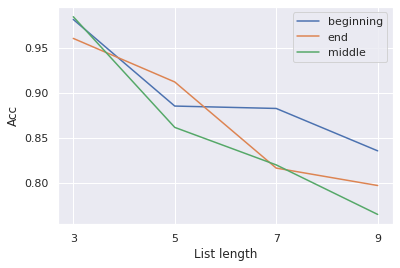

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

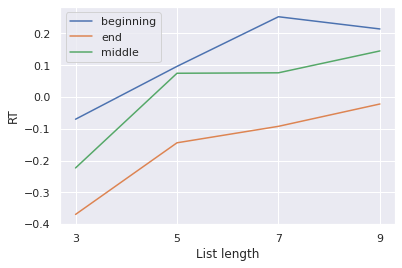

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.TrialPos.unique());

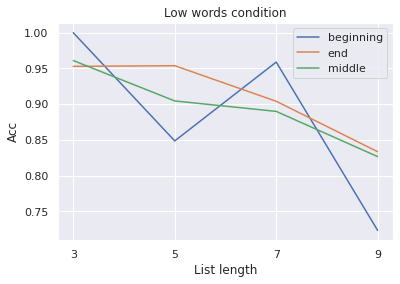

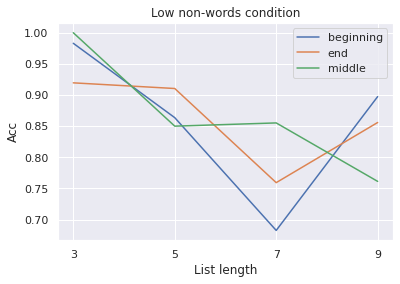

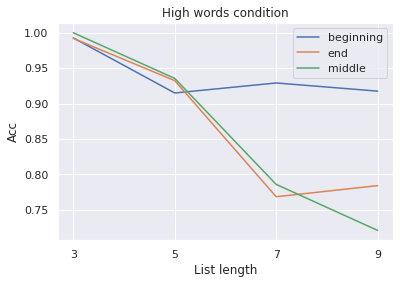

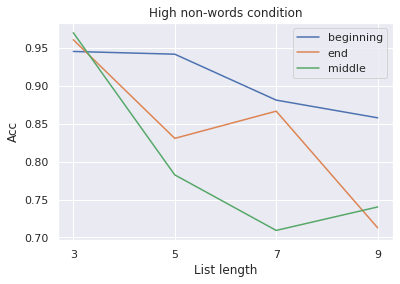

In [ ]:
# Accuracy
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

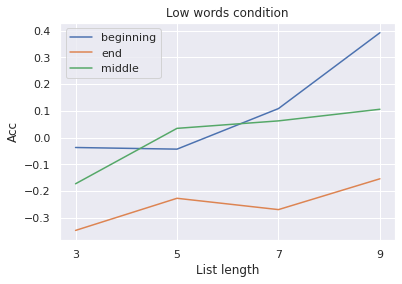

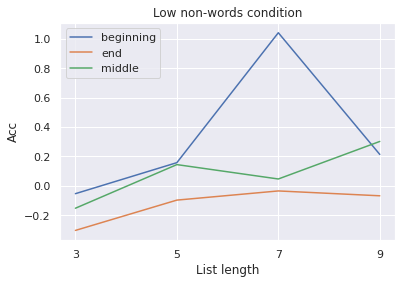

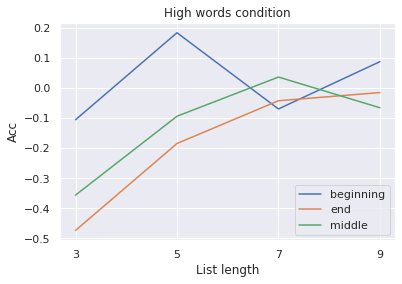

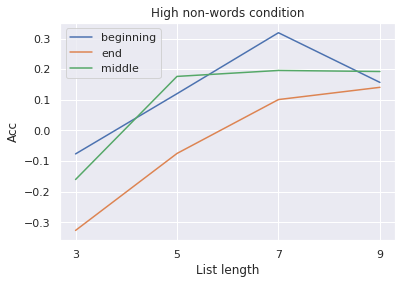

In [ ]:
# Reaction Time 
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
new = []
check = eeg_data.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
eeg_data['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos = Lmer(
    'ResponseCorrect ~ Lex + Length + TrialP + ProbeType + Phono + (1|Subject)',
    data = eeg_data
)
model_trialpos.fit()

Formula: ResponseCorrect~Lex+Length+TrialP+ProbeType+Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1549.434 	 AIC: 3098.867

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.973   0.932    1.014  0.021   984.435  46.304  0.000  ***
Lex             0.031   0.014    0.048  0.009  5300.607   3.505  0.000  ***
Length         -0.028  -0.032   -0.024  0.002  5300.455 -14.418  0.000  ***
TrialP         -0.013  -0.024   -0.003  0.005  5310.982  -2.467  0.014    *
ProbeType       0.046   0.029    0.063  0.009  5306.918   5.198  0.000  ***
Phono          -0.000  -0.017    0.017  0.009  5301.145  -0.003  0.998

**iEEG dataset**

In [ ]:
ieeg_sh.head()

Trial Subject block  ProbeType     stdRT  RespCorrect  Position  Length  \
0      0     D23     1          2 -0.896484            1         1       3   
1      1     D23     1          2  0.564665            1         1       7   
2      2     D23     1          2 -0.326257            1         2       7   
3      3     D23     1          1  1.041717            1         0       9   
4      4     D23     1          1  1.595710            1         0       5   

   Lex  Phono  
0    1      1  
1    1      0  
2    0      0  
3    1      1  
4    1      0

In [ ]:
trial_category = []
for i in ieeg_sh.Subject.unique():
  subset = ieeg_sh[ieeg_sh['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
ieeg_sh['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


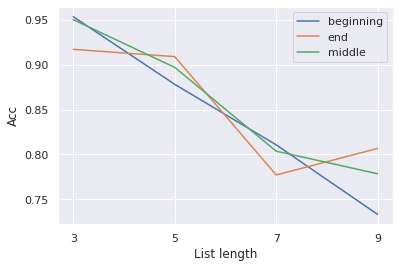

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

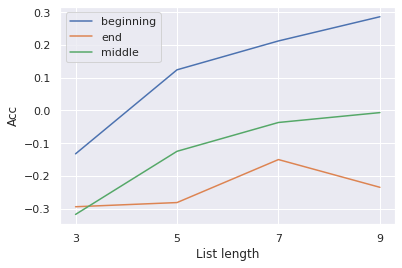

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

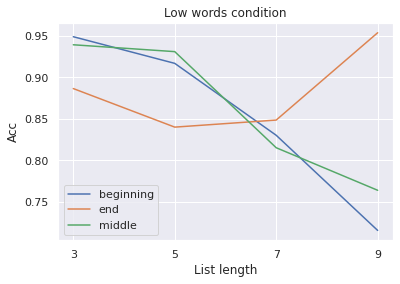

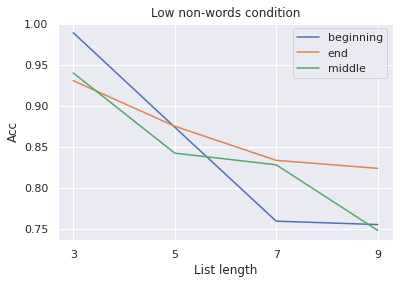

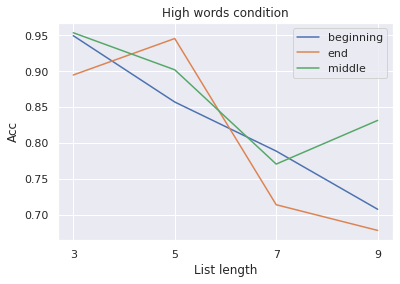

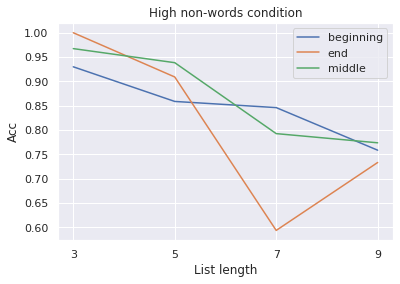

In [ ]:
# Accuracy
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

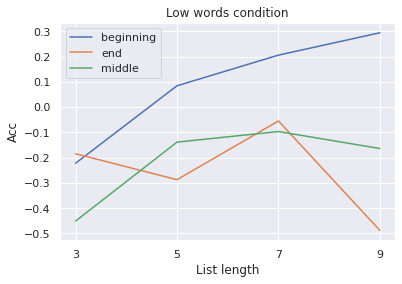

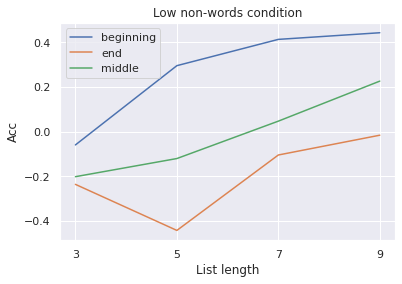

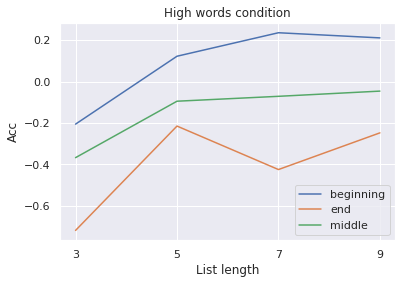

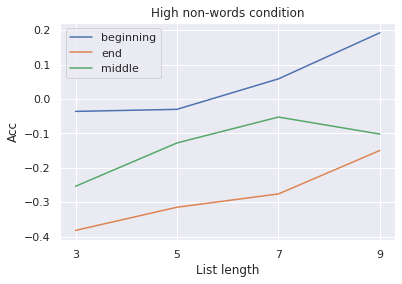

In [ ]:
# Reaction Time 
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
ieeg_sh.head()

Trial Subject block  ProbeType     stdRT  RespCorrect  Position  Length  \
0      0     D23     1          2 -0.896484            1         1       3   
1      1     D23     1          2  0.564665            1         1       7   
2      2     D23     1          2 -0.326257            1         2       7   
3      3     D23     1          1  1.041717            1         0       9   
4      4     D23     1          1  1.595710            1         0       5   

   Lex  Phono   TrialPos  TrialP  
0    1      1  beginning       0  
1    1      0  beginning       0  
2    0      0  beginning       0  
3    1      1  beginning       0  
4    1      0  beginning       0

In [ ]:
new = []
check = ieeg_sh.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
ieeg_sh['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos_i = Lmer(
    'RespCorrect ~ Lex + Length + Phono + ProbeType + TrialP + (1|Subject)',
    data = ieeg_sh
)
model_trialpos_i.fit()

Formula: RespCorrect~Lex+Length+Phono+ProbeType+TrialP+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3725	 Groups: {'Subject': 25.0}

Log-likelihood: -1372.663 	 AIC: 2745.326

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.980   0.927    1.033  0.027  1159.776  36.307  0.000  ***
Lex             0.011  -0.011    0.033  0.011  3695.580   0.959  0.338     
Length         -0.032  -0.037   -0.027  0.003  3696.417 -12.518  0.000  ***
Phono           0.008  -0.014    0.030  0.011  3712.172   0.700  0.484     
ProbeType       0.033   0.010    0.055  0.011  3707.061   2.855  0.004   **
TrialP          0.005  -0.011    0.020  0.008  3719.000   0.586  0.558

## Accuracy plots EEG with 'No response trials' as incorrect

1.   100 'No response' trials
2.   No subjects less than 75% accurate
3.   The max of no response trials - 10% of all trials



In [ ]:
eeg[eeg['Response'] == 'No Response'].groupby(['Subject'])[['Trial']].count()

In [ ]:
eeg[eeg['Response'] == 'No Response'].groupby(['ProbeCategory'])[['Trial']].count()

Trial
ProbeCategory        
high non-words     28
high words         20
low non-words      32
low words          20

BOTH MATCH AND MISMATCH

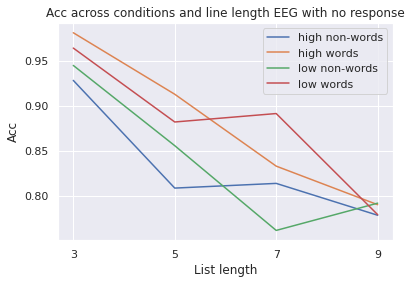

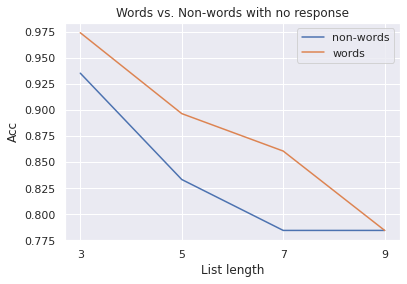

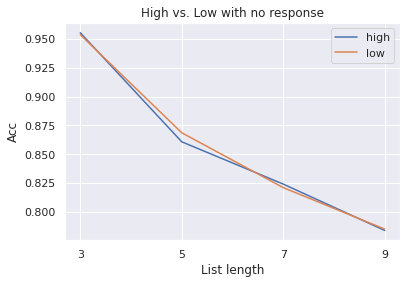

In [ ]:
pl.figure()
subset = eeg.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG with no response');

pl.figure()
subset = eeg.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words with no response');

pl.figure()
subset = eeg.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low with no response');

ONLY MATCH

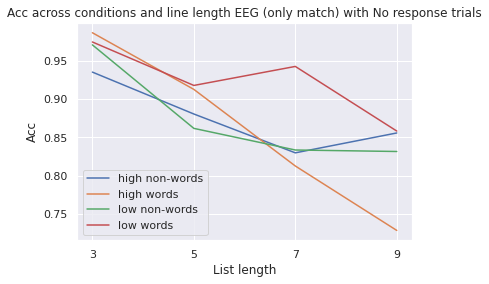

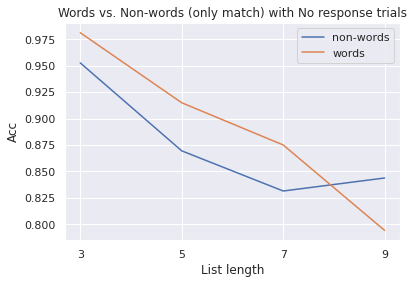

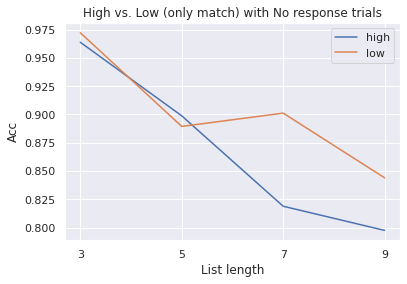

In [ ]:
only_match = eeg[eeg['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match) with No response trials');

ONLY MISMATCH

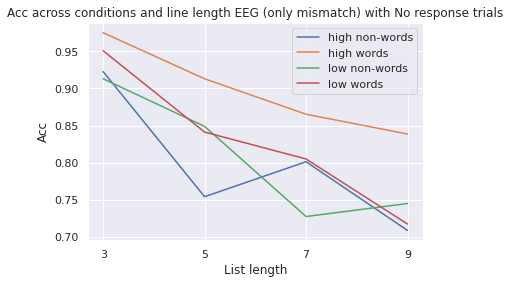

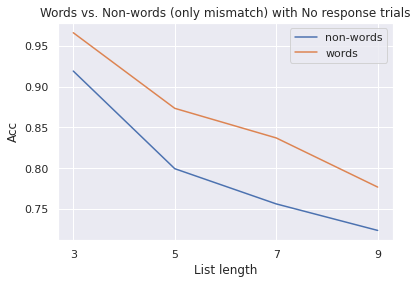

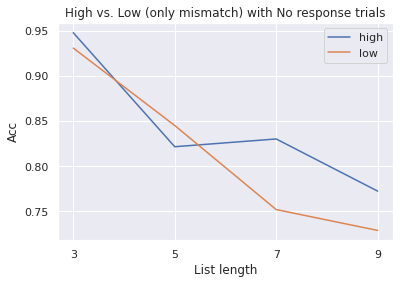

In [ ]:
only_mismatch = eeg[eeg['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch) with No response trials');

MATCH AND MISMATCH ON THE SAME PLOT

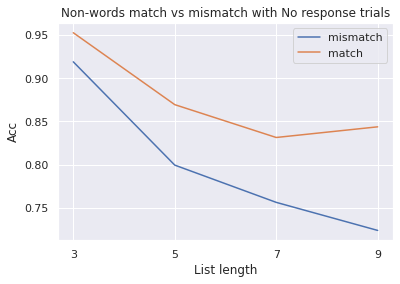

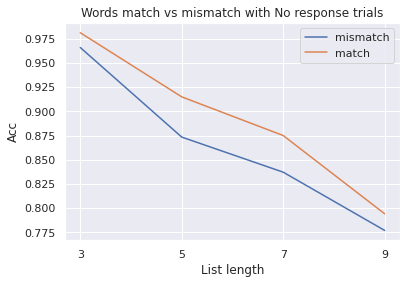

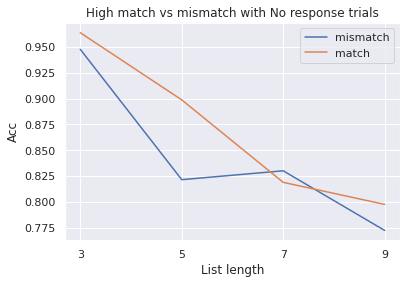

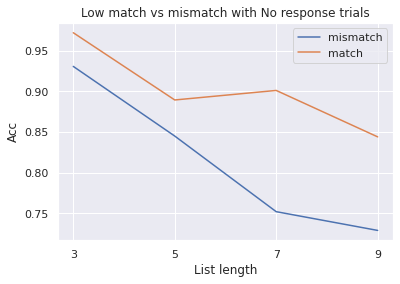

In [ ]:
pl.figure()
nonwords = eeg[eeg['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = eeg[eeg['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = eeg[eeg['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = eeg[eeg['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');

## Accuracy plots iEEG dataset with 'No response' trials

BOTH MATCH AND MISMATCH

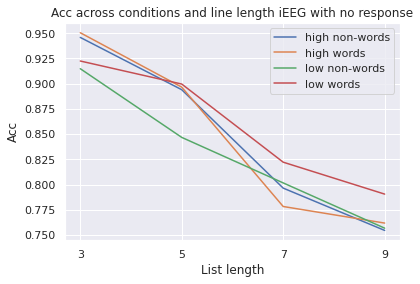

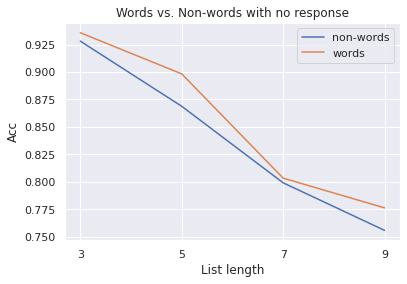

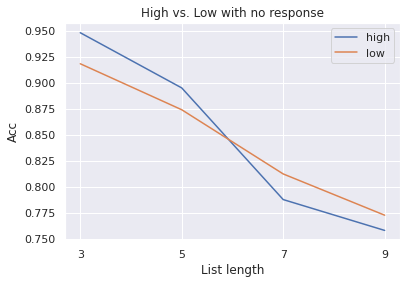

In [ ]:
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG with no response');

pl.figure()
subset = ieeg_no_outliers.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words with no response');

pl.figure()
subset = ieeg_no_outliers.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low with no response');

ONLY MATCH

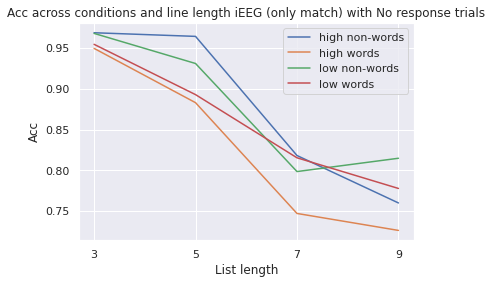

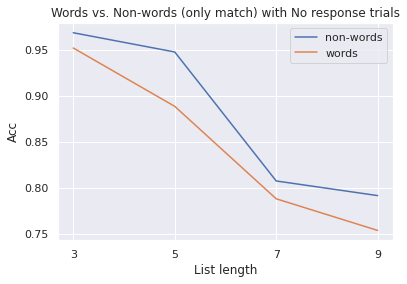

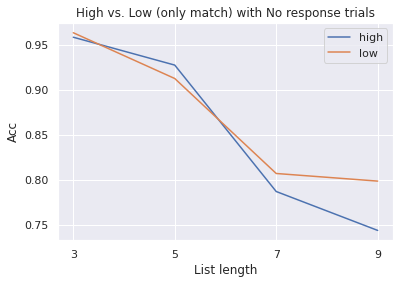

In [ ]:
only_match = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match) with No response trials');

ONLY MISMATCH

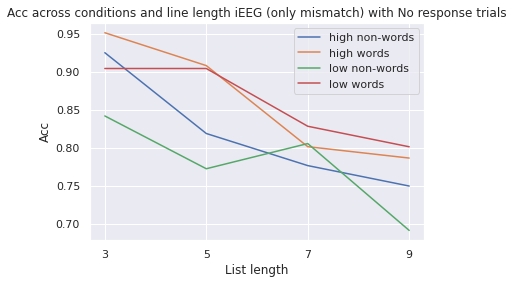

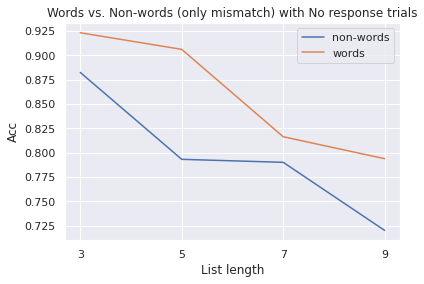

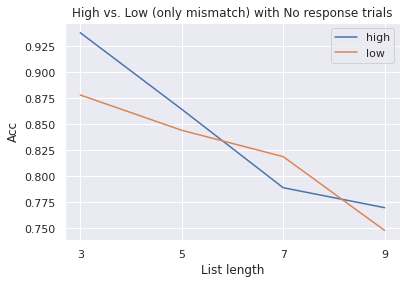

In [ ]:
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch) with No response trials');

MATCH AND MISMATCH ON THE SAME PLOT

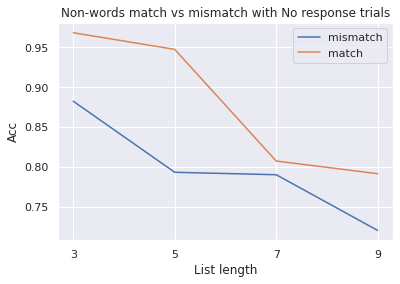

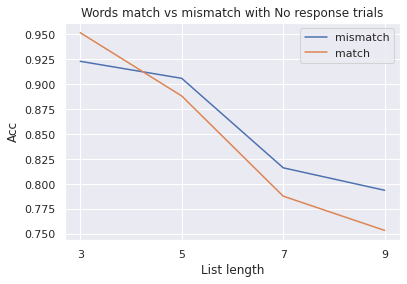

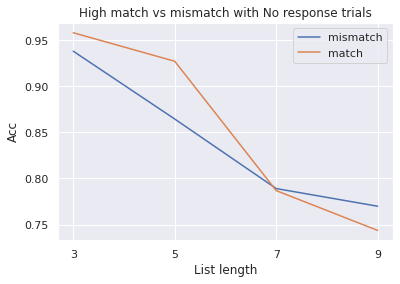

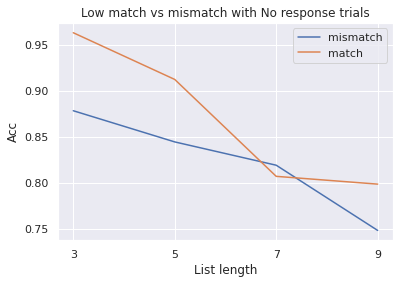

In [ ]:
pl.figure()
nonwords = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');